# Models for Pluto's and its Moons' System

# Models 5 - 6

##### In this notebook is the code for the 5th and 6th versions or models. Basically, these models are the same as model 2 (6BP) and model 4 (OPC(6BP)) but with the consideration that the PLS's barycenter is moving. We also now use a symplectic version of 4th order Runge-Kutta method. For more information about the theory and the justification for the equations used, please read the project report.

## Libraries and Initial Conditions 

##### Here, we declare our libraries and the constants that each body will be using through our calculations.

In [1]:
#LIBRARIES:

#-------------------------------------------------------------------------------------------------------------------------------
#Libraries for the functions and math operations.
import numpy as np
import math

#Libraries for graph and plotting.
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.patches import Ellipse
from matplotlib import cm

#Libraries for GIF animations.
import os
import imageio

#Library for the progress bar during loops.
from tqdm.notebook import tqdm, trange

#-------------------------------------------------------------------------------------------------------------------------------
#Line to activate the interface for matplotlib here in Jupyter Notebook. (Un-comment it if you want to use it)
#%matplotlib notebook

#-------------------------------------------------------------------------------------------------------------------------------
#Masses for each body.
pl_m = 1.3030e22  # ± 2.7e19 (kg)
ch_m = 1.587e21   # ± 1.5e19 (kg)
st_m = 7.5e15     # > real mass (kg)
ni_m = 4.5e16     # ± 4.0e16 (kg)
ke_m = 1.6e16     # ± 0.9e16 (kg)
hy_m = 4.8e16     # ± 4.2e16 (kg)
sun_m = 1.989e30  # kg
jup_m = 1.899069561e27  # (kg)
bary_m = pl_m + ch_m + st_m + ni_m + ke_m + hy_m

#Equatorial coordinates for the direction of the rotation´s north pole:
RA_pl = 132.99
dec_pl = 96.16

RA_ch = 132.99
dec_ch = 96.16

RA_jup = 268.056595
dec_jup = 25.504697

# 2nd Spheric Harmonics:
J2_pl = 1.249668221e-4
J2_ch = 5.707768698e-3
J2_jup = 0.01902489952

#Equatorial radii:
r_eq_pl = 1188 #km
r_eq_ch = 606 #km
r_eq_jup = 71492 #km

#PLS's angular velocity (barycenter).
w = 6.93814632e-5   #rad/d

#-------------------------------------------------------------------------------------------------------------------------------
#Colors for plotting and graphs:
col_pl = "red"
col_ch = "blue"
col_st = "green"
col_ni = "darkkhaki"
col_ke = "palevioletred"
col_hy = "darkorchid"

col_sun  = "gold"
col_bary = "darkred"
col_jup = "brown"


## JPL/NASA Data

##### As we did with models 1-4, we first analyze de PLS "official" data from JPL/NASA. We take coordinates and velocities ina Cartesian coordinate system known as ICRF. Its XY plane is the ecliptic.

##### Each extracted file from the HORIZONS system from JPL/NASA contains 34,561 registers for a body.

### Data Extraction and Analysis

##### We open the text files (organized as CSV) with the ephemeris for each body. We used the dates from Jan/1/2021 to May/1/2021 with a register every 5 min. Therefore, we have 288 coordinates and velocities per day during those 4 months.

In [2]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function for a vector´s magnitude.
def mag(x, y, z):
    return math.sqrt(x**2 + y**2 + z**2)

#Function for the average.
def avg(arr):
    return sum(arr)/len(arr)

#-------------------------------------------------------------------------------------------------------------------------------
#Function to extract the data from the file downloaded from JPLNASA (HORIZONS).
def ext_data(file):
    r = np.empty((0, 4), float)     # The matrices are declared.
    v = np.empty((0, 4), float)
    for line in file:
        lst = line.strip().split()    # This cuts extra spaces at the end of each line and separates
                                      # every "word" in an element of a STRING type array.
        
        # The values are added to the corresponding array.
        r = np.append(r, [[float(lst[4]), float(lst[5]), float(lst[6]), mag(float(lst[4]), float(lst[5]), float(lst[6]))]], axis=0)
        v = np.append(v, [[float(lst[7]), float(lst[8]), float(lst[9]), mag(float(lst[7]), float(lst[8]), float(lst[9]))]], axis=0)
    
    return r, v   # Returns the arrays.

#Function to adjust the coordinates to a reference system centered at the PLS's barycenter.
def conver_bary(r, bary, title):
    rn = np.empty((len(r[:,0]), 4), float)
    lim = tqdm(range(len(r[:,0])), desc="Conver. "+title+": ")
    for i in lim:
        rn[i,0], rn[i,1], rn[i,2] = r[i,0]-bary[i,0], r[i,1]-bary[i,1], r[i,2]-bary[i,2]
        rn[i,3] = mag(rn[i,0], rn[i,1], rn[i,2])
    
    return rn

#-------------------------------------------------------------------------------------------------------------------------------
#Functions for the analysis of the extracted data.

#Function for the max. value in a matrix column.
def maxCol(mat, n):
    m = len(mat)          # No. of rows.
    col_max = mat[0, n]   # It begins with the first element in the column.
    for i in range(m):    # It compares each value with the loaded current highest value.
        col_max = max(col_max, mat[i, n])

    return col_max

#Function for the min. value in a matrix column.
def minCol(mat, n):
    m = len(mat)          # No. of rows.
    col_min = mat[0, n]   # It begins with the first element in the column.
    for i in range(m):    # It compares each value with the loaded current lowest value.
        col_min = min(col_min, mat[i, n]) 

    return col_min

#Function to calculate the approximated parameters for the elliptic trajectories.
def param(r, n):
    a = (maxCol(r, n) + minCol(r, n)) / 2    # It obtains an approximation of the major axis and divides it in 2.
    c = maxCol(r, n) - a                # It substracts "a" from the major axis (approx. of the focus-vertex distance).
    b = math.sqrt(a**2 - c**2)     # It calculates "b" with Pythagoras theorem.
    e = c / a                      # It calculates the eccentricity.
    return a, b, c, e

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot each trajectory individually.
def plot_orbit(title, r, color):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if (title == "Kerberos"):
            ax.set_title(title + "' Trajectory", fontweight="bold", fontsize=14)
    else:
        ax.set_title(title + "'s Trajectory", fontweight="bold", fontsize=14)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.scatter(r[:,0], r[:,1], r[:,2], marker="x", c=color, s=1);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    fig.set_size_inches(8, 8)
    plt.show()


In [3]:
pluto    = open("data (M 5-6)/pluto5-6.txt")      # Each file is opened with its body´s name.
charon   = open("data (M 5-6)/charon5-6.txt")
styx     = open("data (M 5-6)/styx5-6.txt")
nix      = open("data (M 5-6)/nix5-6.txt")
kerberos = open("data (M 5-6)/kerberos5-6.txt")
hydra    = open("data (M 5-6)/hydra5-6.txt")
sun      = open("data (M 5-6)/sun5-6.txt")
jupiter  = open("data (M 5-6)/jupiter5-6.txt")
bary     = open("data (M 5-6)/barycenter5-6.txt")

#-------------------------------------------------------------------------------------------------------------------------------
#We call the extracting function for each body.
pl_R, pl_V = ext_data(pluto)
ch_R, ch_V = ext_data(charon)
st_R, st_V = ext_data(styx)
ni_R, ni_V = ext_data(nix)
ke_R, ke_V = ext_data(kerberos)
hy_R, hy_V = ext_data(hydra)
sun_R, sun_V = ext_data(sun)
jup_R, jup_V = ext_data(jupiter)
bary_R, bary_V = ext_data(bary)

#Converting the coordinates and velocities to the PLS's barycenter reference system.
pl_r, pl_v = conver_bary(pl_R, bary_R, "Pl"), conver_bary(pl_V, bary_V, "Pl")
ch_r, ch_v = conver_bary(ch_R, bary_R, "Ch"), conver_bary(ch_V, bary_V, "Ch")
st_r, st_v = conver_bary(st_R, bary_R, "St"), conver_bary(st_V, bary_V, "St")
ni_r, ni_v = conver_bary(ni_R, bary_R, "Ni"), conver_bary(ni_V, bary_V, "Ni")
ke_r, ke_v = conver_bary(ke_R, bary_R, "Ke"), conver_bary(ke_V, bary_V, "Ke")
hy_r, hy_v = conver_bary(hy_R, bary_R, "Hy"), conver_bary(hy_V, bary_V, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Approximation of the parameters for each elliptic trajectory.

# We obtained the largest and shortest radii from the data. We add them up and divide them in 2 to get an approximation of the
# semi-major axis from the elliptic trajectory of the body. Using this, calculating the approximated eccentricity was easy.

#    NOTE: It is important to say that these are NOT the parameters with which we compared our models. This is just an early
#          approximation to get an idea of what the later-obtained parameters will look like.

pl_a, pl_b, pl_c, pl_e = param(pl_r, 3)
ch_a, ch_b, ch_c, ch_e = param(ch_r, 3)
st_a, st_b, st_c, st_e = param(st_r, 3)
ni_a, ni_b, ni_c, ni_e = param(ni_r, 3)
ke_a, ke_b, ke_c, ke_e = param(ke_r, 3)
hy_a, hy_b, hy_c, hy_e = param(hy_r, 3)

print("LISTO\n")

Conver. Pl:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Pl:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ch:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ch:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. St:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. St:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ni:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ni:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ke:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Ke:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Hy:   0%|          | 0/34561 [00:00<?, ?it/s]

Conver. Hy:   0%|          | 0/34561 [00:00<?, ?it/s]

LISTO



APPROXIMATION FOR THE TRAJECTORIES:
Pluto:    \ a: 2131.940859 \ b: 2131.940836 \ c: 0.312112 \ e: 0.000146
Charon:   \ a: 17468.574350 \ b: 17468.574332 \ c: 0.790691 \ e: 0.000045
Styx:     \ a: 42502.974302 \ b: 42501.511623 \ c: 352.610699 \ e: 0.008296
Nix:      \ a: 48736.291720 \ b: 48735.868347 \ c: 203.143014 \ e: 0.004168
Kerberos: \ a: 57772.871710 \ b: 57772.419969 \ c: 228.465602 \ e: 0.003955
Hydra:    \ a: 64731.770564 \ b: 64730.701767 \ c: 371.980031 \ e: 0.005746


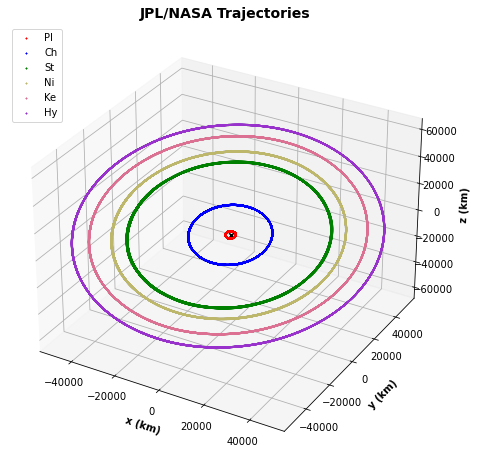

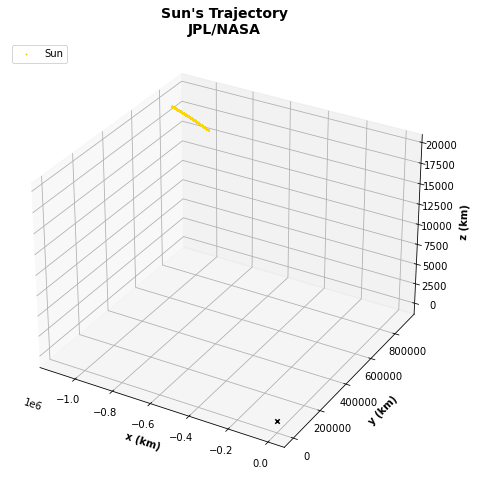

NameError: name 'col_bari' is not defined

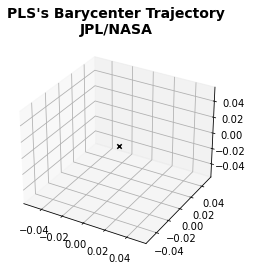

In [4]:
#-------------------------------------------------------------------------------------------------------------------------------
#Printing of the approximated parameters for each orbit´s ellipse.
print("APPROXIMATION FOR THE TRAJECTORIES:")
print("Pluto:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (pl_a, pl_b, pl_c, pl_e))
print("Charon:   \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ch_a, ch_b, ch_c, ch_e))
print("Styx:     \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (st_a, st_b, st_c, st_e))
print("Nix:      \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ni_a, ni_b, ni_c, ni_e))
print("Kerberos: \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ke_a, ke_b, ke_c, ke_e))
print("Hydra:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (hy_a, hy_b, hy_c, hy_e))


#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#All orbits together (all data from the 4 months).
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("JPL/NASA Trajectories", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r[:,0], pl_r[:,1], pl_r[:,2], marker="x", c=col_pl, label="Pl", s=1);
ax.scatter(ch_r[:,0], ch_r[:,1], ch_r[:,2], marker="x", c=col_ch, label="Ch", s=1);
ax.scatter(st_r[:,0], st_r[:,1], st_r[:,2], marker="x", c=col_st, label="St", s=1);
ax.scatter(ni_r[:,0], ni_r[:,1], ni_r[:,2], marker="x", c=col_ni, label="Ni", s=1);
ax.scatter(ke_r[:,0], ke_r[:,1], ke_r[:,2], marker="x", c=col_ke, label="Ke", s=1);
ax.scatter(hy_r[:,0], hy_r[:,1], hy_r[:,2], marker="x", c=col_hy, label="Hy", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Sun (all data from the 4 months).
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Sun's Trajectory\nJPL/NASA", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(sun_R[:,0], sun_R[:,1], sun_R[:,2], marker="x", c=col_sun, label="Sun", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#PLS's barycenter (all data from the 4 months).
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("PLS's Barycenter Trajectory\nJPL/NASA", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(bary_R[:,0], bary_R[:,1], bary_R[:,2], marker="x", c=col_bari, label="Bary.", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Jupiter (all data from the 4 months).
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Jupiter's Trajectory\nJPL/NASA", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(jup_R[:,0], jup_R[:,1], jup_R[:,2], marker="x", c=col_jup, label="Jup.", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Sun, Jupiter and the PLS's barycenter (all data from the 4 months).
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Sun, Jupiter and PLS's Barycenter\nJPL/NASA", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(bary_R[:,0], bary_R[:,1], bary_R[:,2], marker="x", c=col_bari, label="Bary.", s=1);
ax.scatter(sun_R[:,0], sun_R[:,1], sun_R[:,2], marker="x", c=col_sol, label="Sun", s=1);
ax.scatter(jup_R[:,0], jup_R[:,1], jup_R[:,2], marker="x", c=col_jup, label="Jup.", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#All orbits together, from another angle and with same-scale axes.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("JPL/NASA Trajectories", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r[:,0], pl_r[:,1], pl_r[:,2], marker="x", c=col_pl, label="Pl", s=1);
ax.scatter(ch_r[:,0], ch_r[:,1], ch_r[:,2], marker="x", c=col_ch, label="Ch", s=1);
ax.scatter(st_r[:,0], st_r[:,1], st_r[:,2], marker="x", c=col_st, label="St", s=1);
ax.scatter(ni_r[:,0], ni_r[:,1], ni_r[:,2], marker="x", c=col_ni, label="Ni", s=1);
ax.scatter(ke_r[:,0], ke_r[:,1], ke_r[:,2], marker="x", c=col_ke, label="Ke", s=1);
ax.scatter(hy_r[:,0], hy_r[:,1], hy_r[:,2], marker="x", c=col_hy, label="Hy", s=1);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.set_xlim3d(-60000, 60000)
ax.set_ylim3d(-60000, 60000)
ax.set_zlim3d(-60000, 60000)
ax.legend(loc='upper left')
ax.view_init(20, -125)
fig.set_size_inches(8, 8)
plt.show()

#Initial coordinates for all bodies.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Initial Coordinates", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r[0,0], pl_r[0,1], pl_r[0,2], c=col_pl, label="Pl", s=40);
ax.scatter(ch_r[0,0], ch_r[0,1], ch_r[0,2], c=col_ch, label="Ch", s=40);
ax.scatter(st_r[0,0], st_r[0,1], st_r[0,2], c=col_st, label="St", s=40);
ax.scatter(ni_r[0,0], ni_r[0,1], ni_r[0,2], c=col_ni, label="Ni", s=40);
ax.scatter(ke_r[0,0], ke_r[0,1], ke_r[0,2], c=col_ke, label="Ke", s=40);
ax.scatter(hy_r[0,0], hy_r[0,1], hy_r[0,2], c=col_hy, label="Hy", s=40);
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#We plot every individual orbit.
plot_orbit("Pluto",    pl_r, col_pl)
plot_orbit("Charon",   ch_r, col_ch)
plot_orbit("Styx",     st_r, col_st)
plot_orbit("Nix",      ni_r, col_ni)
plot_orbit("Kerberos", ke_r, col_ke)
plot_orbit("Hydra",    hy_r, col_hy)



### Animations

#### IMPORTANT: The following code are exclusivley to generate GIF animations that we used in presentations (PowerPoint, Prezi, etc.). It is NOT necessary to run these lines if you are only interested in the results.

##### The animations are saved in GIF format directly in the folder where this notebook is located. The path can be changed for each animation, as well as the file name.

In [6]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - rotating perspective
#del filenames   #If this is the first animation, comment this line.
filenames = []
T = 108
k = 360/T
lim = tqdm((range(T)), desc="GIF: ")
for i in lim:
    #Each frame is created.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("JPL/NASA (Sist. Solar) Trajectories", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.scatter(pl_r[:,0], pl_r[:,1], pl_r[:,2], marker="x", c=col_pl, label="Pl", s=1);
    ax.scatter(ch_r[:,0], ch_r[:,1], ch_r[:,2], marker="x", c=col_ch, label="Ch", s=1);
    ax.scatter(st_r[:,0], st_r[:,1], st_r[:,2], marker="x", c=col_st, label="St", s=1);
    ax.scatter(ni_r[:,0], ni_r[:,1], ni_r[:,2], marker="x", c=col_ni, label="Ni", s=1);
    ax.scatter(ke_r[:,0], ke_r[:,1], ke_r[:,2], marker="x", c=col_ke, label="Ke", s=1);
    ax.scatter(hy_r[:,0], hy_r[:,1], hy_r[:,2], marker="x", c=col_hy, label="Hy", s=1);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    ax.view_init(20, -k*i)
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{i}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()

# The GIF is created.
with imageio.get_writer('Rotation_JPLSS.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/108 [00:00<?, ?it/s]

In [7]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - movement animation.
T = 360
k = math.floor(len(pl_r[:,0])/T)         # Amount of data in each of the T partitions.

del filenames   #If this is the first animation, comment this line.
filenames = []
lim = tqdm((range(T)), desc="GIF: ")
i = 0
d = 1
for j in lim:
    
    if i == 3:
        d = d + 1
        i = 0
    i = i + 1
    
    #Each frame is created.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("JPL/NASA (Sist. Solar) Trajectories\n6 days /s   (Day "+str(d)+")", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.plot(pl_r[:j*k,0], pl_r[:j*k,1], pl_r[:j*k,2], lw=1, alpha=0.5, c=col_pl);
    ax.scatter(pl_r[j*k,0], pl_r[j*k,1], pl_r[j*k,2], c=col_pl, label="Pl", s=40);
    ax.plot(ch_r[:j*k,0], ch_r[:j*k,1], ch_r[:j*k,2], lw=1, alpha=0.5, c=col_ch);
    ax.scatter(ch_r[j*k,0], ch_r[j*k,1], ch_r[j*k,2], c=col_ch, label="Ch", s=40);
    ax.plot(st_r[:j*k,0], st_r[:j*k,1], st_r[:j*k,2], lw=1, alpha=0.5, c=col_st);
    ax.scatter(st_r[j*k,0], st_r[j*k,1], st_r[j*k,2], c=col_st, label="St", s=40);
    ax.plot(ni_r[:j*k,0], ni_r[:j*k,1], ni_r[:j*k,2], lw=1, alpha=0.5, c=col_ni);
    ax.scatter(ni_r[j*k,0], ni_r[j*k,1], ni_r[j*k,2], c=col_ni, label="Ni", s=40);
    ax.plot(ke_r[:j*k,0], ke_r[:j*k,1], ke_r[:j*k,2], lw=1, alpha=0.5, c=col_ke);
    ax.scatter(ke_r[j*k,0], ke_r[j*k,1], ke_r[j*k,2], c=col_ke, label="Ke", s=40);
    ax.plot(hy_r[:j*k,0], hy_r[:j*k,1], hy_r[:j*k,2], lw=1, alpha=0.5, c=col_hy);
    ax.scatter(hy_r[j*k,0], hy_r[j*k,1], hy_r[j*k,2], c=col_hy, label="Hy", s=40);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{j}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()
    
# The GIF is created.
with imageio.get_writer('Orbits_JPLSS.gif', mode='I', fps=18) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/360 [00:00<?, ?it/s]

In [8]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - movement animation (comparison version).
T = 606
k = 57         # Amount of data in each of the T partitions.

del filenames   #If this is the first animation, comment this line.
filenames = []
lim = tqdm(range(T), desc="GIF: ")
i = 0
d = 1
for j in lim:
    
    if i == 5:
        d = d + 1
        i = 0
    i = i + 1
    
    #Se crea cada fotograma.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("JPL/NASA (Sist. Solar) Trajectories\n2 days /s   (Day "+str(d)+")", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.plot(pl_r[:j*k,0], pl_r[:j*k,1], pl_r[:j*k,2], lw=1, alpha=0.5, c=col_pl);
    ax.scatter(pl_r[j*k,0], pl_r[j*k,1], pl_r[j*k,2], c=col_pl, label="Pl", s=40);
    ax.plot(ch_r[:j*k,0], ch_r[:j*k,1], ch_r[:j*k,2], lw=1, alpha=0.5, c=col_ch);
    ax.scatter(ch_r[j*k,0], ch_r[j*k,1], ch_r[j*k,2], c=col_ch, label="Ch", s=40);
    ax.plot(st_r[:j*k,0], st_r[:j*k,1], st_r[:j*k,2], lw=1, alpha=0.5, c=col_st);
    ax.scatter(st_r[j*k,0], st_r[j*k,1], st_r[j*k,2], c=col_st, label="St", s=40);
    ax.plot(ni_r[:j*k,0], ni_r[:j*k,1], ni_r[:j*k,2], lw=1, alpha=0.5, c=col_ni);
    ax.scatter(ni_r[j*k,0], ni_r[j*k,1], ni_r[j*k,2], c=col_ni, label="Ni", s=40);
    ax.plot(ke_r[:j*k,0], ke_r[:j*k,1], ke_r[:j*k,2], lw=1, alpha=0.5, c=col_ke);
    ax.scatter(ke_r[j*k,0], ke_r[j*k,1], ke_r[j*k,2], c=col_ke, label="Ke", s=40);
    ax.plot(hy_r[:j*k,0], hy_r[:j*k,1], hy_r[:j*k,2], lw=1, alpha=0.5, c=col_hy);
    ax.scatter(hy_r[j*k,0], hy_r[j*k,1], hy_r[j*k,2], c=col_hy, label="Hy", s=40);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{j}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()
    
# The GIF is created.
with imageio.get_writer('Orbits_JPLSS_comp.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)

GIF:   0%|          | 0/606 [00:00<?, ?it/s]

### Fitted Planes and Orbital Periods

In [9]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to save the first orbit´s data.
def one_orbit(xs, ys, zs, title):
    p_r = np.empty((len(xs), 4), float)    #Preapres an array as if it were going to save all the data again.
    s1 = 0       # Variables to store the signs for the "x" and "y" coordinates.
    s2 = 0
    tho = math.atan(ys[0]/xs[0])       # Stores the initial angle.
    j = 0                              # Stores the amount of sign changes.
    lim = tqdm(range(len(xs)), desc="1st Orbit ("+title+"): ")
    for i in lim:
        if s1 != xs[i]/abs(xs[i]) or s2 != ys[i]/abs(ys[i]):     #Cond.: if 1 of the 2 signs is different...
            s1 = xs[i]/abs(xs[i])                                # ...store the new signs...
            s2 = ys[i]/abs(ys[i])
            j = j + 1                                            # ...and mark the quadrant change.
        th = math.atan(ys[i]/xs[i])                              # Calculate the initial angle.
        if j == 5 and th < tho:                                  # Cond.: if we are in the initial quadrant and
            n = i                                                #        the angle is lower than the initial one...
            break                                                # ... stop storing data.
        
        p_r[i,0], p_r[i,1], p_r[i,2], p_r[i,3] = xs[i], ys[i], zs[i], mag(xs[i], ys[i], zs[i])   # In each iteration it
                                                                                                 # stores the data.
    p = np.empty((n, 4), float)    # Creates a new matrix to hold only the 1st orbit data.
    for i in range(n):
        p[i,:] = p_r[i,:]          # Stores the data in the new matrix.
    
    return p

#-------------------------------------------------------------------------------------------------------------------------------
#Function to fit the plane to the trajectories of each body.
def plane(title, x, y, z):
    tmp_A = []    # The arrays are initialized.
    tmp_b = []

    # The matrices are generated.
    for i in range(len(x)):
        tmp_A.append([x[i], y[i], 1])
        tmp_b.append(z[i])
        
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)

    # Solution for the constants of the plane equation.
    fit = (A.T * A).I * A.T * b

    # The constants are stored in an array that the function returns.
    pln = np.squeeze(np.asarray(fit))
    
    # The plane equation is printed.
    print(title + ": %f x + %f y + %f = z" % (pln[0], pln[1], pln[2]))
    
    return pln

#-------------------------------------------------------------------------------------------------------------------------------
#Function to calculate the orbital period of a body.
def period(h, xs):
    per = (len(xs))*h + h/2   # Orbital period in terrestrial days.
    return per  # Remembering that, because of the data, it includes an error of +/- half of the step "h".

#      NOTE: We still haven´t used a step "h". However, we generalize this to use it later on with the models. For this
#            current case, we consider the step "h" to be 5 min (5.787037037 x 10^{-5} days).

#-------------------------------------------------------------------------------------------------------------------------------
#Function to print orbital periods.
def print_per(h, title, p_r, per):
    print(title + ":")
    print("Amount of Data: " + str(len(p_r[:,0])))
    print("Period (days):  " + str(per) + " +/- " + str(h/2) + "\n")


In [10]:
#Generating the fitted planes.

#-------------------------------------------------------------------------------------------------------------------------------
# Storing of the 1st orbit´s data.
p_r_pl = one_orbit(pl_r[:,0], pl_r[:,1], pl_r[:,2], "Pl")
p_r_ch = one_orbit(ch_r[:,0], ch_r[:,1], ch_r[:,2], "Ch")
p_r_st = one_orbit(st_r[:,0], st_r[:,1], st_r[:,2], "St")
p_r_ni = one_orbit(ni_r[:,0], ni_r[:,1], ni_r[:,2], "Ni")
p_r_ke = one_orbit(ke_r[:,0], ke_r[:,1], ke_r[:,2], "Ke")
p_r_hy = one_orbit(hy_r[:,0], hy_r[:,1], hy_r[:,2], "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
# The fitted plane is obtained.
print("FITTED PLANES:\n")
pln_pl = plane("Pluto",    p_r_pl[:,0], p_r_pl[:,1], p_r_pl[:,2])
pln_ch = plane("Charon",   p_r_ch[:,0], p_r_ch[:,1], p_r_ch[:,2])
pln_st = plane("Styx",     p_r_st[:,0], p_r_st[:,1], p_r_st[:,2])
pln_ni = plane("Nix",      p_r_ni[:,0], p_r_ni[:,1], p_r_ni[:,2])
pln_ke = plane("Kerberos", p_r_ke[:,0], p_r_ke[:,1], p_r_ke[:,2])
pln_hy = plane("Hydra",    p_r_hy[:,0], p_r_hy[:,1], p_r_hy[:,2])

#-------------------------------------------------------------------------------------------------------------------------------
# The orbital period is calculated.
h_jpl = 3.472121756e-3 #días     # Which is to say, one data every 5 min.

per_pl = period(h_jpl, p_r_pl[:,3])
per_ch = period(h_jpl, p_r_ch[:,3])
per_st = period(h_jpl, p_r_st[:,3])
per_ni = period(h_jpl, p_r_ni[:,3])
per_ke = period(h_jpl, p_r_ke[:,3])
per_hy = period(h_jpl, p_r_hy[:,3])

# The amount of data for the 1st orbit and the period is printed for each body.
print("\nORBITAL PERIOD (and amount of data for 1st orbit)\n")
print_per(h_jpl, "Pluto",    p_r_pl, per_pl)
print_per(h_jpl, "Charon",   p_r_ch, per_ch)
print_per(h_jpl, "Styx",     p_r_st, per_st)
print_per(h_jpl, "Nix",      p_r_ni, per_ni)
print_per(h_jpl, "Kerberos", p_r_ke, per_ke)
print_per(h_jpl, "Hydra",    p_r_hy, per_hy)


1st Orbit (Pl):   0%|          | 0/34561 [00:00<?, ?it/s]

1st Orbit (Ch):   0%|          | 0/34561 [00:00<?, ?it/s]

1st Orbit (St):   0%|          | 0/34561 [00:00<?, ?it/s]

1st Orbit (Ni):   0%|          | 0/34561 [00:00<?, ?it/s]

1st Orbit (Ke):   0%|          | 0/34561 [00:00<?, ?it/s]

1st Orbit (Hy):   0%|          | 0/34561 [00:00<?, ?it/s]

FITTED PLANES:

Pluto: -1.742640 x + 1.602680 y + -0.002008 = z
Charon: -1.742640 x + 1.602679 y + -0.002230 = z
Styx: -1.745971 x + 1.604349 y + 1.544035 = z
Nix: -1.741806 x + 1.598748 y + 1.804368 = z
Kerberos: -1.763612 x + 1.638540 y + 8.225412 = z
Hydra: -1.720599 x + 1.596033 y + 4.452288 = z

ORBITAL PERIOD (and amount of data for 1st orbit)

Pluto:
Amount of Data: 1840
Period (days):  6.390440091917999 +/- 0.001736060878

Charon:
Amount of Data: 1840
Period (days):  6.390440091917999 +/- 0.001736060878

Styx:
Amount of Data: 5807
Period (days):  20.164347097969998 +/- 0.001736060878

Nix:
Amount of Data: 7159
Period (days):  24.858655712081998 +/- 0.001736060878

Kerberos:
Amount of Data: 9265
Period (days):  32.170944130218004 +/- 0.001736060878

Hydra:
Amount of Data: 11002
Period (days):  38.202019620390004 +/- 0.001736060878



### Projecting the Points to the Fitted Plane

##### We obtained the projections of the points in the orbits to the plane we fitted previously. Using this, we calculated the polar coordinates within this plane. The fitted plane, as well as the projected points of the 1st orbit, can be seen in the following plots. 

In [11]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to obtain the points, distances and angles within the plane.
def points_proj(x, y, z, pln, title):
    p_r = np.empty((len(x), 5), float)    # Declaring the matrix for the points.
    p_th = 0                              # Variable for the angle.

    N = np.array([pln[0], pln[1], -1])           # Perpendicular vector from the plane.
    modN = math.sqrt(pln[0]**2 + pln[1]**2 + 1)  # Calculating the unitary vector.
    n = N / modN

    d = np.empty(len(x), float)         # Array for the distances from a point to the plane.
    
    for i in range(len(x)):
        d[i] = abs(pln[0]*x[i] + pln[1]*y[i] - 1*z[i] + pln[2]) / modN       # Calculating the distance and
                                                                             # adding it to the "d" array.
    lim = tqdm(range(len(x)), desc="P. Proj. ("+title+") :")
    for i in lim:    # Storing the new projected points.
        if z[i] > (pln[0]*x[i] + pln[1]*y[i] + pln[2]):      # If the original point is under or above the plane, the
            p_x = x[i] + n[0]*d[i]                           # vector must be added or substracted to get to the
            p_y = y[i] + n[1]*d[i]                           # plane projection point.
            p_z = (z[i] + n[2]*d[i]) - pln[2]
        else:
            p_x = x[i] - n[0]*d[i]
            p_y = y[i] - n[1]*d[i]
            p_z = (z[i] - n[2]*d[i]) - pln[2]
        p_rad = math.sqrt(p_x**2 + p_y**2 + p_z**2)   # The polar coordinates within the plane are calculated.
        if p_x/abs(p_x) == 1:
            if p_y/abs(p_y) == 1:                     # This is to assure that the angle is in its quadrant.
                p_th = abs(math.atan(p_y/p_x))
            if p_y/abs(p_y) == -1:
                p_th = (3/2)*np.pi + (((1/2)*np.pi) - abs(math.atan(p_y/p_x)))
        if p_x/abs(p_x) == -1:
            if p_y/abs(p_y) == 1:
                p_th = (np.pi/2 + (np.pi/2 - abs(math.atan(p_y/p_x))))
            if p_y/abs(p_y) == -1:
                p_th = (np.pi + abs(math.atan(p_y/p_x)))
                
        p_r[i,0], p_r[i,1], p_r[i,2], p_r[i,3], p_r[i,4] = p_x, p_y, p_z, p_rad, p_th   # The data is stored in the initially
                                                                                        # declared matrix.
    return p_r    # Returns the projected points.

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot the 1st orbit within the plane.
def plot_plane(title, pln, color, p_r, grid):
    x = np.linspace(grid[0],grid[1],grid[2])
    y = np.linspace(grid[0],grid[1],grid[2])

    X,Y = np.meshgrid(x,y)               # This plots the grid to represent the fitted plane.
    Z=pln[0]*X + pln[1]*Y + pln[2]

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(0, 0, 0, marker="x", c="black")
    ax.scatter(p_r[:,0], p_r[:,1], p_r[:,2], marker="x", c=color, s=3)
    surf = ax.plot_wireframe(X, Y, Z, color="black", alpha=0.5)
    ax.set_title("Plane and Projections for " + title, fontweight="bold", fontsize=14)
    fig.set_size_inches(8, 8)
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    plt.show()


P. Proj. (Pl) ::   0%|          | 0/1840 [00:00<?, ?it/s]

P. Proj. (Ch) ::   0%|          | 0/1840 [00:00<?, ?it/s]

P. Proj. (St) ::   0%|          | 0/5807 [00:00<?, ?it/s]

P. Proj. (Ni) ::   0%|          | 0/7159 [00:00<?, ?it/s]

P. Proj. (Ke) ::   0%|          | 0/9265 [00:00<?, ?it/s]

P. Proj. (Hy) ::   0%|          | 0/11002 [00:00<?, ?it/s]

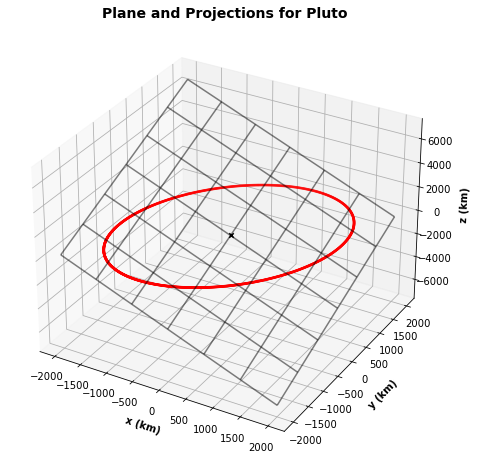

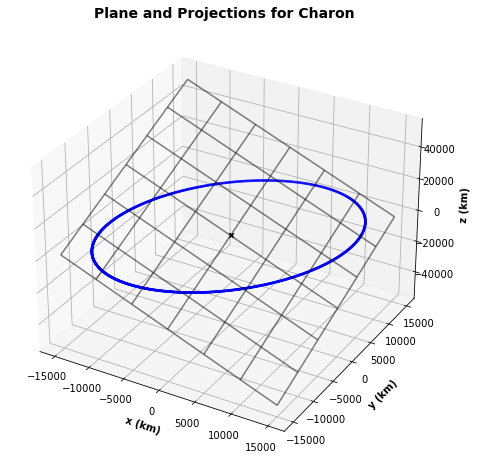

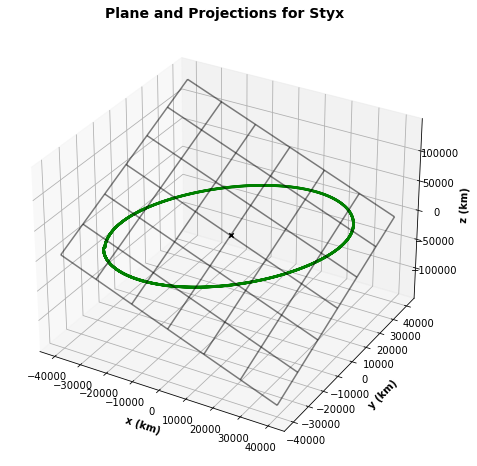

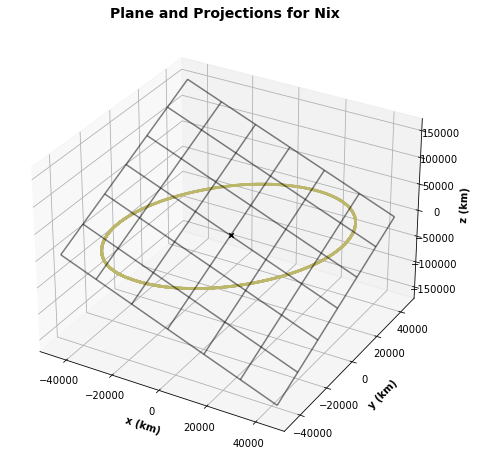

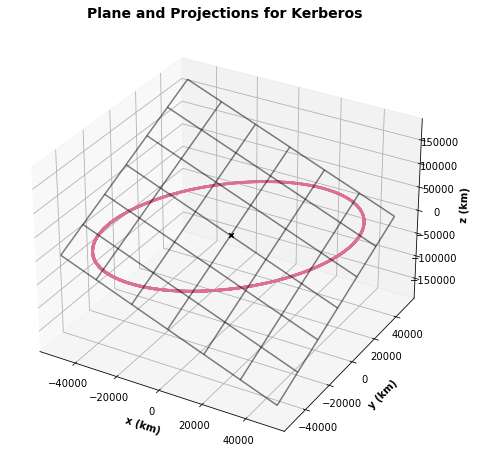

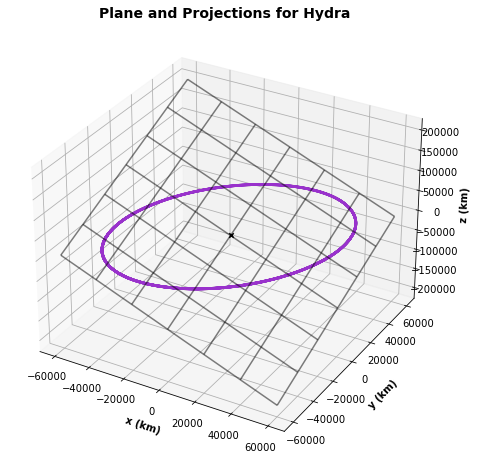

In [12]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calling the function to project the points.
p_pl_r = points_proj(p_r_pl[:,0], p_r_pl[:,1], p_r_pl[:,2], pln_pl, "Pl")
p_ch_r = points_proj(p_r_ch[:,0], p_r_ch[:,1], p_r_ch[:,2], pln_ch, "Ch")
p_st_r = points_proj(p_r_st[:,0], p_r_st[:,1], p_r_st[:,2], pln_st, "St")
p_ni_r = points_proj(p_r_ni[:,0], p_r_ni[:,1], p_r_ni[:,2], pln_ni, "Ni")
p_ke_r = points_proj(p_r_ke[:,0], p_r_ke[:,1], p_r_ke[:,2], pln_ke, "Ke")
p_hy_r = points_proj(p_r_hy[:,0], p_r_hy[:,1], p_r_hy[:,2], pln_hy, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the points in the plane.

#Limits for the grid to represent the plane.
grid_pl = ([-2000, 2000, 7])
grid_ch = ([-15000,15000,7])
grid_st = ([-40000,40000,7])
grid_ni = ([-45000,45000,7])
grid_ke = ([-50000,50000,7])
grid_hy = ([-60000,60000,7])

#The points and planes are plotted.
plot_plane("Pluto",    pln_pl, col_pl, p_pl_r, grid_pl)
plot_plane("Charon",   pln_ch, col_ch, p_ch_r, grid_ch)
plot_plane("Styx",     pln_st, col_st, p_st_r, grid_st)
plot_plane("Nix",      pln_ni, col_ni, p_ni_r, grid_ni)
plot_plane("Kerberos", pln_ke, col_ke, p_ke_r, grid_ke)
plot_plane("Hydra",    pln_hy, col_hy, p_hy_r, grid_hy)


### Fitting Ellipses

##### We generate the 2D Cartesian coordinates for the points in the plane. We can use these coordinates to fit an ellipse to them.

In [13]:
#FUNCIONES:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to convert from polar to Cartesian coordinates.
def points_2d(p_r, title):
    p_2d = np.empty((len(p_r), 2), float)    # The matrix to store the Cartesian coordinates is declared.
    lim = tqdm(range(len(p_r)), desc="2D Points ("+title+") :")
    for i in lim:
        p_2d[i,0], p_2d[i,1] = p_r[i,3]*math.cos(p_r[i,4]), p_r[i,3]*math.sin(p_r[i,4])   # The coordinates are converted.
        
    return p_2d

#-------------------------------------------------------------------------------------------------------------------------------
#Function to obtain the ellipse equation - (Ax^2 + Bxy + Cy^2 + Dx + Ey + F = 0)
def fit_ellipse(p_2d):
    # The initial matrices for the "x" and "y" axes are declared.
    X = np.reshape(p_2d[:,0], (len(p_2d[:,0]), 1))
    Y = np.reshape(p_2d[:,1], (len(p_2d[:,1]), 1))

    # Solving by least squares.
    A = np.hstack([X**2, X * Y, Y**2, X, Y])
    b = np.ones_like(X)
    x = np.linalg.lstsq(A, b)[0].squeeze()      # The constants are stored. They are for the equation of the form:
                                                #        Ax^2 + Bxy + Cy^2 + Dx + Ey = 1
    x = np.append(x, -1)                        # We add "F = -1" at the end of all equations.

    return x


In [14]:
#-------------------------------------------------------------------------------------------------------------------------------
#Generating the 2D points.
pl_2d_r = points_2d(p_pl_r, "Pl")
ch_2d_r = points_2d(p_ch_r, "Ch")
st_2d_r = points_2d(p_st_r, "St")
ni_2d_r = points_2d(p_ni_r, "Ni")
ke_2d_r = points_2d(p_ke_r, "Ke")
hy_2d_r = points_2d(p_hy_r, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Fitting the ellipse

#The constants for each ellipse are obtained.
ell_pl = fit_ellipse(pl_2d_r)
ell_ch = fit_ellipse(ch_2d_r)
ell_st = fit_ellipse(st_2d_r)
ell_ni = fit_ellipse(ni_2d_r)
ell_ke = fit_ellipse(ke_2d_r)
ell_hy = fit_ellipse(hy_2d_r)


2D Points (Pl) ::   0%|          | 0/1840 [00:00<?, ?it/s]

2D Points (Ch) ::   0%|          | 0/1840 [00:00<?, ?it/s]

2D Points (St) ::   0%|          | 0/5807 [00:00<?, ?it/s]

2D Points (Ni) ::   0%|          | 0/7159 [00:00<?, ?it/s]

2D Points (Ke) ::   0%|          | 0/9265 [00:00<?, ?it/s]

2D Points (Hy) ::   0%|          | 0/11002 [00:00<?, ?it/s]

<ipython-input-13-e09e82ee946b>:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()      # The constants are stored. They are for the equation of the form:


ECUACIONES DE ELIPSES DE AJUSTE:
Plutón:   2.2e-07x^2 + 2.1e-12xy+2.2e-07y^2+4.43e-08x+2.26e-08y = 1
Caronte:  3.28e-09x^2 + -4.33e-16xy+3.28e-09y^2+-1.55e-09x+-2.51e-09y = 1
Estigia:  5.54e-10x^2 + -5.77e-12xy+5.6e-10y^2+1.34e-07x+-7.54e-08y = 1
Nix:      4.22e-10x^2 + 7.19e-17xy+4.21e-10y^2+4.75e-08x+3.72e-08y = 1
Cerbero:  3e-10x^2 + -1.26e-13xy+3e-10y^2+9.91e-08x+-7.03e-09y = 1
Hidra:    2.39e-10x^2 + -2.54e-14xy+2.39e-10y^2+-1.56e-07x+1.61e-07y = 1


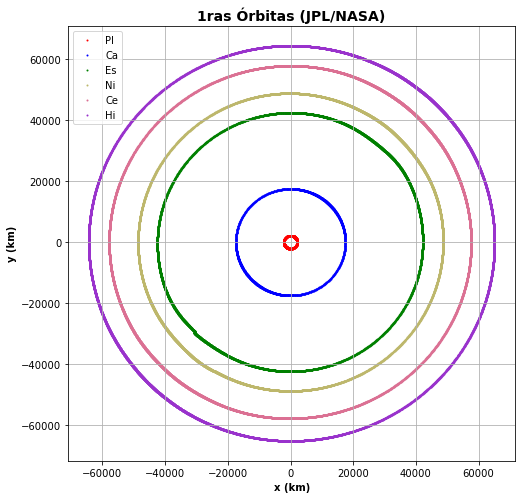

In [11]:
#-------------------------------------------------------------------------------------------------------------------------------
#Printing of each ellipse's equation.
print("EQUATIONS OF FITTED ELLIPSES:")
print('Pluto:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_pl[0], ell_pl[1], ell_pl[2], ell_pl[3], ell_pl[4]))
print('Charon:    {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ch[0], ell_ch[1], ell_ch[2], ell_ch[3], ell_ch[4]))
print('Styx:      {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_st[0], ell_st[1], ell_st[2], ell_st[3], ell_st[4]))
print('Nix:       {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ni[0], ell_ni[1], ell_ni[2], ell_ni[3], ell_ni[4]))
print('Kerberos:  {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ke[0], ell_ke[1], ell_ke[2], ell_ke[3], ell_ke[4]))
print('Hydra:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_hy[0], ell_hy[1], ell_hy[2], ell_hy[3], ell_hy[4]))

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the points in a single graph (approximating all planes as equal).
fig = plt.figure()
plt.scatter(pl_2d_r[:,0], pl_2d_r[:,1], c=col_pl, s=1, label="Pl")
plt.scatter(ch_2d_r[:,0], ch_2d_r[:,1], c=col_ch, s=1, label="Ch")
plt.scatter(st_2d_r[:,0], st_2d_r[:,1], c=col_st, s=1, label="St")
plt.scatter(ni_2d_r[:,0], ni_2d_r[:,1], c=col_ni, s=1, label="Ni")
plt.scatter(ke_2d_r[:,0], ke_2d_r[:,1], c=col_ke, s=1, label="Ke")
plt.scatter(hy_2d_r[:,0], hy_2d_r[:,1], c=col_hy, s=1, label="Hy")
plt.title("1st Orbits (JPL/NASA - Solar System)", fontweight="bold", fontsize=14)
plt.xlabel("x (km)", fontweight="bold")
plt.ylabel("y (km)", fontweight="bold")
plt.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.grid()
plt.xlim([min(hy_2d_r[:,0]) - (abs(min(hy_2d_r[:,0]))/10), max(hy_2d_r[:,0]) + (abs(max(hy_2d_r[:,0]))/10)])
plt.ylim([min(hy_2d_r[:,1]) - (abs(min(hy_2d_r[:,1]))/10), max(hy_2d_r[:,1]) + (abs(max(hy_2d_r[:,1]))/10)])
plt.show()  


### Fitted Ellipses' Parameters

##### Using the constatns of a rotated ellipse, we can get the constants of an ellipse whose axes are aligned with the axes of our coordinate system. Since it is easier to get the parameters of this aligned ellipse, we can get a realtion between our ellipse and its alligned version.

In [15]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to calculate the parameter using the ellipse´s constants.
def param_ellipse(ell):
    theta = (math.atan(ell[1]/(ell[0] - ell[2]))) / 2       # Calculate the angle by which our ellipse is rotated.

    #The constants for the alligned ellipse are calculated.
    A = ell[0]*(math.cos(theta))**2 + ell[1]*math.cos(theta)*math.sin(theta) + ell[2]*(math.sin(theta))**2
    B = 0
    C = ell[0]*(math.sin(theta))**2 - ell[1]*math.cos(theta)*math.sin(theta) + ell[2]*(math.cos(theta))**2
    D = ell[3]*math.cos(theta) + ell[4]*math.sin(theta)
    E = - ell[3]*math.sin(theta) + ell[4]*math.cos(theta)
    F = ell[5]

    #The ellipse´s axes are calculated.
    a = math.sqrt(abs((-4*F*A*C + C*(D**2) + A*(E**2)) / (4*(A**2)*C)))
    b = math.sqrt(abs((-4*F*A*C + C*(D**2) + A*(E**2)) / (4*A*(C**2))))

    #The axes are organized as semi-major and semi-minor.
    if b > a:       # Since we don´t know if the ellipse is alligned with the "x" or "y" axis, we must organize
        aux = b     # them as "a" for the semi-major axis and "b" for the semi-minor axis. This way, the following
        b = a       # calculations will make sense.
        a = aux
        
    c = math.sqrt(a**2 - b**2)        # Calculates the distance from the focus to the center of the ellipse.
    e = math.sqrt(1 - (b**2 / a**2))  # Calculates the eccentricity.
    
    return a, b, c, e

#-------------------------------------------------------------------------------------------------------------------------------
#Function to print the parameters (the initial approximation and the new ones).
def print_param(title, ell_a, ell_b, ell_c, ell_e, a, b, c, e):
    print(title + ':')
    print('Fitted Ellipse: a: ' + str(ell_a) + '   b: ' + str(ell_b) + '   c: ' + str(ell_c) + '   e: ' + str(ell_e))
    print('Init. Approx.:  a: ' + str(a)     + '   b: ' + str(b)     + '   c: ' + str(c)     + '   e: ' + str(e))
    print("")
 

In [16]:
#-------------------------------------------------------------------------------------------------------------------------------
#The parameters for each elliptical orbit are calculated.
ell_pl_a, ell_pl_b, ell_pl_c, ell_pl_e = param_ellipse(ell_pl)
ell_ch_a, ell_ch_b, ell_ch_c, ell_ch_e = param_ellipse(ell_ch)
ell_st_a, ell_st_b, ell_st_c, ell_st_e = param_ellipse(ell_st)
ell_ni_a, ell_ni_b, ell_ni_c, ell_ni_e = param_ellipse(ell_ni)
ell_ke_a, ell_ke_b, ell_ke_c, ell_ke_e = param_ellipse(ell_ke)
ell_hy_a, ell_hy_b, ell_hy_c, ell_hy_e = param_ellipse(ell_hy)

#-------------------------------------------------------------------------------------------------------------------------------
#Printing the parameters (initial approximation and new ones).
print("ELLIPTIC TRAJECTORIES' PARAMETERS:")
print("")
print_param("Pluto",    ell_pl_a, ell_pl_b, ell_pl_c, ell_pl_e, pl_a, pl_b, pl_c, pl_e)
print_param("Charon",   ell_ch_a, ell_ch_b, ell_ch_c, ell_ch_e, ch_a, ch_b, ch_c, ch_e)
print_param("Styx",     ell_st_a, ell_st_b, ell_st_c, ell_st_e, st_a, st_b, st_c, st_e)
print_param("Nix",      ell_ni_a, ell_ni_b, ell_ni_c, ell_ni_e, ni_a, ni_b, ni_c, ni_e)
print_param("Kerberos", ell_ke_a, ell_ke_b, ell_ke_c, ell_ke_e, ke_a, ke_b, ke_c, ke_e)
print_param("Hydra",    ell_hy_a, ell_hy_b, ell_hy_c, ell_hy_e, hy_a, hy_b, hy_c, hy_e)


ELLIPTIC TRAJECTORIES' PARAMETERS:

Pluto:
Fitted Ellipse: a: 2131.9525780085874   b: 2131.940437660205   c: 7.194799974670571   e: 0.0033747467222745835
Init. Approx.:  a: 2131.9408592914556   b: 2131.94083644517   c: 0.3121119313245799   e: 0.00014639802505042726

Charon:
Fitted Ellipse: a: 17468.581965802936   b: 17468.56914863113   c: 21.161178328977304   e: 0.0012113850094195445
Init. Approx.:  a: 17468.574349620183   b: 17468.574331725413   c: 0.7906909812809317   e: 4.5263624005935184e-05

Styx:
Fitted Ellipse: a: 42525.54676510705   b: 42227.7681092794   c: 5023.716570451829   e: 0.11813408533465049
Init. Approx.:  a: 42502.97430245357   b: 42501.51162311407   c: 352.61069939588924   e: 0.008296141744968047

Nix:
Fitted Ellipse: a: 48709.67732808953   b: 48690.25614758018   c: 1375.3623848388304   e: 0.028235916562841194
Init. Approx.:  a: 48736.291719855595   b: 48735.86834682329   c: 203.14301359636738   e: 0.004168208257699778

Kerberos:
Fitted Ellipse: a: 57764.274722268645

### Angular Momentum Conservation

##### We calculate the linear momentum, and with it the angular momentum, for each coordinate of the data. This was useful later on to obtain the orbital parameter on a Kepler´s Problem. However, and more importantly, it showed us that it stays relatively constant during each bosy´s movement.

In [17]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to get the average.
def avg(arr):
    return sum(arr)/len(arr)

#-------------------------------------------------------------------------------------------------------------------------------
#Function to obtain the componentes and magnitude of the angular momentum.
def momentum(xs, ys, zs, vx, vy, vz, m, title):
    p = np.empty((len(xs), 3), float)    # Linear momentum matrix.
    Lt = np.empty((len(xs)), float)      # Angular momentum array.
    
    lim = tqdm(range(len(xs)), desc=title+"'s Momentum : ")
    for i in lim:    # The linear and angular momentum at each point are calculated.
        p[i,0], p[i,1], p[i,2] = m*vx[i], m*vy[i], m*vz[i]     # Linear momentum calculation.
        
        Lx = ys[i]*p[i,2] - zs[i]*p[i,1]    # Angular momentum calculation.
        Ly = zs[i]*p[i,0] - xs[i]*p[i,2]
        Lz = xs[i]*p[i,1] - ys[i]*p[i,0]

        Lt[i] = mag(Lx, Ly, Lz)  # Angular momentum magnitude.
        
    return Lt

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot the angular momentum for each coordinate for each body.
def plot_L(title, L, color, aver):
    fig = plt.figure()
    plt.scatter(range(len(L)), L, c=color, s=1, label="|L|")
    plt.title("|L| - " + title + " (avg.: " + str(aver) + ")\n", fontweight="bold")
    plt.xlabel("Coordinate Index", fontweight="bold")
    plt.ylabel("|L| (kg km^2 / s)", fontweight="bold")
    plt.legend(loc='upper left')
    plt.grid()
    plt.ylim([min(L) - (min(L)/10), max(L) + (max(L)/10)])   # Keeps the plor limits at 10% up and down of its values.
    plt.show()


In [18]:
#-------------------------------------------------------------------------------------------------------------------------------
#We obtain the angular momentum for each body.
pl_L = momentum(pl_r[:,0], pl_r[:,1], pl_r[:,2], pl_v[:,0], pl_v[:,1], pl_v[:,2], pl_m, "Pl")
ch_L = momentum(ch_r[:,0], ch_r[:,1], ch_r[:,2], ch_v[:,0], ch_v[:,1], ch_v[:,2], ch_m, "Ch")
st_L = momentum(st_r[:,0], st_r[:,1], st_r[:,2], st_v[:,0], st_v[:,1], st_v[:,2], st_m, "St")
ni_L = momentum(ni_r[:,0], ni_r[:,1], ni_r[:,2], ni_v[:,0], ni_v[:,1], ni_v[:,2], ni_m, "Ni")
ke_L = momentum(ke_r[:,0], ke_r[:,1], ke_r[:,2], ke_v[:,0], ke_v[:,1], ke_v[:,2], ke_m, "Ke")
hy_L = momentum(hy_r[:,0], hy_r[:,1], hy_r[:,2], hy_v[:,0], hy_v[:,1], hy_v[:,2], hy_m, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Total angular momentum of the PLS.
L_t = np.empty((len(pl_L)), float)    # Array to store the PLS total angular momentum.
for i in range(len(pl_L)):
    L_t[i] = pl_L[i] + ch_L[i] + st_L[i] + ni_L[i] + ke_L[i] + hy_L[i]     # Everybody´s momentum is added together..

#-------------------------------------------------------------------------------------------------------------------------------
#Average of the angular momentum for all bodies.
aver_L_pl = avg(pl_L)
aver_L_ch = avg(ch_L)
aver_L_st = avg(st_L)
aver_L_ni = avg(ni_L)
aver_L_ke = avg(ke_L)
aver_L_hy = avg(hy_L)
aver_L_t  = avg(L_t)


Pl's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

Ch's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

St's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

Ni's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

Ke's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

Hy's Momentum :   0%|          | 0/34561 [00:00<?, ?it/s]

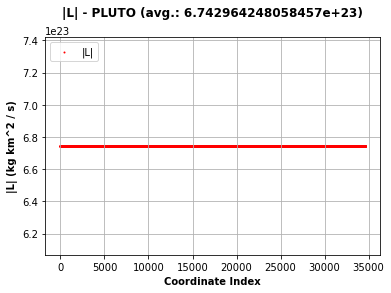

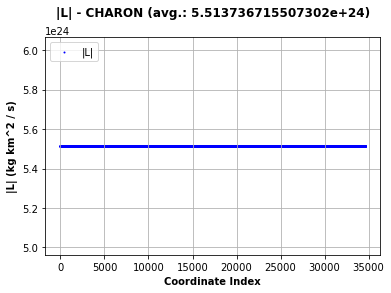

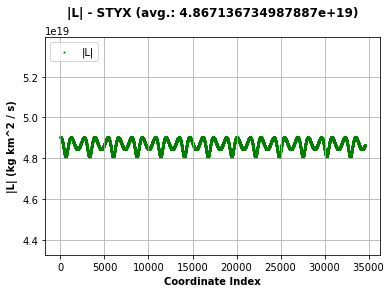

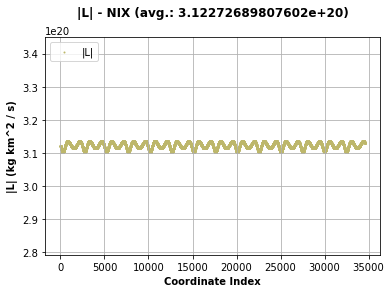

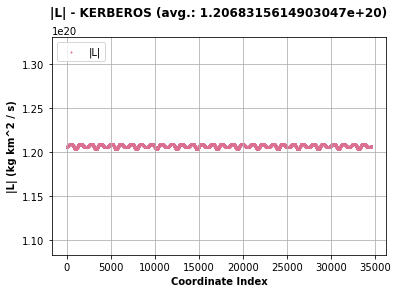

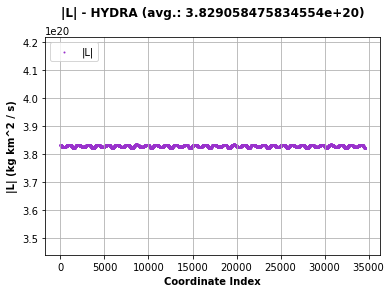

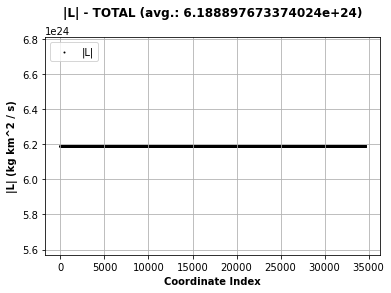

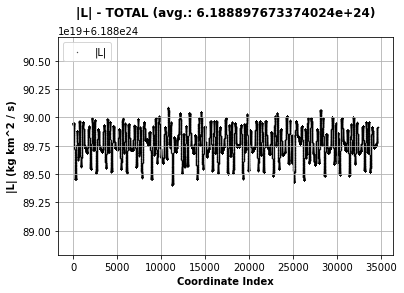

In [19]:
#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#Ploting to analyze if the angular momentu is conserved.
plot_L("PLUTO",    pl_L, col_pl, aver_L_pl)
plot_L("CHARON",   ch_L, col_ch, aver_L_ch)
plot_L("STYX",     st_L, col_st, aver_L_st)
plot_L("NIX",      ni_L, col_ni, aver_L_ni)
plot_L("KERBEROS", ke_L, col_ke, aver_L_ke)
plot_L("HYDRA",    hy_L, col_hy, aver_L_hy)
plot_L("TOTAL",    L_t, "black", aver_L_t)

#Plotting a zoom to the total angular momentum to appreciate variation.
fig = plt.figure()
plt.scatter(range(len(L_t)), L_t, c="black", s=0.1, label="|L|")
plt.title("|L| - TOTAL (avg.: " + str(aver_L_t) + ")\n", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("|L| (kg km^2 / s)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(L_t) - (min(L_t)/1000000), max(L_t) + (max(L_t)/1000000)])  # Scaling for a zoom to appreciate variation.
plt.show()                                                                


## Model 5: 8-Body Problem

##### As we did in model 2 (6BP), every body feels the interaction with all other bodies. However, now the Sun's interaction and Jupiter's interaction (to better approximate the Sun's position) are considered. This way, even when plotting the coordinates from the PLS's barycenter system, all the non-inertial effects are taken into account. Lastly, the symplectic version of 4th order Runge-Kutta is used.

### Generating the Data - 8-Body Problem

##### We use a single acceleration function with the symplectic 4th order Runge-Kutta mehtod (RKS) to generate the velocities. Then we used it again to obtain the positions.

In [80]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to obtain the position vector magnitude.
def radii(xs, ys, zs, title):
    rs = np.empty((len(xs)), float)   # Declaring the array to store the radii.
    lim = tqdm(range(len(xs)), desc=title+"'s Radii :")
    for i in lim:
        rs[i] = math.sqrt(xs[i]**2 + ys[i]**2 + zs[i]**2)    # Calculates the magnitude for each point.
    return rs

#-------------------------------------------------------------------------------------------------------------------------------
#Function to get the approximated parameters of the elliptic trajectories.
def param_RKS(r):
    a = (max(r) + min(r)) / 2    # Obtaining an approximation of the major axis and dividing it in 2.
    c = max(r) - a               # Substracting "a" from the major radius (approx. of the vertix-focus distance).
    b = math.sqrt(a**2 - c**2)   # Calculating "c" with Pythagoras' theorem.
    e = c / a                    # Calculating the eccentricity.
    return a, b, c, e

#-------------------------------------------------------------------------------------------------------------------------------
#Acceleration equation (8-body problem).
def func_8BP(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8, m2, m3, m4, m5, m6, m7, m8): 
    d12 = mag((x2 - x1), (y2 - y1), (z2 - z1))
    d13 = mag((x3 - x1), (y3 - y1), (z3 - z1))   # Distances between bodies.
    d14 = mag((x4 - x1), (y4 - y1), (z4 - z1))
    d15 = mag((x5 - x1), (y5 - y1), (z5 - z1))
    d16 = mag((x6 - x1), (y6 - y1), (z6 - z1))
    d17 = mag((x7 - x1), (y7 - y1), (z7 - z1))
    d18 = mag((x8 - x1), (y8 - y1), (z8 - z1))

    ax = (((G*m2) / (d12**3))*(x2 - x1)) + (((G*m3) / (d13**3))*(x3 - x1)) + (((G*m4) / (d14**3))*(x4 - x1)) + (((G*m5) / (d15**3))*(x5 - x1)) + (((G*m6) / (d16**3))*(x6 - x1)) + (((G*m7) / (d17**3))*(x7 - x1)) + (((G*m8) / (d18**3))*(x8 - x1))
    ay = (((G*m2) / (d12**3))*(y2 - y1)) + (((G*m3) / (d13**3))*(y3 - y1)) + (((G*m4) / (d14**3))*(y4 - y1)) + (((G*m5) / (d15**3))*(y5 - y1)) + (((G*m6) / (d16**3))*(y6 - y1)) + (((G*m7) / (d17**3))*(y7 - y1)) + (((G*m8) / (d18**3))*(y8 - y1))
    az = (((G*m2) / (d12**3))*(z2 - z1)) + (((G*m3) / (d13**3))*(z3 - z1)) + (((G*m4) / (d14**3))*(z4 - z1)) + (((G*m5) / (d15**3))*(z5 - z1)) + (((G*m6) / (d16**3))*(z6 - z1)) + (((G*m7) / (d17**3))*(z7 - z1)) + (((G*m8) / (d18**3))*(z8 - z1))
    
    return ax, ay, az

#-------------------------------------------------------------------------------------------------------------------------------
#Function to obtain the points to plot.
def points_plot(h, T, xs, ys, zs, title):
    k = math.floor(len(xs)/T)         # Amount of data in one of the T partitions.
    r_g = np.empty((T, 3), float)
    lim = tqdm(range(T), desc="Points to Plot ("+title+"): ")
    for i in lim: 
        r_g[i,0], r_g[i,1], r_g[i,2] = xs[i*k], ys[i*k], zs[i*k]      # Storing every 1000 points to plot.
            
    return r_g

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot each trajectory individually.
def plot_orbit(title, xs, ys, zs, color, lbl):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title+"'s Trajectory", fontweight="bold", fontsize=14)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.scatter(xs, ys, zs, marker="x", c=color, s=1, label=lbl);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    fig.set_size_inches(8, 8)
    plt.show()


In [23]:
#-------------------------------------------------------------------------------------------------------------------------------
#Universal Gravitational Constant (days).
G = 4.982174e-10  #(km^3 / kg d^2) 

#-------------------------------------------------------------------------------------------------------------------------------
#Setting the step "h".

N = 1000000      # No. of iterations.
a = 0            # Initial time = 0.
b = 40           # No. of days.

h_RKS = (b-a)/N   # Step "h".

t_RKS = np.empty((N+1), float)    #Array to store time values.
t_RKS[0] = a

#-------------------------------------------------------------------------------------------------------------------------------
#Declaring position and velocity arrays en each axis.

#Coordinates from the PLS's barycenter reference system.
pl_x_RKS, pl_y_RKS, pl_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_x_RKS, ch_y_RKS, ch_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_x_RKS, st_y_RKS, st_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_x_RKS, ni_y_RKS, ni_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_x_RKS, ke_y_RKS, ke_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_x_RKS, hy_y_RKS, hy_z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

#Coordinates and velocities from the solar system's barycenter reference system.
pl_X_RKS, pl_Y_RKS, pl_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_X_RKS, ch_Y_RKS, ch_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_X_RKS, st_Y_RKS, st_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_X_RKS, ni_Y_RKS, ni_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_X_RKS, ke_Y_RKS, ke_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_X_RKS, hy_Y_RKS, hy_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
sun_X_RKS, sun_Y_RKS, sun_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
jup_X_RKS, jup_Y_RKS, jup_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
bary_X_RKS, bary_Y_RKS, bary_Z_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

pl_VX_RKS, pl_VY_RKS, pl_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_VX_RKS, ch_VY_RKS, ch_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_VX_RKS, st_VY_RKS, st_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_VX_RKS, ni_VY_RKS, ni_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_VX_RKS, ke_VY_RKS, ke_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_VX_RKS, hy_VY_RKS, hy_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
sun_VX_RKS, sun_VY_RKS, sun_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
jup_VX_RKS, jup_VY_RKS, jup_VZ_RKS = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

#-------------------------------------------------------------------------------------------------------------------------------
#Initial Conditions (00:00:00 1/Ene/2021).

#Initial positions (solar system's barycenter reference system).
pl_X_RKS[0], pl_Y_RKS[0], pl_Z_RKS[0] = pl_R[0,0], pl_R[0,1], pl_R[0,2]
ch_X_RKS[0], ch_Y_RKS[0], ch_Z_RKS[0] = ch_R[0,0], ch_R[0,1], ch_R[0,2]
st_X_RKS[0], st_Y_RKS[0], st_Z_RKS[0] = st_R[0,0], st_R[0,1], st_R[0,2]
ni_X_RKS[0], ni_Y_RKS[0], ni_Z_RKS[0] = ni_R[0,0], ni_R[0,1], ni_R[0,2]
ke_X_RKS[0], ke_Y_RKS[0], ke_Z_RKS[0] = ke_R[0,0], ke_R[0,1], ke_R[0,2]
hy_X_RKS[0], hy_Y_RKS[0], hy_Z_RKS[0] = hy_R[0,0], hy_R[0,1], hy_R[0,2]
sun_X_RKS[0], sun_Y_RKS[0], sun_Z_RKS[0] = sun_R[0,0], sun_R[0,1], sun_R[0,2]
jup_X_RKS[0], jup_Y_RKS[0], jup_Z_RKS[0] = jup_R[0,0], jup_R[0,1], jup_R[0,2]
bary_X_RKS[0], bary_Y_RKS[0], bary_Z_RKS[0] = bary_R[0,0], bary_R[0,1], bary_R[0,2]

#Initial positions (PLS's barycenter reference system).
pl_x_RKS[0], pl_y_RKS[0], pl_z_RKS[0] = pl_R[0,0] - bary_R[0,0], pl_R[0,1] - bary_R[0,1], pl_R[0,2] - bary_R[0,2]
ch_x_RKS[0], ch_y_RKS[0], ch_z_RKS[0] = ch_R[0,0] - bary_R[0,0], ch_R[0,1] - bary_R[0,1], ch_R[0,2] - bary_R[0,2]
st_x_RKS[0], st_y_RKS[0], st_z_RKS[0] = st_R[0,0] - bary_R[0,0], st_R[0,1] - bary_R[0,1], st_R[0,2] - bary_R[0,2]
ni_x_RKS[0], ni_y_RKS[0], ni_z_RKS[0] = ni_R[0,0] - bary_R[0,0], ni_R[0,1] - bary_R[0,1], ni_R[0,2] - bary_R[0,2]
ke_x_RKS[0], ke_y_RKS[0], ke_z_RKS[0] = ke_R[0,0] - bary_R[0,0], ke_R[0,1] - bary_R[0,1], ke_R[0,2] - bary_R[0,2]
hy_x_RKS[0], hy_y_RKS[0], hy_z_RKS[0] = hy_R[0,0] - bary_R[0,0], hy_R[0,1] - bary_R[0,1], hy_R[0,2] - bary_R[0,2]

#Initial velocities.
n = 86400   # Converting from sec. to days.

pl_VX_RKS[0], pl_VY_RKS[0], pl_VZ_RKS[0] = n*pl_V[0,0], n*pl_V[0,1], n*pl_V[0,2]
ch_VX_RKS[0], ch_VY_RKS[0], ch_VZ_RKS[0] = n*ch_V[0,0], n*ch_V[0,1], n*ch_V[0,2]
st_VX_RKS[0], st_VY_RKS[0], st_VZ_RKS[0] = n*st_V[0,0], n*st_V[0,1], n*st_V[0,2]
ni_VX_RKS[0], ni_VY_RKS[0], ni_VZ_RKS[0] = n*ni_V[0,0], n*ni_V[0,1], n*ni_V[0,2]
ke_VX_RKS[0], ke_VY_RKS[0], ke_VZ_RKS[0] = n*ke_V[0,0], n*ke_V[0,1], n*ke_V[0,2]
hy_VX_RKS[0], hy_VY_RKS[0], hy_VZ_RKS[0] = n*hy_V[0,0], n*hy_V[0,1], n*hy_V[0,2]
sun_VX_RKS[0], sun_VY_RKS[0], sun_VZ_RKS[0] = n*sun_V[0,0], n*sun_V[0,1], n*sun_V[0,2]
jup_VX_RKS[0], jup_VY_RKS[0], jup_VZ_RKS[0] = n*jup_V[0,0], n*jup_V[0,1], n*jup_V[0,2]

#-------------------------------------------------------------------------------------------------------------------------------
#RKS Loop.
lim = tqdm(range(int(N)), desc="RKS Loop: ")
for i in lim:
    
    #POSITIONS:
    
    #Pluto.
    
    # Generating the "k" constants for the velocity.
    k1x, k1y, k1z = func_8BP(pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(pl_X_RKS[i] + k1x/2, pl_Y_RKS[i] + k1y/2, pl_Z_RKS[i] + k1z/2, ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(pl_X_RKS[i] + k2x/2, pl_Y_RKS[i] + k2y/2, pl_Z_RKS[i] + k2z/2, ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(pl_X_RKS[i] + k3x, pl_Y_RKS[i] + k3y, pl_Z_RKS[i] + k3z, ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    # Generating the next value for the velocity.
    pl_VX_RKS[i+1] = pl_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_VY_RKS[i+1] = pl_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_VZ_RKS[i+1] = pl_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    # Generating the "k" constants for the position.
    k1x, k1y, k1z = h_RKS*pl_VX_RKS[i], h_RKS*pl_VY_RKS[i], h_RKS*pl_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(pl_VX_RKS[i] + k1x/2), h_RKS*(pl_VY_RKS[i] + k1y/2), h_RKS*(pl_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(pl_VX_RKS[i] + k2x/2), h_RKS*(pl_VY_RKS[i] + k2y/2), h_RKS*(pl_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(pl_VX_RKS[i] + k3x), h_RKS*(pl_VY_RKS[i] + k3y), h_RKS*(pl_VZ_RKS[i] + k3z)

    # Generating the next value for the position.
    pl_X_RKS[i+1] = pl_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_Y_RKS[i+1] = pl_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_Z_RKS[i+1] = pl_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Charon.
    k1x, k1y, k1z = func_8BP(ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ch_X_RKS[i] + k1x/2, ch_Y_RKS[i] + k1y/2, ch_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ch_X_RKS[i] + k2x/2, ch_Y_RKS[i] + k2y/2, ch_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ch_X_RKS[i] + k3x, ch_Y_RKS[i] + k3y, ch_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ch_VX_RKS[i+1] = ch_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_VY_RKS[i+1] = ch_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_VZ_RKS[i+1] = ch_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*ch_VX_RKS[i], h_RKS*ch_VY_RKS[i], h_RKS*ch_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(ch_VX_RKS[i] + k1x/2), h_RKS*(ch_VY_RKS[i] + k1y/2), h_RKS*(ch_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(ch_VX_RKS[i] + k2x/2), h_RKS*(ch_VY_RKS[i] + k2y/2), h_RKS*(ch_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(ch_VX_RKS[i] + k3x), h_RKS*(ch_VY_RKS[i] + k3y), h_RKS*(ch_VZ_RKS[i] + k3z)

    ch_X_RKS[i+1] = ch_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_Y_RKS[i+1] = ch_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_Z_RKS[i+1] = ch_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Styx.
    k1x, k1y, k1z = func_8BP(st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(st_X_RKS[i] + k1x/2, st_Y_RKS[i] + k1y/2, st_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(st_X_RKS[i] + k2x/2, st_Y_RKS[i] + k2y/2, st_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(st_X_RKS[i] + k3x, st_Y_RKS[i] + k3y, st_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    st_VX_RKS[i+1] = st_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_VY_RKS[i+1] = st_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_VZ_RKS[i+1] = st_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*st_VX_RKS[i], h_RKS*st_VY_RKS[i], h_RKS*st_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(st_VX_RKS[i] + k1x/2), h_RKS*(st_VY_RKS[i] + k1y/2), h_RKS*(st_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(st_VX_RKS[i] + k2x/2), h_RKS*(st_VY_RKS[i] + k2y/2), h_RKS*(st_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(st_VX_RKS[i] + k3x), h_RKS*(st_VY_RKS[i] + k3y), h_RKS*(st_VZ_RKS[i] + k3z)

    st_X_RKS[i+1] = st_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_Y_RKS[i+1] = st_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_Z_RKS[i+1] = st_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Nix.
    k1x, k1y, k1z = func_8BP(ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ni_X_RKS[i] + k1x/2, ni_Y_RKS[i] + k1y/2, ni_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ni_X_RKS[i] + k2x/2, ni_Y_RKS[i] + k2y/2, ni_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ni_X_RKS[i] + k3x, ni_Y_RKS[i] + k3y, ni_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ni_VX_RKS[i+1] = ni_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_VY_RKS[i+1] = ni_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_VZ_RKS[i+1] = ni_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*ni_VX_RKS[i], h_RKS*ni_VY_RKS[i], h_RKS*ni_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(ni_VX_RKS[i] + k1x/2), h_RKS*(ni_VY_RKS[i] + k1y/2), h_RKS*(ni_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(ni_VX_RKS[i] + k2x/2), h_RKS*(ni_VY_RKS[i] + k2y/2), h_RKS*(ni_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(ni_VX_RKS[i] + k3x), h_RKS*(ni_VY_RKS[i] + k3y), h_RKS*(ni_VZ_RKS[i] + k3z)

    ni_X_RKS[i+1] = ni_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_Y_RKS[i+1] = ni_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_Z_RKS[i+1] = ni_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Kerberos.
    k1x, k1y, k1z = func_8BP(ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ke_X_RKS[i] + k1x/2, ke_Y_RKS[i] + k1y/2, ke_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ke_X_RKS[i] + k2x/2, ke_Y_RKS[i] + k2y/2, ke_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ke_X_RKS[i] + k3x, ke_Y_RKS[i] + k3y, ke_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ke_VX_RKS[i+1] = ke_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_VY_RKS[i+1] = ke_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_VZ_RKS[i+1] = ke_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*ke_VX_RKS[i], h_RKS*ke_VY_RKS[i], h_RKS*ke_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(ke_VX_RKS[i] + k1x/2), h_RKS*(ke_VY_RKS[i] + k1y/2), h_RKS*(ke_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(ke_VX_RKS[i] + k2x/2), h_RKS*(ke_VY_RKS[i] + k2y/2), h_RKS*(ke_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(ke_VX_RKS[i] + k3x), h_RKS*(ke_VY_RKS[i] + k3y), h_RKS*(ke_VZ_RKS[i] + k3z)

    ke_X_RKS[i+1] = ke_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_Y_RKS[i+1] = ke_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_Z_RKS[i+1] = ke_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Hydra.
    k1x, k1y, k1z = func_8BP(hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(hy_X_RKS[i] + k1x/2, hy_Y_RKS[i] + k1y/2, hy_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(hy_X_RKS[i] + k2x/2, hy_Y_RKS[i] + k2y/2, hy_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(hy_X_RKS[i] + k3x, hy_Y_RKS[i] + k3y, hy_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    hy_VX_RKS[i+1] = hy_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_VY_RKS[i+1] = hy_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_VZ_RKS[i+1] = hy_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*hy_VX_RKS[i], h_RKS*hy_VY_RKS[i], h_RKS*hy_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(hy_VX_RKS[i] + k1x/2), h_RKS*(hy_VY_RKS[i] + k1y/2), h_RKS*(hy_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(hy_VX_RKS[i] + k2x/2), h_RKS*(hy_VY_RKS[i] + k2y/2), h_RKS*(hy_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(hy_VX_RKS[i] + k3x), h_RKS*(hy_VY_RKS[i] + k3y), h_RKS*(hy_VZ_RKS[i] + k3z)

    hy_X_RKS[i+1] = hy_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_Y_RKS[i+1] = hy_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_Z_RKS[i+1] = hy_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Sun.
    k1x, k1y, k1z = func_8BP(sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(sun_X_RKS[i] + k1x/2, sun_Y_RKS[i] + k1y/2, sun_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(sun_X_RKS[i] + k2x/2, sun_Y_RKS[i] + k2y/2, sun_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(sun_X_RKS[i] + k3x, sun_Y_RKS[i] + k3y, sun_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    sun_VX_RKS[i+1] = sun_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_VY_RKS[i+1] = sun_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_VZ_RKS[i+1] = sun_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*sun_VX_RKS[i], h_RKS*sun_VY_RKS[i], h_RKS*sun_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(sun_VX_RKS[i] + k1x/2), h_RKS*(sun_VY_RKS[i] + k1y/2), h_RKS*(sun_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(sun_VX_RKS[i] + k2x/2), h_RKS*(sun_VY_RKS[i] + k2y/2), h_RKS*(sun_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(sun_VX_RKS[i] + k3x), h_RKS*(sun_VY_RKS[i] + k3y), h_RKS*(sun_VZ_RKS[i] + k3z)

    sun_X_RKS[i+1] = sun_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_Y_RKS[i+1] = sun_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_Z_RKS[i+1] = sun_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Jupiter.
    k1x, k1y, k1z = func_8BP(jup_X_RKS[i], jup_Y_RKS[i], jup_Z_RKS[i], pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(jup_X_RKS[i] + k1x/2, jup_Y_RKS[i] + k1y/2, jup_Z_RKS[i] + k1z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(jup_X_RKS[i] + k2x/2, jup_Y_RKS[i] + k2y/2, jup_Z_RKS[i] + k2z/2, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(jup_X_RKS[i] + k3x, jup_Y_RKS[i] + k3y, jup_Z_RKS[i] + k3z, pl_X_RKS[i], pl_Y_RKS[i], pl_Z_RKS[i], ch_X_RKS[i], ch_Y_RKS[i], ch_Z_RKS[i], st_X_RKS[i], st_Y_RKS[i], st_Z_RKS[i], ni_X_RKS[i], ni_Y_RKS[i], ni_Z_RKS[i], ke_X_RKS[i], ke_Y_RKS[i], ke_Z_RKS[i], hy_X_RKS[i], hy_Y_RKS[i], hy_Z_RKS[i], sun_X_RKS[i], sun_Y_RKS[i], sun_Z_RKS[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    jup_VX_RKS[i+1] = jup_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_VY_RKS[i+1] = jup_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_VZ_RKS[i+1] = jup_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS*jup_VX_RKS[i], h_RKS*jup_VY_RKS[i], h_RKS*jup_VZ_RKS[i]
    k2x, k2y, k2z = h_RKS*(jup_VX_RKS[i] + k1x/2), h_RKS*(jup_VY_RKS[i] + k1y/2), h_RKS*(jup_VZ_RKS[i] + k1z/2)
    k3x, k3y, k3z = h_RKS*(jup_VX_RKS[i] + k2x/2), h_RKS*(jup_VY_RKS[i] + k2y/2), h_RKS*(jup_VZ_RKS[i] + k2z/2)
    k4x, k4y, k4z = h_RKS*(jup_VX_RKS[i] + k3x), h_RKS*(jup_VY_RKS[i] + k3y), h_RKS*(jup_VZ_RKS[i] + k3z)

    jup_X_RKS[i+1] = jup_X_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_Y_RKS[i+1] = jup_Y_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_Z_RKS[i+1] = jup_Z_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    
    #VELOCITIES:
    
    #Pluto.
    
    # Generating the "k" constants for the velocity.
    k1x, k1y, k1z = func_8BP(pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(pl_X_RKS[i+1] + k1x/2, pl_Y_RKS[i+1] + k1y/2, pl_Z_RKS[i+1] + k1z/2, ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(pl_X_RKS[i+1] + k2x/2, pl_Y_RKS[i+1] + k2y/2, pl_Z_RKS[i+1] + k2z/2, ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(pl_X_RKS[i+1] + k3x, pl_Y_RKS[i+1] + k3y, pl_Z_RKS[i+1] + k3z, ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    # Generating the next value for the velocity (update).
    pl_VX_RKS[i+1] = pl_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_VY_RKS[i+1] = pl_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_VZ_RKS[i+1] = pl_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Charon.
    k1x, k1y, k1z = func_8BP(ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ch_X_RKS[i+1] + k1x/2, ch_Y_RKS[i+1] + k1y/2, ch_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ch_X_RKS[i+1] + k2x/2, ch_Y_RKS[i+1] + k2y/2, ch_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ch_X_RKS[i+1] + k3x, ch_Y_RKS[i+1] + k3y, ch_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ch_VX_RKS[i+1] = ch_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_VY_RKS[i+1] = ch_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_VZ_RKS[i+1] = ch_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Styx.
    k1x, k1y, k1z = func_8BP(st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(st_X_RKS[i+1] + k1x/2, st_Y_RKS[i+1] + k1y/2, st_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(st_X_RKS[i+1] + k2x/2, st_Y_RKS[i+1] + k2y/2, st_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(st_X_RKS[i+1] + k3x, st_Y_RKS[i+1] + k3y, st_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    st_VX_RKS[i+1] = st_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_VY_RKS[i+1] = st_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_VZ_RKS[i+1] = st_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Nix.
    k1x, k1y, k1z = func_8BP(ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ni_X_RKS[i+1] + k1x/2, ni_Y_RKS[i+1] + k1y/2, ni_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ni_X_RKS[i+1] + k2x/2, ni_Y_RKS[i+1] + k2y/2, ni_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ni_X_RKS[i+1] + k3x, ni_Y_RKS[i+1] + k3y, ni_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ni_VX_RKS[i+1] = ni_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_VY_RKS[i+1] = ni_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_VZ_RKS[i+1] = ni_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Kerberos.
    k1x, k1y, k1z = func_8BP(ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(ke_X_RKS[i+1] + k1x/2, ke_Y_RKS[i+1] + k1y/2, ke_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(ke_X_RKS[i+1] + k2x/2, ke_Y_RKS[i+1] + k2y/2, ke_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(ke_X_RKS[i+1] + k3x, ke_Y_RKS[i+1] + k3y, ke_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    ke_VX_RKS[i+1] = ke_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_VY_RKS[i+1] = ke_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_VZ_RKS[i+1] = ke_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Hydra.
    k1x, k1y, k1z = func_8BP(hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(hy_X_RKS[i+1] + k1x/2, hy_Y_RKS[i+1] + k1y/2, hy_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(hy_X_RKS[i+1] + k2x/2, hy_Y_RKS[i+1] + k2y/2, hy_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(hy_X_RKS[i+1] + k3x, hy_Y_RKS[i+1] + k3y, hy_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    hy_VX_RKS[i+1] = hy_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_VY_RKS[i+1] = hy_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_VZ_RKS[i+1] = hy_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Sun.
    k1x, k1y, k1z = func_8BP(sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(sun_X_RKS[i+1] + k1x/2, sun_Y_RKS[i+1] + k1y/2, sun_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(sun_X_RKS[i+1] + k2x/2, sun_Y_RKS[i+1] + k2y/2, sun_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(sun_X_RKS[i+1] + k3x, sun_Y_RKS[i+1] + k3y, sun_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    sun_VX_RKS[i+1] = sun_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_VY_RKS[i+1] = sun_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_VZ_RKS[i+1] = sun_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Jupiter.
    k1x, k1y, k1z = func_8BP(jup_X_RKS[i+1], jup_Y_RKS[i+1], jup_Z_RKS[i+1], pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k1x, k1y, k1z = h_RKS*k1x, h_RKS*k1y, h_RKS*k1z
    k2x, k2y, k2z = func_8BP(jup_X_RKS[i+1] + k1x/2, jup_Y_RKS[i+1] + k1y/2, jup_Z_RKS[i+1] + k1z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k2x, k2y, k2z = h_RKS*k2x, h_RKS*k2y, h_RKS*k2z
    k3x, k3y, k3z = func_8BP(jup_X_RKS[i+1] + k2x/2, jup_Y_RKS[i+1] + k2y/2, jup_Z_RKS[i+1] + k2z/2, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k3x, k3y, k3z = h_RKS*k3x, h_RKS*k3y, h_RKS*k3z
    k4x, k4y, k4z = func_8BP(jup_X_RKS[i+1] + k3x, jup_Y_RKS[i+1] + k3y, jup_Z_RKS[i+1] + k3z, pl_X_RKS[i+1], pl_Y_RKS[i+1], pl_Z_RKS[i+1], ch_X_RKS[i+1], ch_Y_RKS[i+1], ch_Z_RKS[i+1], st_X_RKS[i+1], st_Y_RKS[i+1], st_Z_RKS[i+1], ni_X_RKS[i+1], ni_Y_RKS[i+1], ni_Z_RKS[i+1], ke_X_RKS[i+1], ke_Y_RKS[i+1], ke_Z_RKS[i+1], hy_X_RKS[i+1], hy_Y_RKS[i+1], hy_Z_RKS[i+1], sun_X_RKS[i+1], sun_Y_RKS[i+1], sun_Z_RKS[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m)
    k4x, k4y, k4z = h_RKS*k4x, h_RKS*k4y, h_RKS*k4z
    
    jup_VX_RKS[i+1] = jup_VX_RKS[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_VY_RKS[i+1] = jup_VY_RKS[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_VZ_RKS[i+1] = jup_VZ_RKS[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Barycenter position.
    bary_X_RKS[i+1] = (pl_X_RKS[i+1]*pl_m + ch_X_RKS[i+1]*ch_m + st_X_RKS[i+1]*st_m + ni_X_RKS[i+1]*ni_m + ke_X_RKS[i+1]*ke_m + hy_X_RKS[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)
    bary_Y_RKS[i+1] = (pl_Y_RKS[i+1]*pl_m + ch_Y_RKS[i+1]*ch_m + st_Y_RKS[i+1]*st_m + ni_Y_RKS[i+1]*ni_m + ke_Y_RKS[i+1]*ke_m + hy_Y_RKS[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)
    bary_Z_RKS[i+1] = (pl_Z_RKS[i+1]*pl_m + ch_Z_RKS[i+1]*ch_m + st_Z_RKS[i+1]*st_m + ni_Z_RKS[i+1]*ni_m + ke_Z_RKS[i+1]*ke_m + hy_Z_RKS[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)

    
    #PLS's coordinates.
    pl_x_RKS[i+1], pl_y_RKS[i+1], pl_z_RKS[i+1] = pl_X_RKS[i+1]-bary_X_RKS[i+1], pl_Y_RKS[i+1]-bary_Y_RKS[i+1], pl_Z_RKS[i+1]-bary_Z_RKS[i+1]
    ch_x_RKS[i+1], ch_y_RKS[i+1], ch_z_RKS[i+1] = ch_X_RKS[i+1]-bary_X_RKS[i+1], ch_Y_RKS[i+1]-bary_Y_RKS[i+1], ch_Z_RKS[i+1]-bary_Z_RKS[i+1]
    st_x_RKS[i+1], st_y_RKS[i+1], st_z_RKS[i+1] = st_X_RKS[i+1]-bary_X_RKS[i+1], st_Y_RKS[i+1]-bary_Y_RKS[i+1], st_Z_RKS[i+1]-bary_Z_RKS[i+1]
    ni_x_RKS[i+1], ni_y_RKS[i+1], ni_z_RKS[i+1] = ni_X_RKS[i+1]-bary_X_RKS[i+1], ni_Y_RKS[i+1]-bary_Y_RKS[i+1], ni_Z_RKS[i+1]-bary_Z_RKS[i+1]
    ke_x_RKS[i+1], ke_y_RKS[i+1], ke_z_RKS[i+1] = ke_X_RKS[i+1]-bary_X_RKS[i+1], ke_Y_RKS[i+1]-bary_Y_RKS[i+1], ke_Z_RKS[i+1]-bary_Z_RKS[i+1]
    hy_x_RKS[i+1], hy_y_RKS[i+1], hy_z_RKS[i+1] = hy_X_RKS[i+1]-bary_X_RKS[i+1], hy_Y_RKS[i+1]-bary_Y_RKS[i+1], hy_Z_RKS[i+1]-bary_Z_RKS[i+1]
    
   
    
    #Updating the time.
    t_RKS[i+1] = t_RKS[i] + h_RKS

#-------------------------------------------------------------------------------------------------------------------------------
#Initial approximation for the parameters of the elliptic trajectories.

#We use the functions created previously when analyzing the JPL/NASA data.

#Obtaining the distance from the PLS's barycenter to each point.
pl_r_RKS = radii(pl_x_RKS, pl_y_RKS, pl_z_RKS, "Pl r")
ch_r_RKS = radii(ch_x_RKS, ch_y_RKS, ch_z_RKS, "Ch r")
st_r_RKS = radii(st_x_RKS, st_y_RKS, st_z_RKS, "St r")
ni_r_RKS = radii(ni_x_RKS, ni_y_RKS, ni_z_RKS, "Ni r")
ke_r_RKS = radii(ke_x_RKS, ke_y_RKS, ke_z_RKS, "Ke r")
hy_r_RKS = radii(hy_x_RKS, hy_y_RKS, hy_z_RKS, "Hy r")

#Obtaining the distance from the solar system's barycenter to each point.
pl_R_RKS = radii(pl_X_RKS, pl_Y_RKS, pl_Z_RKS, "Pl R")
ch_R_RKS = radii(ch_X_RKS, ch_Y_RKS, ch_Z_RKS, "Ch R")
st_R_RKS = radii(st_X_RKS, st_Y_RKS, st_Z_RKS, "St R")
ni_R_RKS = radii(ni_X_RKS, ni_Y_RKS, ni_Z_RKS, "Ni R")
ke_R_RKS = radii(ke_X_RKS, ke_Y_RKS, ke_Z_RKS, "Ke R")
hy_R_RKS = radii(hy_X_RKS, hy_Y_RKS, hy_Z_RKS, "Hy R")
sun_R_RKS = radii(sun_X_RKS, sun_Y_RKS, sun_Z_RKS, "Sun R")
jup_R_RKS = radii(jup_X_RKS, jup_Y_RKS, jup_Z_RKS, "Jup R")
bary_R_RKS = radii(bary_X_RKS, bary_Y_RKS, bary_Z_RKS, "Bary R")


#Obtaining the total velocity at each point for each body.
pl_V_RKS = radii(pl_VX_RKS, pl_VY_RKS, pl_VZ_RKS, "Pl V")
ch_V_RKS = radii(ch_VX_RKS, ch_VY_RKS, ch_VZ_RKS, "Ch V")
st_V_RKS = radii(st_VX_RKS, st_VY_RKS, st_VZ_RKS, "St V")
ni_V_RKS = radii(ni_VX_RKS, ni_VY_RKS, ni_VZ_RKS, "Ni V")
ke_V_RKS = radii(ke_VX_RKS, ke_VY_RKS, ke_VZ_RKS, "Ke V")
hy_V_RKS = radii(hy_VX_RKS, hy_VY_RKS, hy_VZ_RKS, "Hy V")
sun_V_RKS = radii(sun_VX_RKS, sun_VY_RKS, sun_VZ_RKS, "Sun V")
jup_V_RKS = radii(jup_VX_RKS, jup_VY_RKS, jup_VZ_RKS, "Jup V")

#Obtaining the approximated parameters for each body (assuming an elliptic trajectory).
pl_a_RKS, pl_b_RKS, pl_c_RKS, pl_e_RKS = param_RKS(pl_r_RKS)
ch_a_RKS, ch_b_RKS, ch_c_RKS, ch_e_RKS = param_RKS(ch_r_RKS)
st_a_RKS, st_b_RKS, st_c_RKS, st_e_RKS = param_RKS(st_r_RKS)
ni_a_RKS, ni_b_RKS, ni_c_RKS, ni_e_RKS = param_RKS(ni_r_RKS)
ke_a_RKS, ke_b_RKS, ke_c_RKS, ke_e_RKS = param_RKS(ke_r_RKS)
hy_a_RKS, hy_b_RKS, hy_c_RKS, hy_e_RKS = param_RKS(hy_r_RKS)


RKS Loop:   0%|          | 0/1000000 [00:00<?, ?it/s]

Pl r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Pl R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Bary R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Pl V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

ELLIPTIC TRAJECTORIES' APPROXIMATED PARAMETERS:
Pluto:    \ a: 2129.790393 \ b: 2129.789329 \ c: 2.128498 \ e: 0.000999
Charon:   \ a: 17480.991125 \ b: 17480.986554 \ c: 12.641399 \ e: 0.000723
Styx:     \ a: 42535.971412 \ b: 42534.734139 \ c: 324.431314 \ e: 0.007627
Nix:      \ a: 48789.350850 \ b: 48789.087217 \ c: 160.389677 \ e: 0.003287
Kerberos: \ a: 57767.108249 \ b: 57766.756232 \ c: 201.667542 \ e: 0.003491
Hydra:    \ a: 64751.162358 \ b: 64750.151923 \ c: 361.735704 \ e: 0.005587


Points to Plot (Pl):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ch):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (St):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ni):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ke):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Hy):   0%|          | 0/1000 [00:00<?, ?it/s]

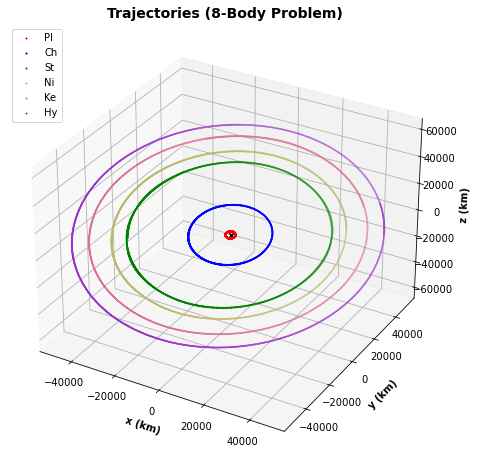

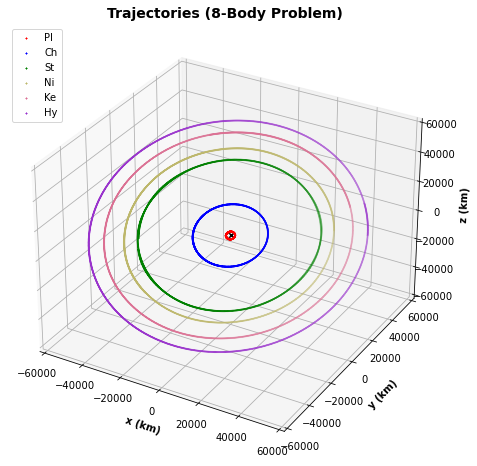

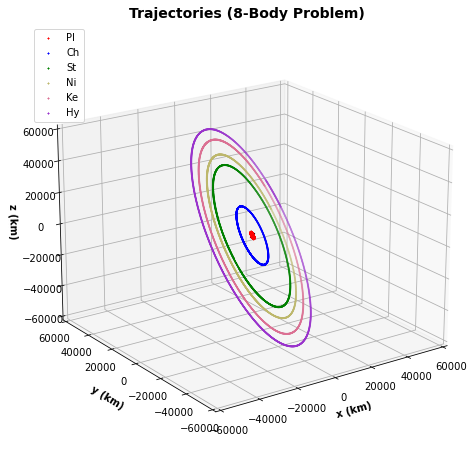

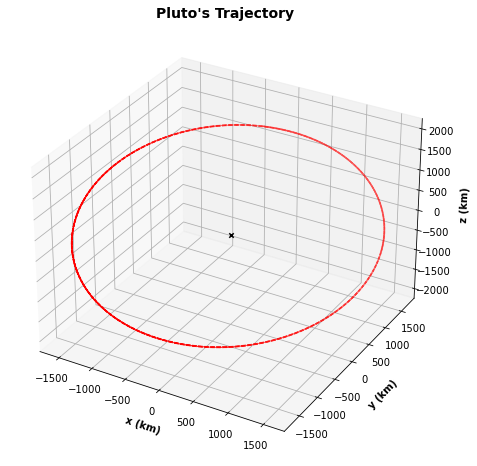

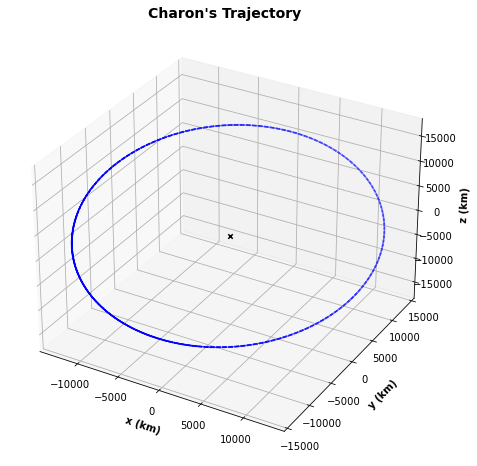

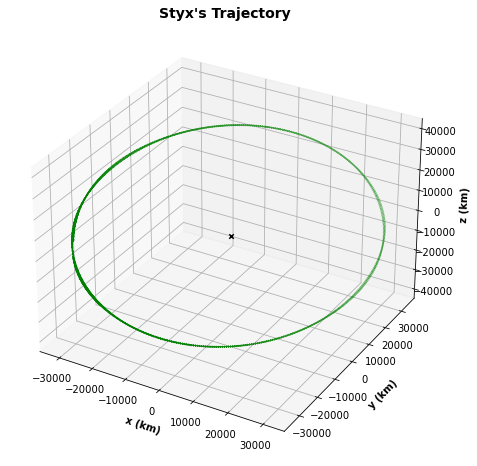

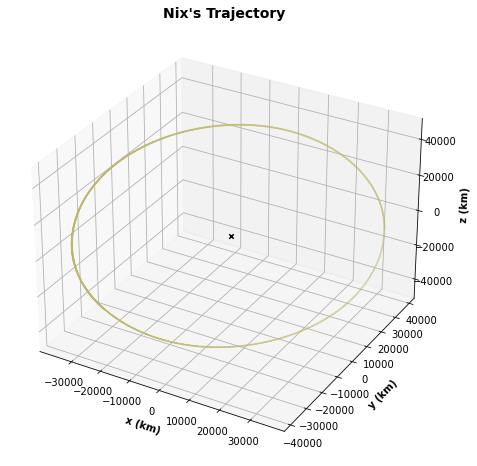

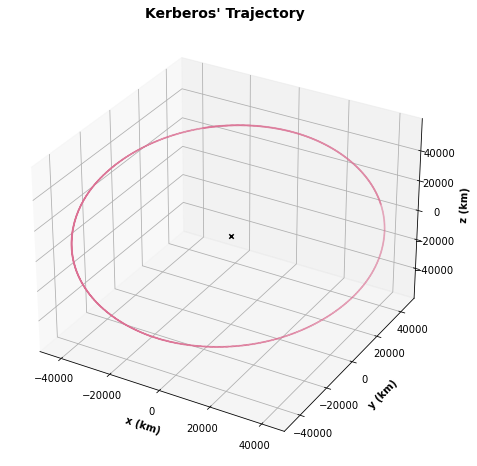

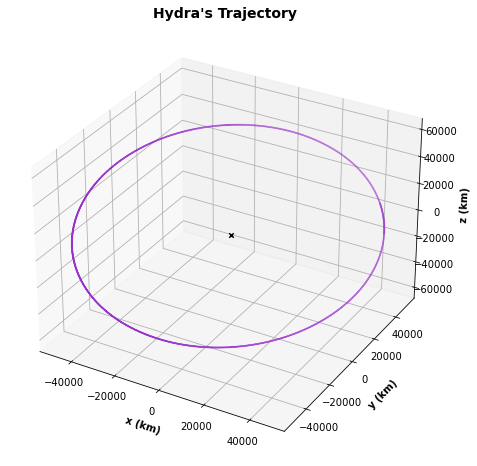

In [25]:
#-------------------------------------------------------------------------------------------------------------------------------
#Printing the approximated parameters for each body´s ellipse.
print("ELLIPTIC TRAJECTORIES' APPROXIMATED PARAMETERS:")
print("Pluto:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (pl_a_RKS, pl_b_RKS, pl_c_RKS, pl_e_RKS))
print("Charon:   \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ch_a_RKS, ch_b_RKS, ch_c_RKS, ch_e_RKS))
print("Styx:     \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (st_a_RKS, st_b_RKS, st_c_RKS, st_e_RKS))
print("Nix:      \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ni_a_RKS, ni_b_RKS, ni_c_RKS, ni_e_RKS))
print("Kerberos: \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ke_a_RKS, ke_b_RKS, ke_c_RKS, ke_e_RKS))
print("Hydra:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (hy_a_RKS, hy_b_RKS, hy_c_RKS, hy_e_RKS))

#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#Loop to plot only certain points (to ease the graphcator's job).

T = 1000                         # Amount of elements to plot (T=1000 means plotting every 1000).

pl_r_RKS_g = points_plot(h_RKS, T, pl_x_RKS, pl_y_RKS, pl_z_RKS, "Pl")
ch_r_RKS_g = points_plot(h_RKS, T, ch_x_RKS, ch_y_RKS, ch_z_RKS, "Ch")
st_r_RKS_g = points_plot(h_RKS, T, st_x_RKS, st_y_RKS, st_z_RKS, "St")
ni_r_RKS_g = points_plot(h_RKS, T, ni_x_RKS, ni_y_RKS, ni_z_RKS, "Ni")
ke_r_RKS_g = points_plot(h_RKS, T, ke_x_RKS, ke_y_RKS, ke_z_RKS, "Ke")
hy_r_RKS_g = points_plot(h_RKS, T, hy_x_RKS, hy_y_RKS, hy_z_RKS, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting all orbits together.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS_g[:,0], ch_r_RKS_g[:,1], ch_r_RKS_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS_g[:,0], st_r_RKS_g[:,1], st_r_RKS_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS_g[:,0], ni_r_RKS_g[:,1], ni_r_RKS_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS_g[:,0], ke_r_RKS_g[:,1], ke_r_RKS_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS_g[:,0], hy_r_RKS_g[:,1], hy_r_RKS_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Plotting all orbits together with axes at the same scale.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS_g[:,0], ch_r_RKS_g[:,1], ch_r_RKS_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS_g[:,0], st_r_RKS_g[:,1], st_r_RKS_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS_g[:,0], ni_r_RKS_g[:,1], ni_r_RKS_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS_g[:,0], ke_r_RKS_g[:,1], ke_r_RKS_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS_g[:,0], hy_r_RKS_g[:,1], hy_r_RKS_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.set_xlim3d(-60000, 60000)
ax.set_ylim3d(-60000, 60000)
ax.set_zlim3d(-60000, 60000)
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Plotting all orbits together, from a different perspective.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS_g[:,0], ch_r_RKS_g[:,1], ch_r_RKS_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS_g[:,0], st_r_RKS_g[:,1], st_r_RKS_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS_g[:,0], ni_r_RKS_g[:,1], ni_r_RKS_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS_g[:,0], ke_r_RKS_g[:,1], ke_r_RKS_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS_g[:,0], hy_r_RKS_g[:,1], hy_r_RKS_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.set_xlim3d(-60000, 60000)
ax.set_ylim3d(-60000, 60000)
ax.set_zlim3d(-60000, 60000)
ax.legend(loc='upper left')
ax.view_init(20, -125)
fig.set_size_inches(8, 8)
plt.show()

#Plotting all individual orbits.
plot_orbit("Pluto",    pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], col_pl, "Pl")
plot_orbit("Charon",   ch_r_RKS_g[:,0], ch_r_RKS_g[:,1], ch_r_RKS_g[:,2], col_ch, "Ch")
plot_orbit("Styx",     st_r_RKS_g[:,0], st_r_RKS_g[:,1], st_r_RKS_g[:,2], col_st, "St")
plot_orbit("Nix",      ni_r_RKS_g[:,0], ni_r_RKS_g[:,1], ni_r_RKS_g[:,2], col_ni, "Ni")
 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Kerberos' Trajectory", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(ke_r_RKS_g[:,0], ke_r_RKS_g[:,1], ke_r_RKS_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
fig.set_size_inches(8, 8)
plt.show()
    
plot_orbit("Hydra",    hy_r_RKS_g[:,0], hy_r_RKS_g[:,1], hy_r_RKS_g[:,2], col_hy, "Hy")


## Animations - 8-Body Problem

#### IMPORTANT: The following code are exclusivley to generate GIF animations that we used in presentations (PowerPoint, Prezi, etc.). It is NOT necessary to run these lines if you are only interested in the results.

##### The animations are saved in GIF format directly in the folder where this notebook is located. The path can be changed for each animation, as well as the file name.

In [26]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - rotating perspective
del filenames   #If this is the first animation, comment this line.
filenames = []
T = 108
k = 360/T
lim = tqdm((range(T)), desc="GIF: ")
for i in lim:
    #Creating each frame.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Trajectories\n8-Body Problem", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.scatter(pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
    ax.scatter(ch_r_RKS_g[:,0], ch_r_RKS_g[:,1], ch_r_RKS_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
    ax.scatter(st_r_RKS_g[:,0], st_r_RKS_g[:,1], st_r_RKS_g[:,2], marker="x", c=col_st, s=1, label="St");
    ax.scatter(ni_r_RKS_g[:,0], ni_r_RKS_g[:,1], ni_r_RKS_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
    ax.scatter(ke_r_RKS_g[:,0], ke_r_RKS_g[:,1], ke_r_RKS_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
    ax.scatter(hy_r_RKS_g[:,0], hy_r_RKS_g[:,1], hy_r_RKS_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    ax.view_init(20, -k*i)
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{i}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()

# The GIF is created.
with imageio.get_writer('Rotation_8BP.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/108 [00:00<?, ?it/s]

In [27]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - movement animation.
T = 200
k = math.floor(len(pl_r_RKS_g[:,0])/T)         # Amount of data in each of the T partitions.

del filenames   #If this is the first animation, comment this line.
filenames = []
lim = tqdm((range(T)), desc="GIF: ")
i = 0
d = 1
for j in lim:
    
    if i == 5:
        d = d + 1
        i = 0
    i = i + 1
    
    #Creating each frame.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Trajectories\n8-Body Problem\n2 days /s   (Day "+str(d)+")", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.plot(pl_r_RKS_g[:j*k,0], pl_r_RKS_g[:j*k,1], pl_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_pl);
    ax.scatter(pl_r_RKS_g[j*k,0], pl_r_RKS_g[j*k,1], pl_r_RKS_g[j*k,2], c=col_pl, label="Pl", s=40);
    ax.plot(ch_r_RKS_g[:j*k,0], ch_r_RKS_g[:j*k,1], ch_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_ch);
    ax.scatter(ch_r_RKS_g[j*k,0], ch_r_RKS_g[j*k,1], ch_r_RKS_g[j*k,2], c=col_ch, label="Ch", s=40);
    ax.plot(st_r_RKS_g[:j*k,0], st_r_RKS_g[:j*k,1], st_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_st);
    ax.scatter(st_r_RKS_g[j*k,0], st_r_RKS_g[j*k,1], st_r_RKS_g[j*k,2], c=col_st, label="St", s=40);
    ax.plot(ni_r_RKS_g[:j*k,0], ni_r_RKS_g[:j*k,1], ni_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_ni);
    ax.scatter(ni_r_RKS_g[j*k,0], ni_r_RKS_g[j*k,1], ni_r_RKS_g[j*k,2], c=col_ni, label="Ni", s=40);
    ax.plot(ke_r_RKS_g[:j*k,0], ke_r_RKS_g[:j*k,1], ke_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_ke);
    ax.scatter(ke_r_RKS_g[j*k,0], ke_r_RKS_g[j*k,1], ke_r_RKS_g[j*k,2], c=col_ke, label="Ke", s=40);
    ax.plot(hy_r_RKS_g[:j*k,0], hy_r_RKS_g[:j*k,1], hy_r_RKS_g[:j*k,2], lw=1, alpha=0.5, c=col_hy);
    ax.scatter(hy_r_RKS_g[j*k,0], hy_r_RKS_g[j*k,1], hy_r_RKS_g[j*k,2], c=col_hy, label="Hy", s=40);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{j}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()
    
# The GIF is created.
with imageio.get_writer('Orbits_8BP.gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/200 [00:00<?, ?it/s]

### Fitted Planes and Orbital Periods - 8-Body Problem

In [28]:
#-------------------------------------------------------------------------------------------------------------------------------
#Storing the data of the first orbit for each body.
p_r_pl_RKS = one_orbit(pl_x_RKS, pl_y_RKS, pl_z_RKS, "Pl")
p_r_ch_RKS = one_orbit(ch_x_RKS, ch_y_RKS, ch_z_RKS, "Ch")
p_r_st_RKS = one_orbit(st_x_RKS, st_y_RKS, st_z_RKS, "St")
p_r_ni_RKS = one_orbit(ni_x_RKS, ni_y_RKS, ni_z_RKS, "Ni")
p_r_ke_RKS = one_orbit(ke_x_RKS, ke_y_RKS, ke_z_RKS, "Ke")
p_r_hy_RKS = one_orbit(hy_x_RKS, hy_y_RKS, hy_z_RKS, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Generating the fitted plane for each orbit.
print("FITTED PLANES:\n")
pln_pl_RKS = plane("Pluto",    p_r_pl_RKS[:,0], p_r_pl_RKS[:,1], p_r_pl_RKS[:,2])
pln_ch_RKS = plane("Charon",   p_r_ch_RKS[:,0], p_r_ch_RKS[:,1], p_r_ch_RKS[:,2])
pln_st_RKS = plane("Styx",     p_r_st_RKS[:,0], p_r_st_RKS[:,1], p_r_st_RKS[:,2])
pln_ni_RKS = plane("Nix",      p_r_ni_RKS[:,0], p_r_ni_RKS[:,1], p_r_ni_RKS[:,2])
pln_ke_RKS = plane("Kerberos", p_r_ke_RKS[:,0], p_r_ke_RKS[:,1], p_r_ke_RKS[:,2])
pln_hy_RKS = plane("Hydra",    p_r_hy_RKS[:,0], p_r_hy_RKS[:,1], p_r_hy_RKS[:,2])

#-------------------------------------------------------------------------------------------------------------------------------
#The orbital period is calculated.
per_pl_RKS = period(h_RKS, p_r_pl_RKS[:,3])
per_ch_RKS = period(h_RKS, p_r_ch_RKS[:,3])
per_st_RKS = period(h_RKS, p_r_st_RKS[:,3])
per_ni_RKS = period(h_RKS, p_r_ni_RKS[:,3])
per_ke_RKS = period(h_RKS, p_r_ke_RKS[:,3])
per_hy_RKS = period(h_RKS, p_r_hy_RKS[:,3])

print("\nORBITAL PERIOD (and amount of data for 1st orbit)\n")
print_per(h_RKS, "Pluto",    p_r_pl_RKS, per_pl_RKS)
print_per(h_RKS, "Charon",   p_r_ch_RKS, per_ch_RKS)
print_per(h_RKS, "Styx",     p_r_st_RKS, per_st_RKS)
print_per(h_RKS, "Nix",      p_r_ni_RKS, per_ni_RKS)
print_per(h_RKS, "Kerberos", p_r_ke_RKS, per_ke_RKS)
print_per(h_RKS, "Hydra",    p_r_hy_RKS, per_hy_RKS)


1st Orbit (Pl):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ch):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (St):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ni):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ke):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Hy):   0%|          | 0/1000001 [00:00<?, ?it/s]

FITTED PLANES:

Pluto: -1.742641 x + 1.602680 y + -0.004088 = z
Charon: -1.742640 x + 1.602680 y + -0.002990 = z
Styx: -1.745971 x + 1.604349 y + 1.532032 = z
Nix: -1.741805 x + 1.598747 y + 1.799486 = z
Kerberos: -1.763615 x + 1.638545 y + 8.213100 = z
Hydra: -1.720591 x + 1.596025 y + 4.443342 = z

ORBITAL PERIOD (and amount of data for 1st orbit)

Pluto:
Amount of Data: 159867
Period (days):  6.3947 +/- 2e-05

Charon:
Amount of Data: 159867
Period (days):  6.3947 +/- 2e-05

Styx:
Amount of Data: 504916
Period (days):  20.19666 +/- 2e-05

Nix:
Amount of Data: 622794
Period (days):  24.91178 +/- 2e-05

Kerberos:
Amount of Data: 804223
Period (days):  32.16894 +/- 2e-05

Hydra:
Amount of Data: 955677
Period (days):  38.2271 +/- 2e-05



### Plotting Pluto's Trajectory - 8-Body Problem

##### To better analyze what improved with this model, we plot Pluto's trajectory. The orbital precession that was present in previous models is practically gone.

P. Proj. (Pl RKS) ::   0%|          | 0/1000 [00:00<?, ?it/s]

P. Proj. (Pl) ::   0%|          | 0/34561 [00:00<?, ?it/s]

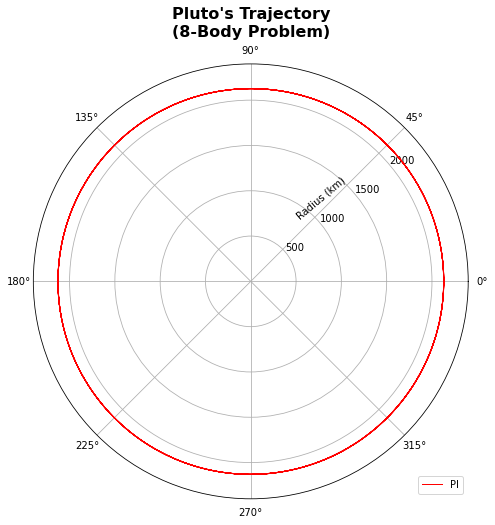

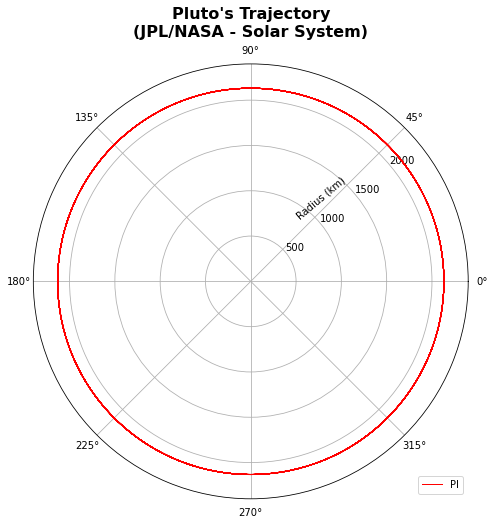

In [29]:
#-------------------------------------------------------------------------------------------------------------------------------
#Projecting all points on Pluto´s plane.
p_pl_r_RKS_g = points_proj(pl_r_RKS_g[:,0], pl_r_RKS_g[:,1], pl_r_RKS_g[:,2], pln_pl_RKS, "Pl RKS")
p_pl_r_g = points_proj(pl_r[:,0], pl_r[:,1], pl_r[:,2], pln_pl, "Pl")


#Plotting (polar) Pluto´s trajectory (6-Body Problem).
fig = plt.figure()
ax = plt.subplot(111, polar=True)
fig.set_size_inches(8, 8)
ax.set_title("Pluto's Trajectory\n(8-Body Problem)", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_pl_r_RKS_g[:,4], p_pl_r_RKS_g[:,3], color=col_pl, lw=1, label="Pl")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
ax.set_rmax(2400)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

#Plotting (polar) Pluto´s Trajectory (JPL/NASA - Solar System).
fig = plt.figure()
ax = plt.subplot(111, polar=True)
fig.set_size_inches(8, 8)
ax.set_title("Pluto's Trajectory\n(JPL/NASA - Solar System)", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_pl_r_g[:,4], p_pl_r_g[:,3], color=col_pl, lw=1, label="Pl")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
ax.set_rmax(2400)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()


### Projecting the Points to the Fitted Plane - 8-Body Problem

##### As we did for the analysis of the JPL/NASA data, we project the points onto the fitted plane to use those projections to fit an ellipse for  the body´s trajectory.

P. Proj. (Pl) ::   0%|          | 0/159867 [00:00<?, ?it/s]

P. Proj. (Ch) ::   0%|          | 0/159867 [00:00<?, ?it/s]

P. Proj. (St) ::   0%|          | 0/504916 [00:00<?, ?it/s]

P. Proj. (Ni) ::   0%|          | 0/622794 [00:00<?, ?it/s]

P. Proj. (Ke) ::   0%|          | 0/804223 [00:00<?, ?it/s]

P. Proj. (Hy) ::   0%|          | 0/955677 [00:00<?, ?it/s]

Points to Plot (Pl):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ch):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (St):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ni):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ke):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Hy):   0%|          | 0/1000 [00:00<?, ?it/s]

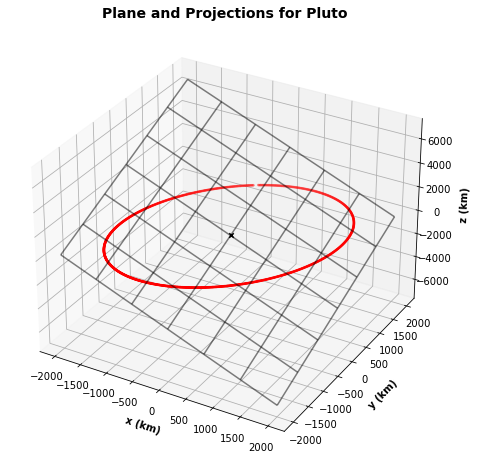

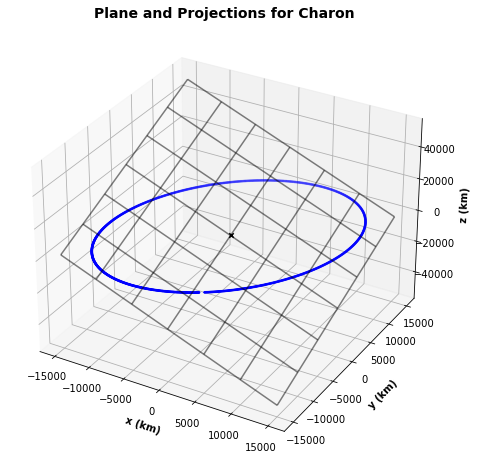

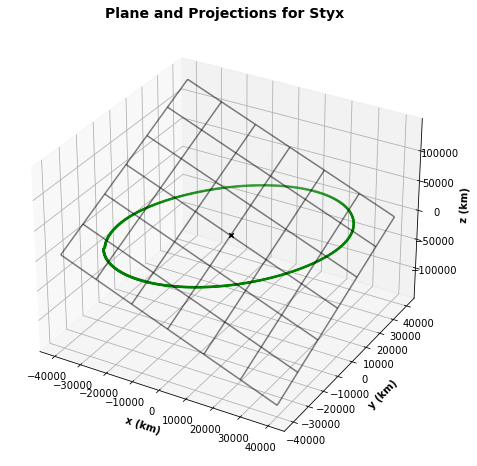

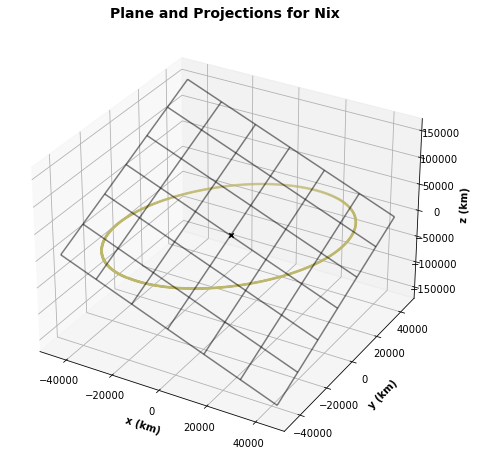

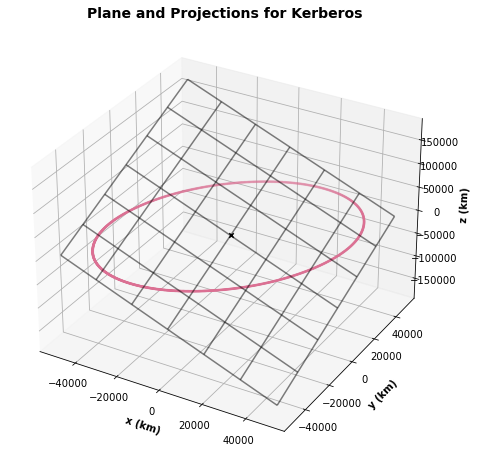

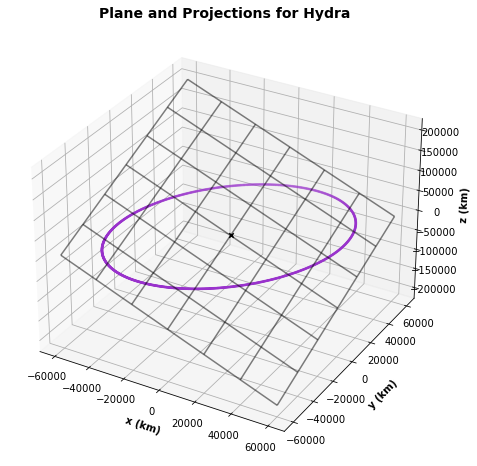

In [30]:
#-------------------------------------------------------------------------------------------------------------------------------
#Projecting the points to the plane.
p_pl_r_RKS = points_proj(p_r_pl_RKS[:,0], p_r_pl_RKS[:,1], p_r_pl_RKS[:,2], pln_pl_RKS, "Pl")
p_ch_r_RKS = points_proj(p_r_ch_RKS[:,0], p_r_ch_RKS[:,1], p_r_ch_RKS[:,2], pln_ch_RKS, "Ch")
p_st_r_RKS = points_proj(p_r_st_RKS[:,0], p_r_st_RKS[:,1], p_r_st_RKS[:,2], pln_st_RKS, "St")
p_ni_r_RKS = points_proj(p_r_ni_RKS[:,0], p_r_ni_RKS[:,1], p_r_ni_RKS[:,2], pln_ni_RKS, "Ni")
p_ke_r_RKS = points_proj(p_r_ke_RKS[:,0], p_r_ke_RKS[:,1], p_r_ke_RKS[:,2], pln_ke_RKS, "Ke")
p_hy_r_RKS = points_proj(p_r_hy_RKS[:,0], p_r_hy_RKS[:,1], p_r_hy_RKS[:,2], pln_hy_RKS, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the points in the plane.
T = 1000

p_pl_r_RKS_g = points_plot(h_RKS, T, p_pl_r_RKS[:,0], p_pl_r_RKS[:,1], p_pl_r_RKS[:,2], "Pl")
p_ch_r_RKS_g = points_plot(h_RKS, T, p_ch_r_RKS[:,0], p_ch_r_RKS[:,1], p_ch_r_RKS[:,2], "Ch")
p_st_r_RKS_g = points_plot(h_RKS, T, p_st_r_RKS[:,0], p_st_r_RKS[:,1], p_st_r_RKS[:,2], "St")
p_ni_r_RKS_g = points_plot(h_RKS, T, p_ni_r_RKS[:,0], p_ni_r_RKS[:,1], p_ni_r_RKS[:,2], "Ni")
p_ke_r_RKS_g = points_plot(h_RKS, T, p_ke_r_RKS[:,0], p_ke_r_RKS[:,1], p_ke_r_RKS[:,2], "Ke")
p_hy_r_RKS_g = points_plot(h_RKS, T, p_hy_r_RKS[:,0], p_hy_r_RKS[:,1], p_hy_r_RKS[:,2], "Hy")

#Plotting the points and the plane.
plot_plane("Pluto",    pln_pl_RKS, col_pl, p_pl_r_RKS_g, grid_pl)
plot_plane("Charon",   pln_ch_RKS, col_ch, p_ch_r_RKS_g, grid_ch)
plot_plane("Styx",     pln_st_RKS, col_st, p_st_r_RKS_g, grid_st)
plot_plane("Nix",      pln_ni_RKS, col_ni, p_ni_r_RKS_g, grid_ni)
plot_plane("Kerberos", pln_ke_RKS, col_ke, p_ke_r_RKS_g, grid_ke)
plot_plane("Hydra",    pln_hy_RKS, col_hy, p_hy_r_RKS_g, grid_hy)


### Fitting Ellipses - 8-Body Problem

In [31]:
#-------------------------------------------------------------------------------------------------------------------------------
#Generating the 2D points.
pl_2d_r_RKS = points_2d(p_pl_r_RKS, "Pl")
ch_2d_r_RKS = points_2d(p_ch_r_RKS, "Ch")
st_2d_r_RKS = points_2d(p_st_r_RKS, "St")
ni_2d_r_RKS = points_2d(p_ni_r_RKS, "Ni")
ke_2d_r_RKS = points_2d(p_ke_r_RKS, "Ke")
hy_2d_r_RKS = points_2d(p_hy_r_RKS, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Fitting the ellipse.

#The constants for the ellipse equation are calculated for each body.
ell_pl_RKS = fit_ellipse(pl_2d_r_RKS)
ell_ch_RKS = fit_ellipse(ch_2d_r_RKS)
ell_st_RKS = fit_ellipse(st_2d_r_RKS)
ell_ni_RKS = fit_ellipse(ni_2d_r_RKS)
ell_ke_RKS = fit_ellipse(ke_2d_r_RKS)
ell_hy_RKS = fit_ellipse(hy_2d_r_RKS)


2D Points (Pl) ::   0%|          | 0/159867 [00:00<?, ?it/s]

2D Points (Ch) ::   0%|          | 0/159867 [00:00<?, ?it/s]

2D Points (St) ::   0%|          | 0/504916 [00:00<?, ?it/s]

2D Points (Ni) ::   0%|          | 0/622794 [00:00<?, ?it/s]

2D Points (Ke) ::   0%|          | 0/804223 [00:00<?, ?it/s]

2D Points (Hy) ::   0%|          | 0/955677 [00:00<?, ?it/s]

<ipython-input-13-e09e82ee946b>:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()      # The constants are stored. They are for the equation of the form:


EQUATIONS OF FITTED ELLIPSES:
Pluto:     2.21e-07x^2 + -1.99e-12xy+2.21e-07y^2+-3.78e-07x+6.12e-07y = 1
Charon:    3.27e-09x^2 + 3.75e-15xy+3.27e-09y^2+4.79e-08x+-7.12e-08y = 1
Styx:      5.53e-10x^2 + -5.57e-12xy+5.58e-10y^2+1.03e-07x+-9.14e-08y = 1
Nix:       4.21e-10x^2 + 3.08e-14xy+4.2e-10y^2+5.54e-08x+-1.35e-08y = 1
Kerberos:  3e-10x^2 + -1.28e-13xy+3e-10y^2+1.01e-07x+-1.22e-08y = 1
Hydra:     2.38e-10x^2 + -2.17e-14xy+2.39e-10y^2+-1.44e-07x+1.6e-07y = 1


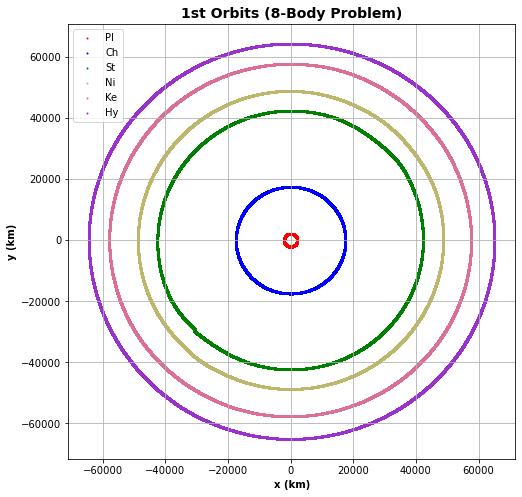

In [32]:
#-------------------------------------------------------------------------------------------------------------------------------
#Printing of each ellipse´s equation.
print("EQUATIONS OF FITTED ELLIPSES:")
print('Pluto:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_pl_RKS[0], ell_pl_RKS[1], ell_pl_RKS[2], ell_pl_RKS[3], ell_pl_RKS[4]))
print('Charon:    {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ch_RKS[0], ell_ch_RKS[1], ell_ch_RKS[2], ell_ch_RKS[3], ell_ch_RKS[4]))
print('Styx:      {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_st_RKS[0], ell_st_RKS[1], ell_st_RKS[2], ell_st_RKS[3], ell_st_RKS[4]))
print('Nix:       {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ni_RKS[0], ell_ni_RKS[1], ell_ni_RKS[2], ell_ni_RKS[3], ell_ni_RKS[4]))
print('Kerberos:  {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ke_RKS[0], ell_ke_RKS[1], ell_ke_RKS[2], ell_ke_RKS[3], ell_ke_RKS[4]))
print('Hydra:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_hy_RKS[0], ell_hy_RKS[1], ell_hy_RKS[2], ell_hy_RKS[3], ell_hy_RKS[4]))

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the points in a single graph (approximating all planes as equal).
fig = plt.figure()
plt.scatter(pl_2d_r_RKS[:,0], pl_2d_r_RKS[:,1], c=col_pl, s=1, label="Pl")
plt.scatter(ch_2d_r_RKS[:,0], ch_2d_r_RKS[:,1], c=col_ch, s=1, label="Ch")
plt.scatter(st_2d_r_RKS[:,0], st_2d_r_RKS[:,1], c=col_st, s=1, label="St")
plt.scatter(ni_2d_r_RKS[:,0], ni_2d_r_RKS[:,1], c=col_ni, s=1, label="Ni")
plt.scatter(ke_2d_r_RKS[:,0], ke_2d_r_RKS[:,1], c=col_ke, s=1, label="Ke")
plt.scatter(hy_2d_r_RKS[:,0], hy_2d_r_RKS[:,1], c=col_hy, s=1, label="Hy")
plt.title("1st Orbits (8-Body Problem)", fontweight="bold", fontsize=14)
plt.xlabel("x (km)", fontweight="bold")
plt.ylabel("y (km)", fontweight="bold")
plt.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.grid()
plt.xlim([min(hy_2d_r_RKS[:,0]) - (abs(min(hy_2d_r_RKS[:,0]))/10), max(hy_2d_r_RKS[:,0]) + (abs(max(hy_2d_r_RKS[:,0]))/10)])
plt.ylim([min(hy_2d_r_RKS[:,1]) - (abs(min(hy_2d_r_RKS[:,1]))/10), max(hy_2d_r_RKS[:,1]) + (abs(max(hy_2d_r_RKS[:,1]))/10)])
plt.show()


### Fitted Ellipses' Parameters - 8-Body Problem

##### With the ellipses' equations, we obtained its parameters the same way we calculated the parameters for the JPL/NASA trajectories. We get an alligned ellipse and then calculate its parameters instead.

In [33]:
#-------------------------------------------------------------------------------------------------------------------------------
#The parameters for each elliptical orbit are calculated.
ell_pl_a_RKS, ell_pl_b_RKS, ell_pl_c_RKS, ell_pl_e_RKS = param_ellipse(ell_pl_RKS)
ell_ch_a_RKS, ell_ch_b_RKS, ell_ch_c_RKS, ell_ch_e_RKS = param_ellipse(ell_ch_RKS)
ell_st_a_RKS, ell_st_b_RKS, ell_st_c_RKS, ell_st_e_RKS = param_ellipse(ell_st_RKS)
ell_ni_a_RKS, ell_ni_b_RKS, ell_ni_c_RKS, ell_ni_e_RKS = param_ellipse(ell_ni_RKS)
ell_ke_a_RKS, ell_ke_b_RKS, ell_ke_c_RKS, ell_ke_e_RKS = param_ellipse(ell_ke_RKS)
ell_hy_a_RKS, ell_hy_b_RKS, ell_hy_c_RKS, ell_hy_e_RKS = param_ellipse(ell_hy_RKS)

#-------------------------------------------------------------------------------------------------------------------------------
#Printing the parameters along with the ones from JPL/NASA.

#Function to print both sets of parameters (JPL/NASA and 8BP).
def print_param_RKS(title, ell_a, ell_b, ell_c, ell_e, a, b, c, e):
    print(title + ':')
    print('8BP:        a: ' + str(ell_a) + '   b: ' + str(ell_b) + '   c: ' + str(ell_c) + '   e: ' + str(ell_e))
    print('JPL/NASA:   a: ' + str(a)     + '   b: ' + str(b)     + '   c: ' + str(c)     + '   e: ' + str(e))
    print("")

#Printing the parameters (8BP vs. JPL/NASA).
print("ELLIPTIC TRAJECTORIES' PARAMETERS:")
print_param_RKS("Pluto",    ell_pl_a_RKS, ell_pl_b_RKS, ell_pl_c_RKS, ell_pl_e_RKS, ell_pl_a, ell_pl_b, ell_pl_c, ell_pl_e)
print_param_RKS("Charon",   ell_ch_a_RKS, ell_ch_b_RKS, ell_ch_c_RKS, ell_ch_e_RKS, ell_ch_a, ell_ch_b, ell_ch_c, ell_ch_e)
print_param_RKS("Styx",     ell_st_a_RKS, ell_st_b_RKS, ell_st_c_RKS, ell_st_e_RKS, ell_st_a, ell_st_b, ell_st_c, ell_st_e)
print_param_RKS("Nix",      ell_ni_a_RKS, ell_ni_b_RKS, ell_ni_c_RKS, ell_ni_e_RKS, ell_ni_a, ell_ni_b, ell_ni_c, ell_ni_e)
print_param_RKS("Kerberos", ell_ke_a_RKS, ell_ke_b_RKS, ell_ke_c_RKS, ell_ke_e_RKS, ell_ke_a, ell_ke_b, ell_ke_c, ell_ke_e)
print_param_RKS("Hydra",    ell_hy_a_RKS, ell_hy_b_RKS, ell_hy_c_RKS, ell_hy_e_RKS, ell_hy_a, ell_hy_b, ell_hy_c, ell_hy_e)


ELLIPTIC TRAJECTORIES' PARAMETERS:
Pluto:
8BP:        a: 2129.3495752809695   b: 2129.3389992904376   c: 6.711173522055058   e: 0.0031517481206341453
JPL/NASA:   a: 2131.9525780085874   b: 2131.940437660205   c: 7.194799974670571   e: 0.0033747467222745835

Charon:
8BP:        a: 17482.79276766616   b: 17482.77125248796   c: 27.427911709089468   e: 0.001568851846141491
JPL/NASA:   a: 17468.581965802936   b: 17468.56914863113   c: 21.161178328977304   e: 0.0012113850094195445

Styx:
8BP:        a: 42566.54780605922   b: 42272.01780018696   c: 4998.750166411802   e: 0.11743376956916965
JPL/NASA:   a: 42525.54676510705   b: 42227.7681092794   c: 5023.716570451829   e: 0.11813408533465049

Nix:
8BP:        a: 48773.046827867525   b: 48751.60735913103   c: 1445.986436478526   e: 0.029647244339313105
JPL/NASA:   a: 48709.67732808953   b: 48690.25614758018   c: 1375.3623848388304   e: 0.028235916562841194

Kerberos:
8BP:        a: 57755.188194129856   b: 57742.68469983742   c: 1201.7183507456

### Trajectory Comparison (8-Body Problem vs. JPL/NASA)

##### We plot the elliptic trajectories from the 8BP model along with the one from the data analysis of JPL/NASA to compare them.

In [34]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot each body´s trajectory to compare.
def plot_8BP_RKS(title, th_k, r_k, th_o, r_o, col):
    fig = plt.figure()
    ax = plt.axes(polar = True)
    fig.set_size_inches(8, 8)
    ax.set_title(title+"'s Trajectories", va='bottom', fontweight="bold", fontsize=16)
    plt.polar(th_k, r_k, color=col, lw=2, label="8BP")
    plt.polar(th_o, r_o, color=col, lw=3, linestyle='dashed')
    plt.polar(0, 0, color=col, label="JPL/NASA", linestyle="dashed")
    ax.legend(loc='lower right')
    ax.set_rlabel_position(40)
    label_position=ax.get_rlabel_position()
    ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
    plt.show()


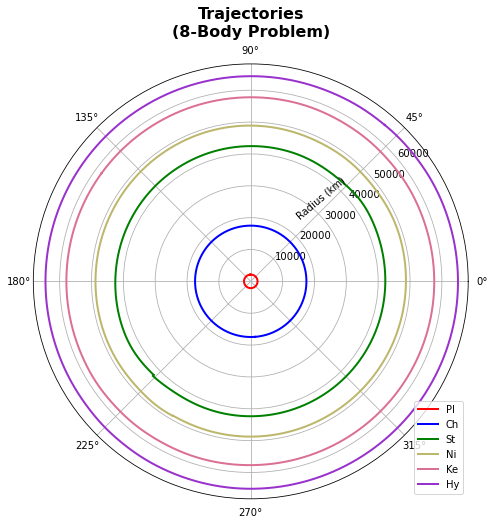

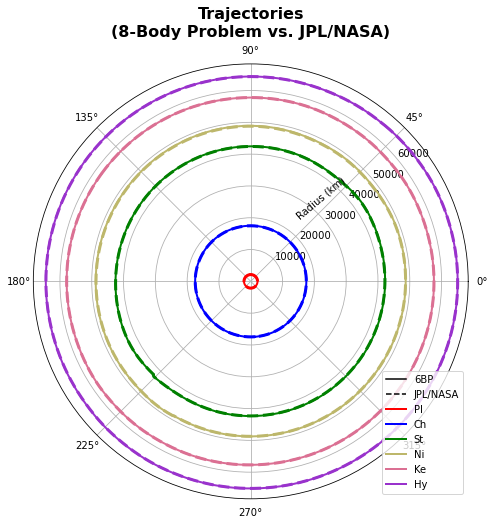

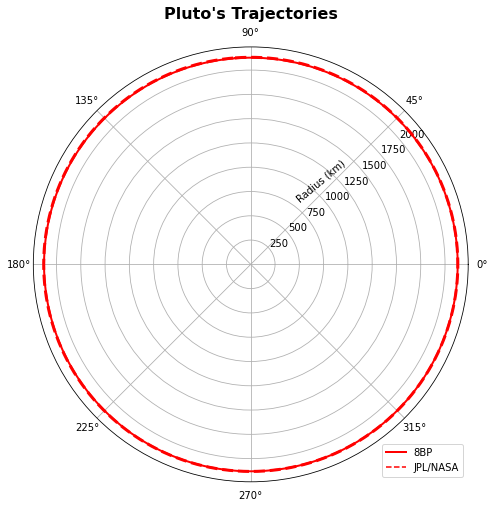

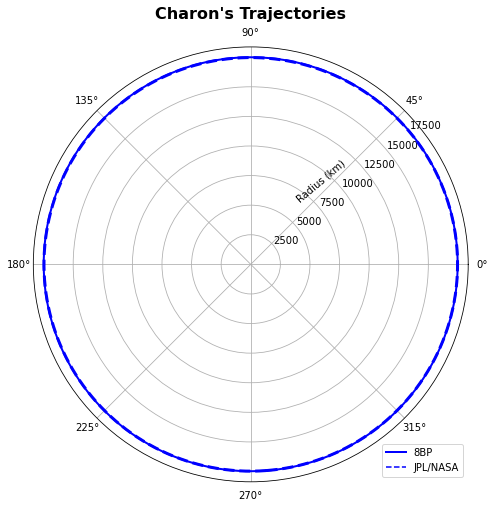

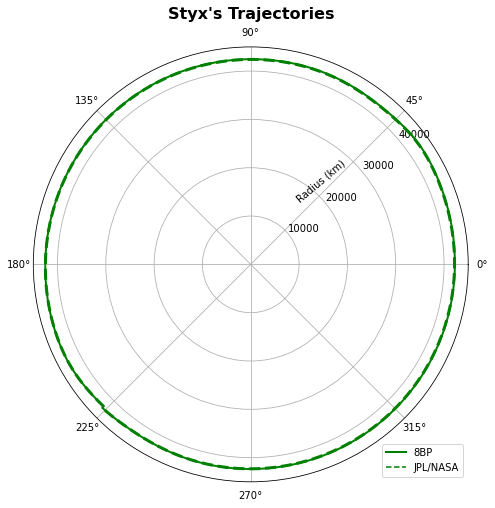

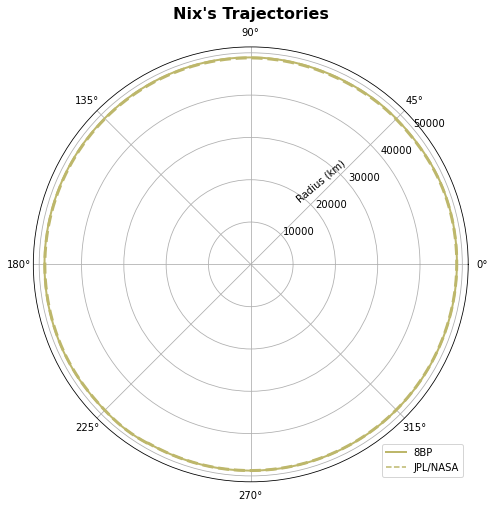

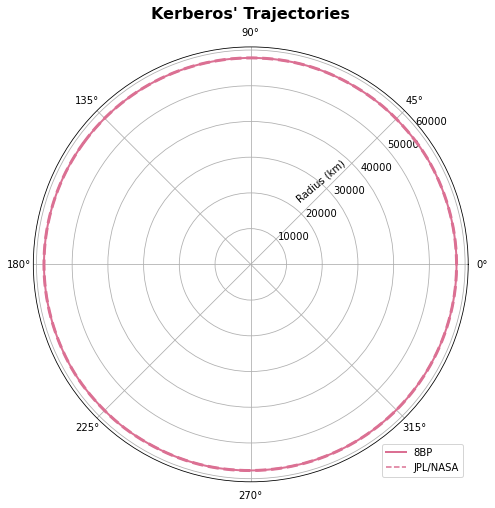

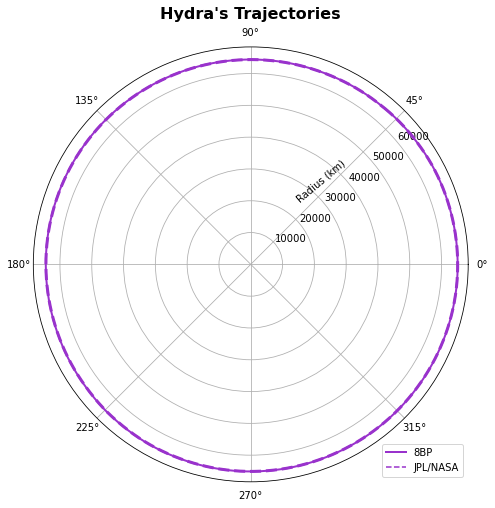

In [35]:
#-------------------------------------------------------------------------------------------------------------------------------
#Plotting all 8BP trajectories.
fig = plt.figure()
ax = plt.subplot(111, polar=True)
fig.set_size_inches(8, 8)
ax.set_title("Trajectories\n(8-Body Problem)", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_pl_r_RKS[:,4], p_pl_r_RKS[:,3], color=col_pl, lw=2, label="Pl")
plt.polar(p_ch_r_RKS[:,4], p_ch_r_RKS[:,3], color=col_ch, lw=2, label="Ch")
plt.polar(p_st_r_RKS[:,4], p_st_r_RKS[:,3], color=col_st, lw=2, label="St")
plt.polar(p_ni_r_RKS[:,4], p_ni_r_RKS[:,3], color=col_ni, lw=2, label="Ni")
plt.polar(p_ke_r_RKS[:,4], p_ke_r_RKS[:,3], color=col_ke, lw=2, label="Ke")
plt.polar(p_hy_r_RKS[:,4], p_hy_r_RKS[:,3], color=col_hy, lw=2, label="Hy")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

#Plotting the comparison: 8-Body Problem vs. JPL/NASA.
fig = plt.figure()
ax = plt.axes(polar = True)
fig.set_size_inches(8, 8)
ax.set_title("Trajectories\n(8-Body Problem vs. JPL/NASA)", va='bottom', fontweight="bold", fontsize=16)
plt.plot(0, 0, color="black", label="6BP")                            # These plots are
plt.plot(0, 0, color="black", label="JPL/NASA", linestyle="dashed")   # just for the labels.
plt.polar(p_pl_r_RKS[:,4], p_pl_r_RKS[:,3], color=col_pl, lw=2, label="Pl")
plt.polar(p_ch_r_RKS[:,4], p_ch_r_RKS[:,3], color=col_ch, lw=2, label="Ch")
plt.polar(p_st_r_RKS[:,4], p_st_r_RKS[:,3], color=col_st, lw=2, label="St")
plt.polar(p_ni_r_RKS[:,4], p_ni_r_RKS[:,3], color=col_ni, lw=2, label="Ni")
plt.polar(p_ke_r_RKS[:,4], p_ke_r_RKS[:,3], color=col_ke, lw=2, label="Ke")
plt.polar(p_hy_r_RKS[:,4], p_hy_r_RKS[:,3], color=col_hy, lw=2, label="Hy")
plt.polar(p_pl_r[:,4], p_pl_r[:,3], color=col_pl, lw=3, linestyle='dashed')
plt.polar(p_ch_r[:,4], p_ch_r[:,3], color=col_ch, lw=3, linestyle='dashed')
plt.polar(p_st_r[:,4], p_st_r[:,3], color=col_st, lw=3, linestyle='dashed')
plt.polar(p_ni_r[:,4], p_ni_r[:,3], color=col_ni, lw=3, linestyle='dashed')
plt.polar(p_ke_r[:,4], p_ke_r[:,3], color=col_ke, lw=3, linestyle='dashed')
plt.polar(p_hy_r[:,4], p_hy_r[:,3], color=col_hy, lw=3, linestyle='dashed')
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

#Plotting the comparison for each individual body.
plot_8BP_RKS("Pluto",    p_pl_r_RKS[:,4], p_pl_r_RKS[:,3], p_pl_r[:,4], p_pl_r[:,3], col_pl)
plot_8BP_RKS("Charon",   p_ch_r_RKS[:,4], p_ch_r_RKS[:,3], p_ch_r[:,4], p_ch_r[:,3], col_ch)
plot_8BP_RKS("Styx",     p_st_r_RKS[:,4], p_st_r_RKS[:,3], p_st_r[:,4], p_st_r[:,3], col_st)
plot_8BP_RKS("Nix",      p_ni_r_RKS[:,4], p_ni_r_RKS[:,3], p_ni_r[:,4], p_ni_r[:,3], col_ni)

fig = plt.figure()
ax = plt.axes(polar = True)
fig.set_size_inches(8, 8)
ax.set_title("Kerberos' Trajectories", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_ke_r_RKS[:,4], p_ke_r_RKS[:,3], color=col_ke, lw=2, label="8BP")
plt.polar(p_ke_r[:,4], p_ke_r[:,3], color=col_ke, lw=3, linestyle='dashed')
plt.polar(0, 0, color=col_ke, label="JPL/NASA", linestyle="dashed")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

plot_8BP_RKS("Hydra",    p_hy_r_RKS[:,4], p_hy_r_RKS[:,3], p_hy_r[:,4], p_hy_r[:,3], col_hy)


### Angular Momentum Conservation - 8-Body Problem

##### This model also presents a conservation of the angular momentum around an average value.

In [38]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot the angular momentum for every coordinate.
def plot_L_RKS(title, L, color, aver):
    fig = plt.figure()
    plt.scatter(range(len(L)), L, c=color, s=1, label="|L|")
    plt.title("|L| - " + title + " (avg.: " + str(aver) + ")\n", fontweight="bold", fontsize=12)
    plt.xlabel("Coordinate Index", fontweight="bold")
    plt.ylabel("|L| (kg km^2 / d)", fontweight="bold")
    plt.legend(loc='upper left')
    plt.grid()
    plt.ylim([min(L) - (min(L)/10), max(L) + (max(L)/10)])   # Keeps the plot limits by 10% above and under
    plt.show()                                               # the highest and lowest values plotted.


In [43]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the angular momentum for every body.
pl_L_RKS = momentum(pl_X_RKS, pl_Y_RKS, pl_Z_RKS, pl_VX_RKS, pl_VY_RKS, pl_VZ_RKS, pl_m, "Pl")
ch_L_RKS = momentum(ch_X_RKS, ch_Y_RKS, ch_Z_RKS, ch_VX_RKS, ch_VY_RKS, ch_VZ_RKS, ch_m, "Ch")
st_L_RKS = momentum(st_X_RKS, st_Y_RKS, st_Z_RKS, st_VX_RKS, st_VY_RKS, st_VZ_RKS, st_m, "St")
ni_L_RKS = momentum(ni_X_RKS, ni_Y_RKS, ni_Z_RKS, ni_VX_RKS, ni_VY_RKS, ni_VZ_RKS, ni_m, "Ni")
ke_L_RKS = momentum(ke_X_RKS, ke_Y_RKS, ke_Z_RKS, ke_VX_RKS, ke_VY_RKS, ke_VZ_RKS, ke_m, "Ke")
hy_L_RKS = momentum(hy_X_RKS, hy_Y_RKS, hy_Z_RKS, hy_VX_RKS, hy_VY_RKS, hy_VZ_RKS, hy_m, "Hy")
sun_L_RKS = momentum(sun_X_RKS, sun_Y_RKS, sun_Z_RKS, sun_VX_RKS, sun_VY_RKS, sun_VZ_RKS, sun_m, "Sun")
jup_L_RKS = momentum(jup_X_RKS, jup_Y_RKS, jup_Z_RKS, jup_VX_RKS, jup_VY_RKS, jup_VZ_RKS, jup_m, "Jup")


#-------------------------------------------------------------------------------------------------------------------------------
#PLS's total angular momentum.
L_t_RKS = np.empty((len(pl_L_RKS)), float)
lim = tqdm(range(len(pl_L_RKS)), desc="Total Momentum: ")
for i in lim:
    L_t_RKS[i] = pl_L_RKS[i] + ch_L_RKS[i] + st_L_RKS[i] + ni_L_RKS[i] + ke_L_RKS[i] + hy_L_RKS[i] + sun_L_RKS[i] + jup_L_RKS[i]

#-------------------------------------------------------------------------------------------------------------------------------
#Averages.
aver_L_pl_RKS = avg(pl_L_RKS)
aver_L_ch_RKS = avg(ch_L_RKS)
aver_L_st_RKS = avg(st_L_RKS)
aver_L_ni_RKS = avg(ni_L_RKS)
aver_L_ke_RKS = avg(ke_L_RKS)
aver_L_hy_RKS = avg(hy_L_RKS)
aver_L_sun_RKS = avg(sun_L_RKS)
aver_L_jup_RKS = avg(jup_L_RKS)
aver_L_t_RKS  = avg(L_t_RKS)


Pl's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

St's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Total Momentum:   0%|          | 0/1000001 [00:00<?, ?it/s]

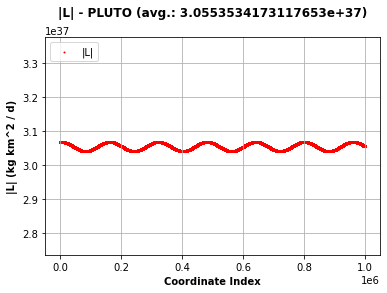

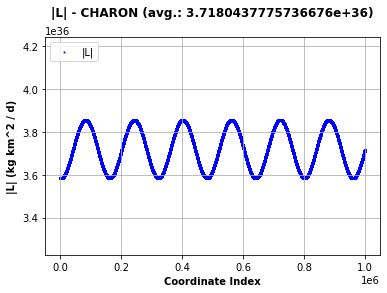

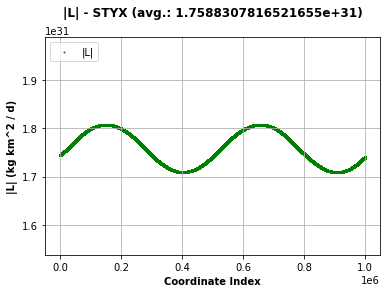

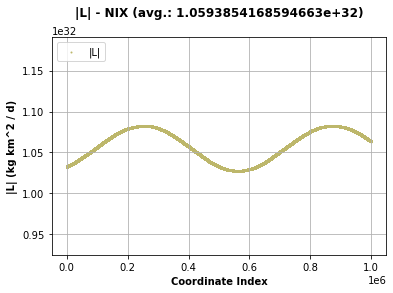

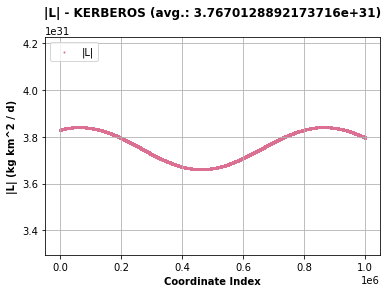

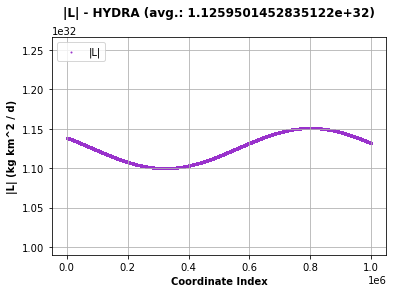

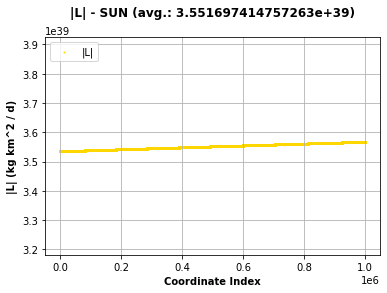

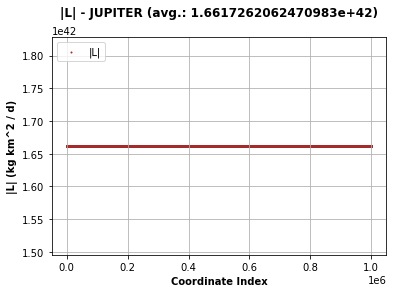

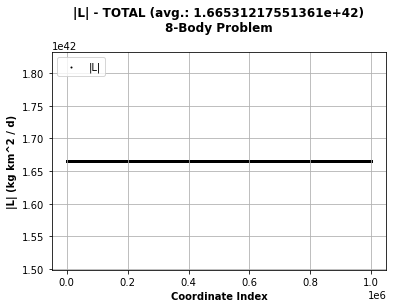

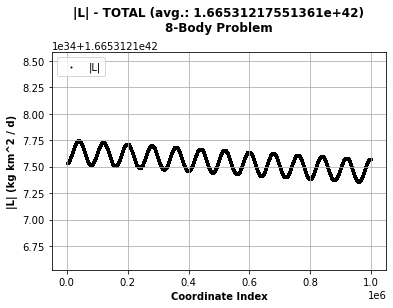

In [45]:
#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the angular momentum of each body.
plot_L_RKS("PLUTO",    pl_L_RKS, col_pl, aver_L_pl_RKS)
plot_L_RKS("CHARON",   ch_L_RKS, col_ch, aver_L_ch_RKS)
plot_L_RKS("STYX",     st_L_RKS, col_st, aver_L_st_RKS)
plot_L_RKS("NIX",      ni_L_RKS, col_ni, aver_L_ni_RKS)
plot_L_RKS("KERBEROS", ke_L_RKS, col_ke, aver_L_ke_RKS)
plot_L_RKS("HYDRA",    hy_L_RKS, col_hy, aver_L_hy_RKS)
plot_L_RKS("SUN",      sun_L_RKS, col_sun, aver_L_sun_RKS)
plot_L_RKS("JUPITER",  jup_L_RKS, col_jup, aver_L_jup_RKS)

#Plotting the PLS's total angular momentum.
fig = plt.figure()
plt.scatter(range(len(L_t_RKS)), L_t_RKS, c="black", s=1, label="|L|")
plt.title("|L| - TOTAL (avg.: " + str(aver_L_t_RKS) + ")\n8-Body Problem\n", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("|L| (kg km^2 / d)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(L_t_RKS) - (min(L_t_RKS)/10), max(L_t_RKS) + (max(L_t_RKS)/10)])   # Keeps the plot limits 10% above and under
plt.show()                                                                       # the highest and lowest values plotted.

#Zoom to notice the PLS's total angular momentum variation.
fig = plt.figure()
plt.scatter(range(len(L_t_RKS)), L_t_RKS, c="black", s=1, label="|L|")
plt.title("|L| - TOTAL (avg.: " + str(aver_L_t_RKS) + ")\n8-Body Problem\n", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("|L| (kg km^2 / d)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(L_t_RKS) - (min(L_t_RKS)/2e8), max(L_t_RKS) + (max(L_t_RKS)/2e8)])  # The limits are established to hace the zoom.
plt.show()


### Energy Conservation - 8-Body Problem

##### This model also presents a conservation of the energy around an average value.

In [46]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Universal Gravitational Constant (days).
G = 4.982174e-10  #(km^3 / kg d^2) 

#-------------------------------------------------------------------------------------------------------------------------------
#Function to calculate the distances.
def dist(x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8):
    ds1 = np.empty((len(x1), 7), float)
    ds2 = np.empty((len(x1), 7), float)
    ds3 = np.empty((len(x1), 7), float)      # Matrices to store each body´s distances to the other bodies.
    ds4 = np.empty((len(x1), 7), float)
    ds5 = np.empty((len(x1), 7), float)
    ds6 = np.empty((len(x1), 7), float)
    ds7 = np.empty((len(x1), 7), float)
    ds8 = np.empty((len(x1), 7), float)
    
    lim = tqdm(range(len(x1)), desc="Dist. Loop: ")
    for i in lim:
        #Pluto's Distances.
        d12 = math.sqrt((x2[i] - x1[i])**2 + (y2[i] - y1[i])**2 + (z2[i] - z1[i])**2)   # For each instant, it calculates
        d13 = math.sqrt((x3[i] - x1[i])**2 + (y3[i] - y1[i])**2 + (z3[i] - z1[i])**2)   # the distance from each body to
        d14 = math.sqrt((x4[i] - x1[i])**2 + (y4[i] - y1[i])**2 + (z4[i] - z1[i])**2)   # all other bodies.
        d15 = math.sqrt((x5[i] - x1[i])**2 + (y5[i] - y1[i])**2 + (z5[i] - z1[i])**2)
        d16 = math.sqrt((x6[i] - x1[i])**2 + (y6[i] - y1[i])**2 + (z6[i] - z1[i])**2)
        d17 = math.sqrt((x7[i] - x1[i])**2 + (y7[i] - y1[i])**2 + (z7[i] - z1[i])**2)
        d18 = math.sqrt((x8[i] - x1[i])**2 + (y8[i] - y1[i])**2 + (z8[i] - z1[i])**2)
        
        # Storing all distances in a line of the matrix.
        ds1[i,0], ds1[i,1], ds1[i,2], ds1[i,3], ds1[i,4], ds1[i,5], ds1[i,6] = d12, d13, d14, d15, d16, d17, d18
        
        #Charon's Distances.
        d21 = d12
        d23 = math.sqrt((x3[i] - x2[i])**2 + (y3[i] - y2[i])**2 + (z3[i] - z2[i])**2)
        d24 = math.sqrt((x4[i] - x2[i])**2 + (y4[i] - y2[i])**2 + (z4[i] - z2[i])**2)
        d25 = math.sqrt((x5[i] - x2[i])**2 + (y5[i] - y2[i])**2 + (z5[i] - z2[i])**2)
        d26 = math.sqrt((x6[i] - x2[i])**2 + (y6[i] - y2[i])**2 + (z6[i] - z2[i])**2)
        d27 = math.sqrt((x7[i] - x2[i])**2 + (y7[i] - y2[i])**2 + (z7[i] - z2[i])**2)
        d28 = math.sqrt((x8[i] - x2[i])**2 + (y8[i] - y2[i])**2 + (z8[i] - z2[i])**2)
        
        ds2[i,0], ds2[i,1], ds2[i,2], ds2[i,3], ds2[i,4], ds2[i,5], ds2[i,6] = d21, d23, d24, d25, d26, d27, d28
        
        #Styx's Distances.
        d31 = d13
        d32 = d23
        d34 = math.sqrt((x4[i] - x3[i])**2 + (y4[i] - y3[i])**2 + (z4[i] - z3[i])**2)
        d35 = math.sqrt((x5[i] - x3[i])**2 + (y5[i] - y3[i])**2 + (z5[i] - z3[i])**2)
        d36 = math.sqrt((x6[i] - x3[i])**2 + (y6[i] - y3[i])**2 + (z6[i] - z3[i])**2)
        d37 = math.sqrt((x7[i] - x3[i])**2 + (y7[i] - y3[i])**2 + (z7[i] - z3[i])**2)
        d38 = math.sqrt((x8[i] - x3[i])**2 + (y8[i] - y3[i])**2 + (z8[i] - z3[i])**2)

        ds3[i,0], ds3[i,1], ds3[i,2], ds3[i,3], ds3[i,4], ds3[i,5], ds3[i,6] = d31, d32, d34, d35, d36, d37, d38
        
        #Nix's Distances.
        d41 = d14
        d42 = d24
        d43 = d34
        d45 = math.sqrt((x5[i] - x4[i])**2 + (y5[i] - y4[i])**2 + (z5[i] - z4[i])**2)
        d46 = math.sqrt((x6[i] - x4[i])**2 + (y6[i] - y4[i])**2 + (z6[i] - z4[i])**2)
        d47 = math.sqrt((x7[i] - x4[i])**2 + (y7[i] - y4[i])**2 + (z7[i] - z4[i])**2)
        d48 = math.sqrt((x8[i] - x4[i])**2 + (y8[i] - y4[i])**2 + (z8[i] - z4[i])**2)

        ds4[i,0], ds4[i,1], ds4[i,2], ds4[i,3], ds4[i,4], ds4[i,5], ds4[i,6] = d41, d42, d43, d45, d46, d47, d48
        
        #Kerberos' Distances.
        d51 = d15
        d52 = d25
        d53 = d35
        d54 = d45
        d56 = math.sqrt((x6[i] - x5[i])**2 + (y6[i] - y5[i])**2 + (z6[i] - z5[i])**2)
        d57 = math.sqrt((x7[i] - x5[i])**2 + (y7[i] - y5[i])**2 + (z7[i] - z5[i])**2)
        d58 = math.sqrt((x8[i] - x5[i])**2 + (y8[i] - y5[i])**2 + (z8[i] - z5[i])**2)

        ds5[i,0], ds5[i,1], ds5[i,2], ds5[i,3], ds5[i,4], ds5[i,5], ds5[i,6] = d51, d52, d53, d54, d56, d57, d58
        
        #Hydra's Distances.
        d61 = d16
        d62 = d26
        d63 = d36
        d64 = d46
        d65 = d56
        d67 = math.sqrt((x7[i] - x6[i])**2 + (y7[i] - y6[i])**2 + (z7[i] - z6[i])**2)
        d68 = math.sqrt((x8[i] - x6[i])**2 + (y8[i] - y6[i])**2 + (z8[i] - z6[i])**2)

        ds6[i,0], ds6[i,1], ds6[i,2], ds6[i,3], ds6[i,4], ds6[i,5], ds6[i,6] = d61, d62, d63, d64, d65, d67, d68
        
        #Sun's Distances.
        d71 = d17
        d72 = d27
        d73 = d37
        d74 = d47
        d75 = d57
        d76 = d67
        d78 = math.sqrt((x8[i] - x7[i])**2 + (y8[i] - y7[i])**2 + (z8[i] - z7[i])**2)

        ds7[i,0], ds7[i,1], ds7[i,2], ds7[i,3], ds7[i,4], ds7[i,5], ds7[i,6] = d71, d72, d73, d74, d75, d76, d78
        
        #Jupiter's Distances.
        d81 = d18
        d82 = d28
        d83 = d38
        d84 = d48
        d85 = d58
        d86 = d68
        d87 = d78

        ds8[i,0], ds8[i,1], ds8[i,2], ds8[i,3], ds8[i,4], ds8[i,5], ds8[i,6] = d81, d82, d83, d84, d85, d86, d87

    return ds1, ds2, ds3, ds4, ds5, ds6, ds7, ds8     # Returns all matrices.

#-------------------------------------------------------------------------------------------------------------------------------
#Function for the energy.
def energy_RKS(ds, v, m1, m2, m3, m4, m5, m6, m7, m8, title):
    T, U, E = np.empty((len(v)), float), np.empty((len(v)), float), np.empty((len(v)), float)

    lim = tqdm(range(len(v)), desc="Energies ("+title+"): ")
    for i in lim:        # The loop calculates the energy for each coordinate.
        T[i] = 0.5*m1*(v[i]**2)
        U[i] = ((-G*m1*m2) / (ds[i,0])) + ((-G*m1*m3) / (ds[i,1])) + ((-G*m1*m4) / (ds[i,2])) + ((-G*m1*m5) / (ds[i,3])) + ((-G*m1*m6) / (ds[i,4])) + ((-G*m1*m7) / (ds[i,5])) + ((-G*m1*m8) / (ds[i,6]))
        E[i] = T[i] + U[i]
        
    return T, U, E

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot the energy for each body.
def plot_E_RKS(title, T, U, E, color):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)  
    ax1.scatter(range(len(T)), T, c="salmon", s=10, label="|T|")
    ax1.scatter(range(len(U)), U, c="darkcyan", s=10, label="|U|")
    ax1.scatter(range(len(E)), E, c=color, s=1, label="|E|")
    plt.title("E,T and U - " + title, fontweight="bold", fontsize=12)
    plt.xlabel("Coordinate Index", fontweight="bold")
    plt.ylabel("E,T,U (kg km^2 / d^2)", fontweight="bold")
    plt.legend(loc='upper left')
    plt.grid()
    lim_inf = min(np.array([min(E), min(T), min(U)]))
    lim_sup = max(np.array([max(E), max(T), max(U)]))
    extra = max(np.array([abs(lim_inf), abs(lim_sup)]))
    plt.ylim([lim_inf - extra/10, lim_sup + extra/10])
    plt.show()


In [47]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the distances between the bodies.
pl_d_RKS, ch_d_RKS, st_d_RKS, ni_d_RKS, ke_d_RKS, hy_d_RKS, sun_d_RKS, jup_d_RKS = dist(pl_X_RKS, pl_Y_RKS, pl_Z_RKS, ch_X_RKS, ch_Y_RKS, ch_Z_RKS, st_X_RKS, st_Y_RKS, st_Z_RKS, ni_X_RKS, ni_Y_RKS, ni_Z_RKS, ke_X_RKS, ke_Y_RKS, ke_Z_RKS, hy_X_RKS, hy_Y_RKS, hy_Z_RKS, sun_X_RKS, sun_Y_RKS, sun_Z_RKS, jup_X_RKS, jup_Y_RKS, jup_Z_RKS)


Dist. Loop:   0%|          | 0/1000001 [00:00<?, ?it/s]

In [49]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the energies for each body.
pl_T_RKS, pl_U_RKS, pl_E_RKS = energy_RKS(pl_d_RKS, pl_V_RKS, pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m, "Pl")
ch_T_RKS, ch_U_RKS, ch_E_RKS = energy_RKS(ch_d_RKS, ch_V_RKS, ch_m, pl_m, st_m, ni_m, ke_m, hy_m, sun_m, jup_m, "Ch")
st_T_RKS, st_U_RKS, st_E_RKS = energy_RKS(st_d_RKS, st_V_RKS, st_m, pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m, "St")
ni_T_RKS, ni_U_RKS, ni_E_RKS = energy_RKS(ni_d_RKS, ni_V_RKS, ni_m, pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m, "Ni")
ke_T_RKS, ke_U_RKS, ke_E_RKS = energy_RKS(ke_d_RKS, ke_V_RKS, ke_m, pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m, "Ke")
hy_T_RKS, hy_U_RKS, hy_E_RKS = energy_RKS(hy_d_RKS, hy_V_RKS, hy_m, pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m, "Hy")
sun_T_RKS, sun_U_RKS, sun_E_RKS = energy_RKS(sun_d_RKS, sun_V_RKS, sun_m, pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m, "Sun")
jup_T_RKS, jup_U_RKS, jup_E_RKS = energy_RKS(jup_d_RKS, jup_V_RKS, jup_m, pl_m, ch_m, st_m, ni_m, ke_m, hy_m, sun_m, "Jup")

#-------------------------------------------------------------------------------------------------------------------------------
#PLS's total energy.
T_t_RKS, U_t_RKS, E_t_RKS = np.empty((len(pl_E_RKS)), float), np.empty((len(pl_E_RKS)), float), np.empty((len(pl_E_RKS)), float)

lim =tqdm(range(len(pl_E_RKS)), desc="TOTAL Energy: ")
for i in lim:
    T_t_RKS[i] = pl_T_RKS[i] + ch_T_RKS[i] + st_T_RKS[i] + ni_T_RKS[i] + ke_T_RKS[i] + hy_T_RKS[i] + sun_T_RKS[i] + jup_T_RKS[i]
    U_t_RKS[i] = pl_U_RKS[i] + ch_U_RKS[i] + st_U_RKS[i] + ni_U_RKS[i] + ke_U_RKS[i] + hy_U_RKS[i] + sun_U_RKS[i] + jup_U_RKS[i]
    E_t_RKS[i] = pl_E_RKS[i] + ch_E_RKS[i] + st_E_RKS[i] + ni_E_RKS[i] + ke_E_RKS[i] + hy_E_RKS[i] + sun_E_RKS[i] + jup_E_RKS[i]


Energies (Pl):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ch):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (St):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ni):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ke):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Hy):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Sun):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Jup):   0%|          | 0/1000001 [00:00<?, ?it/s]

TOTAL Energy:   0%|          | 0/1000001 [00:00<?, ?it/s]

ENERGY AVERAGES:
Pl:      T =1.433052430399915e+33    U = -2.5267200129491537e+33    E = -1.093667582549221e+33
Ch:      T =1.7437144378732757e+32    U = -3.082053411596986e+32    E = -1.3383389737236945e+32
St:      T =8.254622476463937e+26    U = -1.4553582954717564e+27    E = -6.298960478253417e+26
Ni:      T =4.984003680232876e+27    U = -8.731140448575203e+27    E = -3.747136768342225e+27
Ke:      T =1.773827582623555e+27    U = -3.10403096595401e+27    E = -1.3302033833303062e+27
Hy:      T =5.285215414352902e+27    U = -9.31142549773254e+27    E = -4.0262100833794254e+27
Sun:     T =1.7861889247287474e+36    U = -2.4719364304787746e+39    E = -2.4701502415540877e+39
Jup:     T =1.2611556321792155e+39    U = -2.4719336028931875e+39    E = -1.2107779707140034e+39
Total:   T =1.262943428540643e+39    U = -4.943872868319795e+39    E = -3.680929439779092e+39


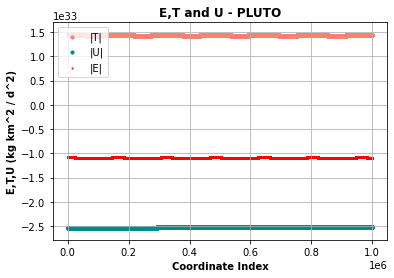

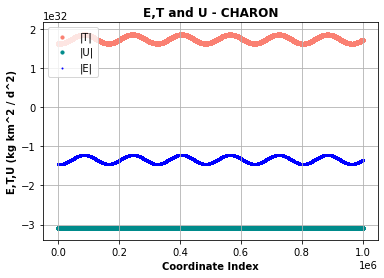

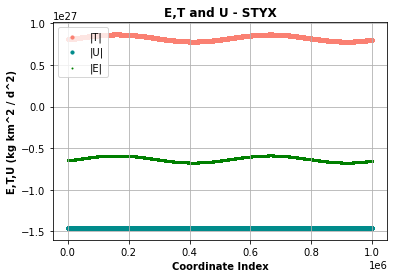

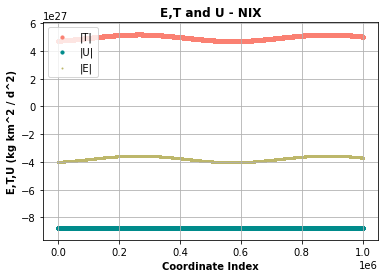

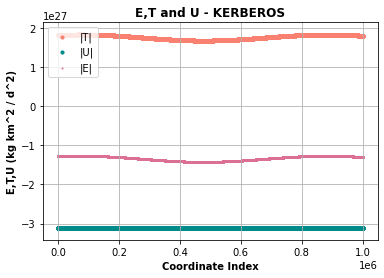

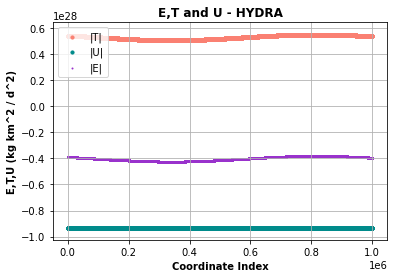

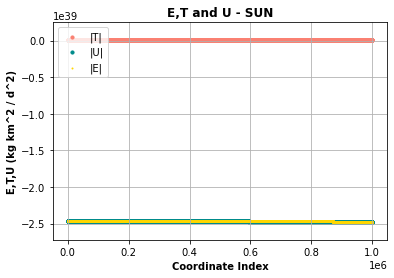

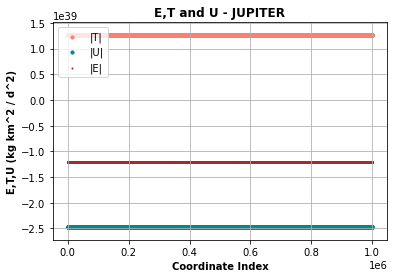

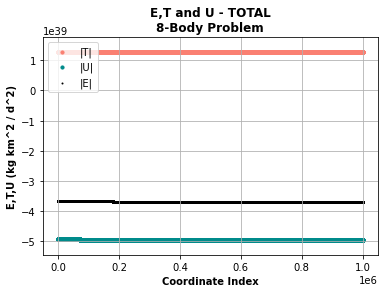

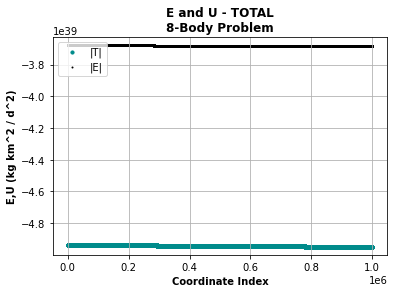

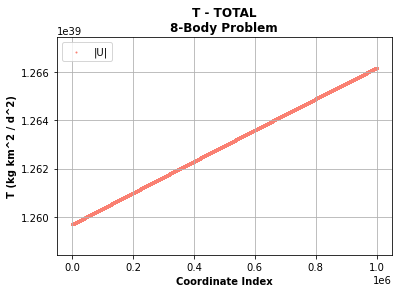

In [50]:
#-------------------------------------------------------------------------------------------------------------------------------
#Averages for each body´s energy.
print("ENERGY AVERAGES:")
print("Pl:      T =" + str(avg(pl_T_RKS)) + "    U = " + str(avg(pl_U_RKS)) + "    E = " +  str(avg(pl_E_RKS)))
print("Ch:      T =" + str(avg(ch_T_RKS)) + "    U = " + str(avg(ch_U_RKS)) + "    E = " +  str(avg(ch_E_RKS)))
print("St:      T =" + str(avg(st_T_RKS)) + "    U = " + str(avg(st_U_RKS)) + "    E = " +  str(avg(st_E_RKS)))
print("Ni:      T =" + str(avg(ni_T_RKS)) + "    U = " + str(avg(ni_U_RKS)) + "    E = " +  str(avg(ni_E_RKS)))
print("Ke:      T =" + str(avg(ke_T_RKS)) + "    U = " + str(avg(ke_U_RKS)) + "    E = " +  str(avg(ke_E_RKS)))
print("Hy:      T =" + str(avg(hy_T_RKS)) + "    U = " + str(avg(hy_U_RKS)) + "    E = " +  str(avg(hy_E_RKS)))
print("Sun:     T =" + str(avg(sun_T_RKS)) + "    U = " + str(avg(sun_U_RKS)) + "    E = " +  str(avg(sun_E_RKS)))
print("Jup:     T =" + str(avg(jup_T_RKS)) + "    U = " + str(avg(jup_U_RKS)) + "    E = " +  str(avg(jup_E_RKS)))
print("Total:   T =" + str(avg(T_t_RKS))  + "    U = " + str(avg(U_t_RKS))  + "    E = " +  str(avg(E_t_RKS)))

#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#Plotting each body's energy.
plot_E_RKS("PLUTO",    pl_T_RKS, pl_U_RKS, pl_E_RKS, col_pl)
plot_E_RKS("CHARON",   ch_T_RKS, ch_U_RKS, ch_E_RKS, col_ch)
plot_E_RKS("STYX",     st_T_RKS, st_U_RKS, st_E_RKS, col_st)
plot_E_RKS("NIX",      ni_T_RKS, ni_U_RKS, ni_E_RKS, col_ni)
plot_E_RKS("KERBEROS", ke_T_RKS, ke_U_RKS, ke_E_RKS, col_ke)
plot_E_RKS("HYDRA",    hy_T_RKS, hy_U_RKS, hy_E_RKS, col_hy)
plot_E_RKS("SUN",      sun_T_RKS, sun_U_RKS, sun_E_RKS, col_sun)
plot_E_RKS("JUPITER",  jup_T_RKS, jup_U_RKS, jup_E_RKS, col_jup)


#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the PLS's total energy.
fig = plt.figure()
ax1 = fig.add_subplot(111)  
ax1.scatter(range(len(T_t_RKS)), T_t_RKS, c="salmon", s=10, label="|T|")
ax1.scatter(range(len(U_t_RKS)), U_t_RKS, c="darkcyan", s=10, label="|U|")
ax1.scatter(range(len(E_t_RKS)), E_t_RKS, c="black", s=1, label="|E|")
plt.title("E,T and U - TOTAL\n8-Body Problem", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("E,T,U (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
lim_inf = min(np.array([min(E_t_RKS), min(T_t_RKS), min(U_t_RKS)]))
lim_sup = max(np.array([max(E_t_RKS), max(T_t_RKS), max(U_t_RKS)]))
extra = max(np.array([abs(lim_inf), abs(lim_sup)]))
plt.ylim([lim_inf - extra/10, lim_sup + extra/10])
plt.show()

#Zoom to the complete and potential energy of the complete PLS.
fig = plt.figure()
ax1 = fig.add_subplot(111)  
ax1.scatter(range(len(U_t_RKS)), U_t_RKS, c="darkcyan", s=10, label="|T|")
ax1.scatter(range(len(E_t_RKS)), E_t_RKS, c="black", s=1, label="|E|")
plt.title("E and U - TOTAL\n8-Body Problem", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("E,U (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
lim_inf = min(np.array([min(E_t_RKS), min(U_t_RKS)]))
lim_sup = max(np.array([max(E_t_RKS), max(U_t_RKS)]))
extra = max(np.array([abs(lim_inf), abs(lim_sup)]))
plt.ylim([lim_inf - extra/100, lim_sup + extra/100])
plt.show()

#Zoom to the kinetic energy of the complete PLS.
fig = plt.figure()
ax1 = fig.add_subplot(111)  
ax1.scatter(range(len(T_t_RKS)), T_t_RKS, c="salmon", s=1, label="|U|")
plt.title("T - TOTAL\n8-Body Problem", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("T (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(T_t_RKS) - abs(min(T_t_RKS)/1000), max(T_t_RKS) + abs(max(T_t_RKS)/1000)])
plt.show()


## Model 6: Oblate Pl, Ch and Jup (8-Body Problem)

##### We retake the consideration of some bodies as oblate spheroids (Pluto, Charon and now Jupiter). All other bodies are considered spherical.

### Generating the Data - Oblate Pl, Ch and Jup (8-Body Problem)

In [81]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Universal Gravitational Constant (days).
G = 4.982174e-10  #(km^3 / kg d^2)

#-------------------------------------------------------------------------------------------------------------------------------
#Function for the acceleration of the moons (with Pl, Ch and Jup as oblates).
def func_8BP_OPCJ_m(A, Ainv, Ajup, Ajupinv, rpl, rch, rjup, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8, m2, m3, m4, m5, m6, m7, m8):
    
    mu = G*pl_m     # Mass gravitational constant (Pluto).
    
    rn = Ainv.dot(rpl)                    # The position vector from Pluto is calculated.
    rm = mag(rn[0], rn[1], rn[2])         # Distance between bodies.
    ru = unitary(rn[0], rn[1], rn[2])     # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_pl)*(mu/(rm**2))*((r_eq_pl/rm)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_pl)*(mu/(rm**2))*((r_eq_pl/rm)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_pl)*(mu/(rm**2))*((r_eq_pl/rm)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    
    a_p_pl = A.dot([ax_p, ay_p, az_p])   # The perturbative term is stored in an array.
    
    mu = G*ch_m    # Mass gravitational constant (Charon).
    
    rn = Ainv.dot(rch)                    # The position vector from Charon is calculated.
    rm = mag(rn[0], rn[1], rn[2])         # Distance between bodies.
    ru = unitary(rn[0], rn[1], rn[2])     # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_ch)*(mu/(rm**2))*((r_eq_ch/rm)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch)*(mu/(rm**2))*((r_eq_ch/rm)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch)*(mu/(rm**2))*((r_eq_ch/rm)**2)*(3 - 5*(ru[2]**2))*ru[2]
    
    a_p_ch = A.dot([ax_p, ay_p, az_p])
    
    mu = G*jup_m    # Mass gravitational constant (Jupiter).
    
    rn = Ajupinv.dot(rjup)                # The position vector from Jupiter is calculated.
    rm = mag(rn[0], rn[1], rn[2])         # Distance between bodies.
    ru = unitary(rn[0], rn[1], rn[2])     # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_jup)*(mu/(rm**2))*((r_eq_jup/rm)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup)*(mu/(rm**2))*((r_eq_jup/rm)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup)*(mu/(rm**2))*((r_eq_jup/rm)**2)*(3 - 5*(ru[2]**2))*ru[2]
    
    a_p_jup = Ajup.dot([ax_p, ay_p, az_p])

    d12 = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    d13 = math.sqrt((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2)   # Distances between all bodies.
    d14 = math.sqrt((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2)
    d15 = math.sqrt((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2)
    d16 = math.sqrt((x6 - x1)**2 + (y6 - y1)**2 + (z6 - z1)**2)
    d17 = math.sqrt((x7 - x1)**2 + (y7 - y1)**2 + (z7 - z1)**2)
    d18 = math.sqrt((x8 - x1)**2 + (y8 - y1)**2 + (z8 - z1)**2)


    # The acceleration according to a 8-body problem is calculated.
    ax = (((G*m2) / (d12**3))*(x2 - x1)) + (((G*m3) / (d13**3))*(x3 - x1)) + (((G*m4) / (d14**3))*(x4 - x1)) + (((G*m5) / (d15**3))*(x5 - x1)) + (((G*m6) / (d16**3))*(x6 - x1)) + (((G*m7) / (d17**3))*(x7 - x1)) + (((G*m8) / (d18**3))*(x8 - x1))
    ay = (((G*m2) / (d12**3))*(y2 - y1)) + (((G*m3) / (d13**3))*(y3 - y1)) + (((G*m4) / (d14**3))*(y4 - y1)) + (((G*m5) / (d15**3))*(y5 - y1)) + (((G*m6) / (d16**3))*(y6 - y1)) + (((G*m7) / (d17**3))*(y7 - y1)) + (((G*m8) / (d18**3))*(y8 - y1))
    az = (((G*m2) / (d12**3))*(z2 - z1)) + (((G*m3) / (d13**3))*(z3 - z1)) + (((G*m4) / (d14**3))*(z4 - z1)) + (((G*m5) / (d15**3))*(z5 - z1)) + (((G*m6) / (d16**3))*(z6 - z1)) + (((G*m7) / (d17**3))*(z7 - z1)) + (((G*m8) / (d18**3))*(z8 - z1))
    
    ax = ax + a_p_pl[0] + a_p_ch[0] + a_p_jup[0]
    ay = ay + a_p_pl[1] + a_p_ch[1] + a_p_jup[0]    # Adding the perturbative terms.
    az = az + a_p_pl[2] + a_p_ch[2] + a_p_jup[0]

    return ax, ay, az

#Function for the acceleration for Pluto, considering Pluto, Charon and Jupiter as oblates.
def func_8BP_OPCJ_pl(A, Ainv, Ajup, Ajupinv, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8):
    d12 = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    d13 = math.sqrt((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2)   # Distances between all bodies.
    d14 = math.sqrt((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2)
    d15 = math.sqrt((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2)
    d16 = math.sqrt((x6 - x1)**2 + (y6 - y1)**2 + (z6 - z1)**2)
    d17 = math.sqrt((x7 - x1)**2 + (y7 - y1)**2 + (z7 - z1)**2)
    d18 = math.sqrt((x8 - x1)**2 + (y8 - y1)**2 + (z8 - z1)**2)

    # The acceleration according to a 8-body problem is calculated.
    ax = (((G*ch_m) / (d12**3))*(x2 - x1)) + (((G*st_m) / (d13**3))*(x3 - x1)) + (((G*ni_m) / (d14**3))*(x4 - x1)) + (((G*ke_m) / (d15**3))*(x5 - x1)) + (((G*hy_m) / (d16**3))*(x6 - x1)) + (((G*sun_m) / (d17**3))*(x7 - x1)) + (((G*jup_m) / (d18**3))*(x8 - x1))
    ay = (((G*ch_m) / (d12**3))*(y2 - y1)) + (((G*st_m) / (d13**3))*(y3 - y1)) + (((G*ni_m) / (d14**3))*(y4 - y1)) + (((G*ke_m) / (d15**3))*(y5 - y1)) + (((G*hy_m) / (d16**3))*(y6 - y1)) + (((G*sun_m) / (d17**3))*(y7 - y1)) + (((G*jup_m) / (d18**3))*(y8 - y1))
    az = (((G*ch_m) / (d12**3))*(z2 - z1)) + (((G*st_m) / (d13**3))*(z3 - z1)) + (((G*ni_m) / (d14**3))*(z4 - z1)) + (((G*ke_m) / (d15**3))*(z5 - z1)) + (((G*hy_m) / (d16**3))*(z6 - z1)) + (((G*sun_m) / (d17**3))*(z7 - z1)) + (((G*jup_m) / (d18**3))*(z8 - z1))    
    
    #Charon.
    mu = G*pl_m*ch_m    # Mass gravitational constant.
    
    rn = Ainv.dot([x2 - x1, y2 - y1, z2 - z1])     # The position vector from Charon is calculated.
    ru = unitary(rn[0], rn[1], rn[2])              # The unitary vector in the radial direction is calculated.
    
    rnch = Ainv.dot([x1 - x2, y1 - y2, z1 - z2])   # The position vector from Pluto is calculated.
    ruch = unitary(rnch[0], rnch[1], rnch[2])      # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_pl = A.dot([ax_p, ay_p, az_p])     # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(1 - 5*(ruch[2]**2))*ruch[0]
    ay_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(1 - 5*(ruch[2]**2))*ruch[1]
    az_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(3 - 5*(ruch[2]**2))*ruch[2]
    a_p_ch = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_pl[0] + a_p_ch[0]
    ay = ay - a_p_pl[1] + a_p_ch[1]    # Adding the perturbative terms.
    az = az - a_p_pl[2] + a_p_ch[2]

    
    #Styx.
    mu = G*pl_m*st_m
    
    rn = Ainv.dot([x3 - x1, y3 - y1, z3 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_pl/st_m)*(mu/(d13**2))*((r_eq_pl/d13)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_pl/st_m)*(mu/(d13**2))*((r_eq_pl/d13)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_pl/st_m)*(mu/(d13**2))*((r_eq_pl/d13)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Nix.
    mu = G*pl_m*ni_m

    rn = Ainv.dot([x4 - x1, y4 - y1, z4 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_pl/ni_m)*(mu/(d14**2))*((r_eq_pl/d14)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_pl/ni_m)*(mu/(d14**2))*((r_eq_pl/d14)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_pl/ni_m)*(mu/(d14**2))*((r_eq_pl/d14)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Kerberos.
    mu = G*pl_m*ke_m
    
    rn = Ainv.dot([x5 - x1, y5 - y1, z5 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_pl/ke_m)*(mu/(d15**2))*((r_eq_pl/d15)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_pl/ke_m)*(mu/(d15**2))*((r_eq_pl/d15)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_pl/ke_m)*(mu/(d15**2))*((r_eq_pl/d15)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]

    
    #Hydra.
    mu = G*pl_m*hy_m
    
    rn = Ainv.dot([x6 - x1, y6 - y1, z6 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_pl/hy_m)*(mu/(d16**2))*((r_eq_pl/d16)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_pl/hy_m)*(mu/(d16**2))*((r_eq_pl/d16)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_pl/hy_m)*(mu/(d16**2))*((r_eq_pl/d16)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]


    #Sun.
    mu = G*pl_m*sun_m
    
    rn = Ainv.dot([x7 - x1, y7 - y1, z7 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_pl/sun_m)*(mu/(d17**2))*((r_eq_pl/d17)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_pl/sun_m)*(mu/(d17**2))*((r_eq_pl/d17)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_pl/sun_m)*(mu/(d17**2))*((r_eq_pl/d17)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Jupiter.
    mu = G*pl_m*jup_m    # Mass gravitational constant.
    
    rn = Ainv.dot([x8 - x1, y8 - y1, z8 - z1])     # The position vector from Jupiter is calculated.
    ru = unitary(rn[0], rn[1], rn[2])              # The unitary vector in the radial direction is calculated.
    
    rnjup = Ajupinv.dot([x1 - x8, y1 - y8, z1 - z8])   # The position vector from Pluto is calculated.
    rujup = unitary(rnjup[0], rnjup[1], rnjup[2])      # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_pl/jup_m)*(mu/(d18**2))*((r_eq_pl/d18)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_pl/jup_m)*(mu/(d18**2))*((r_eq_pl/d18)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_pl/jup_m)*(mu/(d18**2))*((r_eq_pl/d18)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_pl = A.dot([ax_p, ay_p, az_p])     # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_jup/pl_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(rujup[2]**2))*rujup[0]
    ay_p = - (3/2)*(J2_jup/pl_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(rujup[2]**2))*rujup[1]
    az_p = - (3/2)*(J2_jup/pl_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(3 - 5*(rujup[2]**2))*rujup[2]
    a_p_jup = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_pl[0] + a_p_jup[0]
    ay = ay - a_p_pl[1] + a_p_jup[1]    # Adding the perturbative terms.
    az = az - a_p_pl[2] + a_p_jup[2]

    
    return ax, ay, az

#Function for the acceleration for Charon, considering Pluto, Charon and Jupiter as oblates.
def func_8BP_OPCJ_ch(A, Ainv, Ajup, Ajupinv, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8):
    d12 = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    d13 = math.sqrt((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2)   # Distances between all bodies.
    d14 = math.sqrt((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2)
    d15 = math.sqrt((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2)
    d16 = math.sqrt((x6 - x1)**2 + (y6 - y1)**2 + (z6 - z1)**2)
    d17 = math.sqrt((x7 - x1)**2 + (y7 - y1)**2 + (z7 - z1)**2)
    d18 = math.sqrt((x8 - x1)**2 + (y8 - y1)**2 + (z8 - z1)**2)

    # The acceleration according to a 8-body problem is calculated.
    ax = (((G*pl_m) / (d12**3))*(x2 - x1)) + (((G*st_m) / (d13**3))*(x3 - x1)) + (((G*ni_m) / (d14**3))*(x4 - x1)) + (((G*ke_m) / (d15**3))*(x5 - x1)) + (((G*hy_m) / (d16**3))*(x6 - x1)) + (((G*sun_m) / (d17**3))*(x7 - x1)) + (((G*jup_m) / (d18**3))*(x8 - x1))
    ay = (((G*pl_m) / (d12**3))*(y2 - y1)) + (((G*st_m) / (d13**3))*(y3 - y1)) + (((G*ni_m) / (d14**3))*(y4 - y1)) + (((G*ke_m) / (d15**3))*(y5 - y1)) + (((G*hy_m) / (d16**3))*(y6 - y1)) + (((G*sun_m) / (d17**3))*(y7 - y1)) + (((G*jup_m) / (d18**3))*(y8 - y1))
    az = (((G*pl_m) / (d12**3))*(z2 - z1)) + (((G*st_m) / (d13**3))*(z3 - z1)) + (((G*ni_m) / (d14**3))*(z4 - z1)) + (((G*ke_m) / (d15**3))*(z5 - z1)) + (((G*hy_m) / (d16**3))*(z6 - z1)) + (((G*sun_m) / (d17**3))*(z7 - z1)) + (((G*jup_m) / (d18**3))*(z8 - z1))
    
    
    #Pluto.
    mu = G*ch_m*pl_m    # Mass gravitational constant.
    
    rn = Ainv.dot([x2 - x1, y2 - y1, z2 - z1])     # The position vector from Pluto is calculated.
    ru = unitary(rn[0], rn[1], rn[2])              # The unitary vector in the radial direction is calculated.
    
    rnpl = Ainv.dot([x1 - x2, y1 - y2, z1 - z2])   # The position vector from Charon is calculated.
    rupl = unitary(rnpl[0], rnpl[1], rnpl[2])      # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_ch/pl_m)*(mu/(d12**2))*((r_eq_ch/d12)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_ch = A.dot([ax_p, ay_p, az_p])   # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(1 - 5*(rupl[2]**2))*rupl[0]
    ay_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(1 - 5*(rupl[2]**2))*rupl[1]
    az_p = - (3/2)*(J2_pl/ch_m)*(mu/(d12**2))*((r_eq_pl/d12)**2)*(3 - 5*(rupl[2]**2))*rupl[2]
    a_p_pl = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_ch[0] + a_p_pl[0]
    ay = ay - a_p_ch[1] + a_p_pl[1]    # Adding the perturbative terms.
    az = az - a_p_ch[2] + a_p_pl[2]

    
    #Styx.
    mu = G*ch_m*st_m
    
    rn = Ainv.dot([x3 - x1, y3 - y1, z3 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_ch/st_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch/st_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch/st_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Nix
    mu = G*ch_m*ni_m

    rn = Ainv.dot([x4 - x1, y4 - y1, z4 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_ch/ni_m)*(mu/(d14**2))*((r_eq_ch/d14)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch/ni_m)*(mu/(d14**2))*((r_eq_ch/d14)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch/ni_m)*(mu/(d14**2))*((r_eq_ch/d14)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Kerberos
    mu = G*ch_m*ke_m
    
    rn = Ainv.dot([x5 - x1, y5 - y1, z5 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_ch/ke_m)*(mu/(d15**2))*((r_eq_ch/d15)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch/ke_m)*(mu/(d15**2))*((r_eq_ch/d15)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch/ke_m)*(mu/(d15**2))*((r_eq_ch/d15)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]

    
    #Hydra.
    mu = G*ch_m*hy_m
    
    rn = Ainv.dot([x6 - x1, y6 - y1, z6 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_ch/hy_m)*(mu/(d16**2))*((r_eq_ch/d16)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch/hy_m)*(mu/(d16**2))*((r_eq_ch/d16)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch/hy_m)*(mu/(d16**2))*((r_eq_ch/d16)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Sun.
    mu = G*ch_m*sun_m
    
    rn = Ainv.dot([x7 - x1, y7 - y1, z7 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_ch/sun_m)*(mu/(d17**2))*((r_eq_ch/d17)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_ch/sun_m)*(mu/(d17**2))*((r_eq_ch/d17)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_ch/sun_m)*(mu/(d17**2))*((r_eq_ch/d17)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Jupiter.
    mu = G*ch_m*jup_m    # Mass gravitational constant.
    
    rn = Ainv.dot([x8 - x1, y8 - y1, z8 - z1])     # The position vector from Charon is calculated.
    ru = unitary(rn[0], rn[1], rn[2])              # The unitary vector in the radial direction is calculated.
    
    rnjup = Ajupinv.dot([x1 - x8, y1 - y8, z1 - z8])     # The position vector from Jupiter is calculated.
    rujup = unitary(rnjup[0], rnjup[1], rnjup[2])        # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_ch/jup_m)*(mu/(d18**2))*((r_eq_ch/d18)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_ch/jup_m)*(mu/(d18**2))*((r_eq_ch/d18)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_ch/jup_m)*(mu/(d18**2))*((r_eq_ch/d18)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_ch = A.dot([ax_p, ay_p, az_p])   # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_jup/ch_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(rupl[2]**2))*rujup[0]
    ay_p = - (3/2)*(J2_jup/ch_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(rupl[2]**2))*rujup[1]
    az_p = - (3/2)*(J2_jup/ch_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(3 - 5*(rupl[2]**2))*rujup[2]
    a_p_jup = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_ch[0] + a_p_jup[0]
    ay = ay - a_p_ch[1] + a_p_jup[1]    # Adding the perturbative terms.
    az = az - a_p_ch[2] + a_p_jup[2]

        
    return ax, ay, az

#Función de la aceleración con Pl, Ca y Jup oblatos (Prob. de 8 Cuerpos) para Júpiter.
def func_8BP_OPCJ_jup(A, Ainv, Ajup, Ajupinv, x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, x5, y5, z5, x6, y6, z6, x7, y7, z7, x8, y8, z8):
    d12 = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    d13 = math.sqrt((x3 - x1)**2 + (y3 - y1)**2 + (z3 - z1)**2)   # Distances between all bodies.
    d14 = math.sqrt((x4 - x1)**2 + (y4 - y1)**2 + (z4 - z1)**2)
    d15 = math.sqrt((x5 - x1)**2 + (y5 - y1)**2 + (z5 - z1)**2)
    d16 = math.sqrt((x6 - x1)**2 + (y6 - y1)**2 + (z6 - z1)**2)
    d17 = math.sqrt((x7 - x1)**2 + (y7 - y1)**2 + (z7 - z1)**2)
    d18 = math.sqrt((x8 - x1)**2 + (y8 - y1)**2 + (z8 - z1)**2)

    # The acceleration according to a 8-body problem is calculated.
    ax = (((G*pl_m) / (d12**3))*(x2 - x1)) + (((G*st_m) / (d13**3))*(x3 - x1)) + (((G*ni_m) / (d14**3))*(x4 - x1)) + (((G*ke_m) / (d15**3))*(x5 - x1)) + (((G*hy_m) / (d16**3))*(x6 - x1)) + (((G*sun_m) / (d17**3))*(x7 - x1)) + (((G*jup_m) / (d18**3))*(x8 - x1))
    ay = (((G*pl_m) / (d12**3))*(y2 - y1)) + (((G*st_m) / (d13**3))*(y3 - y1)) + (((G*ni_m) / (d14**3))*(y4 - y1)) + (((G*ke_m) / (d15**3))*(y5 - y1)) + (((G*hy_m) / (d16**3))*(y6 - y1)) + (((G*sun_m) / (d17**3))*(y7 - y1)) + (((G*jup_m) / (d18**3))*(y8 - y1))
    az = (((G*pl_m) / (d12**3))*(z2 - z1)) + (((G*st_m) / (d13**3))*(z3 - z1)) + (((G*ni_m) / (d14**3))*(z4 - z1)) + (((G*ke_m) / (d15**3))*(z5 - z1)) + (((G*hy_m) / (d16**3))*(z6 - z1)) + (((G*sun_m) / (d17**3))*(z7 - z1)) + (((G*jup_m) / (d18**3))*(z8 - z1))
    
    
    #Pluto.
    mu = G*jup_m*pl_m    # Mass gravitational constant.
    
    rn = Ajupinv.dot([x2 - x1, y2 - y1, z2 - z1])     # The position vector from Pluto is calculated.
    ru = unitary(rn[0], rn[1], rn[2])                 # The unitary vector in the radial direction is calculated.
    
    rnpl = Ainv.dot([x1 - x2, y1 - y2, z1 - z2])     # The position vector from Jupiter is calculated.
    rupl = unitary(rnpl[0], rnpl[1], rnpl[2])        # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_jup/pl_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_jup/pl_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_jup/pl_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_pl = Ajup.dot([ax_p, ay_p, az_p])   # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_pl/jup_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(1 - 5*(rupl[2]**2))*rupl[0]
    ay_p = - (3/2)*(J2_pl/jup_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(1 - 5*(rupl[2]**2))*rupl[1]
    az_p = - (3/2)*(J2_pl/jup_m)*(mu/(d12**2))*((r_eq_jup/d12)**2)*(3 - 5*(rupl[2]**2))*rupl[2]
    a_p_jup = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_pl[0] + a_p_jup[0]
    ay = ay - a_p_pl[1] + a_p_jup[1]    # Adding the perturbative terms.
    az = az - a_p_pl[2] + a_p_jup[2]
    
    
    #Charon.
    mu = G*jup_m*ch_m    # Mass gravitational constant.
    
    rn = Ajupinv.dot([x3 - x1, y3 - y1, z3 - z1])    # The position vector from Charon is calculated.
    ru = unitary(rn[0], rn[1], rn[2])                # The unitary vector in the radial direction is calculated.
    
    rnch = Ainv.dot([x1 - x3, y1 - y3, z1 - z3])     # The position vector from Jupiter is calculated.
    ruch = unitary(rnch[0], rnch[1], rnch[2])        # The unitary vector in the radial direction is calculated.
    
    ax_p = - (3/2)*(J2_ch/jup_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ru[2]**2))*ru[0]    # The perturbative terms are
    ay_p = - (3/2)*(J2_ch/jup_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ru[2]**2))*ru[1]    # calculated for each
    az_p = - (3/2)*(J2_ch/jup_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(3 - 5*(ru[2]**2))*ru[2]    # component.
    a_p_ch = Ajup.dot([ax_p, ay_p, az_p])   # The perturbative term is stored in an array.
    
    ax_p = - (3/2)*(J2_jup/ch_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ruch[2]**2))*ruch[0]
    ay_p = - (3/2)*(J2_jup/ch_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(1 - 5*(ruch[2]**2))*ruch[1]
    az_p = - (3/2)*(J2_jup/ch_m)*(mu/(d13**2))*((r_eq_ch/d13)**2)*(3 - 5*(ruch[2]**2))*ruch[2]
    a_p_jup = A.dot([ax_p, ay_p, az_p])

    ax = ax - a_p_ch[0] + a_p_jup[0]
    ay = ay - a_p_ch[1] + a_p_jup[1]    # Adding the perturbative terms.
    az = az - a_p_ch[2] + a_p_jup[2]

    
    #Styx.
    mu = G*jup_m*st_m
    
    rn = Ajupinv.dot([x4 - x1, y4 - y1, z4 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_jup/st_m)*(mu/(d14**2))*((r_eq_jup/d14)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup/st_m)*(mu/(d14**2))*((r_eq_jup/d14)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup/st_m)*(mu/(d14**2))*((r_eq_jup/d14)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Nix.
    mu = G*jup_m*ni_m

    rn = Ajupinv.dot([x5 - x1, y5 - y1, z5 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_jup/ni_m)*(mu/(d15**2))*((r_eq_jup/d15)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup/ni_m)*(mu/(d15**2))*((r_eq_jup/d15)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup/ni_m)*(mu/(d15**2))*((r_eq_jup/d15)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Kerberos.
    mu = G*jup_m*ke_m
    
    rn = Ajupinv.dot([x6 - x1, y6 - y1, z6 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_jup/ke_m)*(mu/(d16**2))*((r_eq_jup/d16)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup/ke_m)*(mu/(d16**2))*((r_eq_jup/d16)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup/ke_m)*(mu/(d16**2))*((r_eq_jup/d16)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]

    
    #Hydra.
    mu = G*jup_m*hy_m
    
    rn = Ajupinv.dot([x7 - x1, y7 - y1, z7 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_jup/hy_m)*(mu/(d17**2))*((r_eq_jup/d17)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup/hy_m)*(mu/(d17**2))*((r_eq_jup/d17)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup/hy_m)*(mu/(d17**2))*((r_eq_jup/d17)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    
    
    #Sun.
    mu = G*jup_m*sun_m
    
    rn = Ajupinv.dot([x8 - x1, y8 - y1, z8 - z1])
    ru = unitary(rn[0], rn[1], rn[2])
    
    ax_p = - (3/2)*(J2_jup/sun_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(ru[2]**2))*ru[0]
    ay_p = - (3/2)*(J2_jup/sun_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(1 - 5*(ru[2]**2))*ru[1]
    az_p = - (3/2)*(J2_jup/sun_m)*(mu/(d18**2))*((r_eq_jup/d18)**2)*(3 - 5*(ru[2]**2))*ru[2]
    a_p = Ajup.dot([ax_p, ay_p, az_p])

    ax = ax - a_p[0]
    ay = ay - a_p[1]
    az = az - a_p[2]
    

    return ax, ay, az

#-------------------------------------------------------------------------------------------------------------------------------
#Function to get the unitary vector.
def unitary(x, y, z):
    d = mag(x, y, z)
    return ([x/d, y/d, z/d])

#Function for the scalar product.
def prod_dot(vec1, vec2):
    return (vec1[0]*vec2[0]) + (vec1[1]*vec2[1]) + (vec1[2]*vec2[2])

#Function for the vector product.
def prod_cross(vec1, vec2):
    x = (vec1[1]*vec2[2] - vec1[2]*vec2[1])
    y = (vec1[2]*vec2[0] - vec1[0]*vec2[2])
    z = (vec1[0]*vec2[1] - vec1[1]*vec2[0])
    r = mag(x, y, z)
    return ([x, y, z, r])

#-------------------------------------------------------------------------------------------------------------------------------
#Function to generate a new reference system whose XY plane is aligned with the body's equator.
def plane_equator(RA, dec):
    RA = deg_rad(RA)      # Converting to radians.
    dec = deg_rad(dec)

    #Generating the coordinate system aligned to the equator.
    n = ([math.sin(dec)*math.cos(RA), math.sin(dec)*math.sin(RA), math.cos(dec), 1])    # Generating new "z" axis.
    
    xp = ([0.5, 0.5, (-n[0]/n[2])*0.5 + (-n[1]/n[2])*0.5])    # Generating new arbitrary "x" axis.
    xp = np.append(xp, mag(xp[0], xp[1], xp[2]))
    xp = xp/xp[3]
    yp = prod_cross(n, xp)                                     # Generating new "y" axis from the other two axes.
    A = ([[xp[0], yp[0], n[0]], [xp[1], yp[1], n[1]], [xp[2], yp[2], n[2]]])  # Transformation matrix.
    Ainv = np.linalg.inv(A)                                                   # Inverse transformation matrix.
    
    return A, Ainv

#Function to convert from degrees to radians.
def deg_rad(ang):
    return ang*math.pi/180

#Function to convert from radians to degrees.
def rad_deg(ang):
    return ang*180/math.pi


In [82]:
#-------------------------------------------------------------------------------------------------------------------------------
#Universal Gravitational Constant (days).
G = 4.982174e-10  #(km^3 / kg d^2)

#-------------------------------------------------------------------------------------------------------------------------------
#Transformation matrices for the new system whose XY plane aligns with the body's equator.
A_pl, Ainv_pl = plane_equator(RA_pl, dec_pl)
A_pl, Ainv_pl = np.array(A_pl), np.array(Ainv_pl)

A_ch, Ainv_ch = plane_equator(RA_ch, dec_ch)
A_ch, Ainv_ch = np.array(A_ch), np.array(Ainv_ch)

A_jup, Ainv_jup = plane_equator(RA_jup, dec_jup)
A_jup, Ainv_jup = np.array(A_jup), np.array(Ainv_jup)

#-------------------------------------------------------------------------------------------------------------------------------
#Step settings.

N = 1000000      # Amount of iterations.
a = 0            # Initial time = 0.
b = 40           # Amount of days.

h_RKS2 = (b-a)/N      # Step.

t_RKS2 = np.empty((N+1), float)
t_RKS2[0] = a        # Array to store time.

#-------------------------------------------------------------------------------------------------------------------------------
#Declaring the arrays.

#Coordinates from PLS's barycenter reference system.
pl_x_RKS2, pl_y_RKS2, pl_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_x_RKS2, ch_y_RKS2, ch_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_x_RKS2, st_y_RKS2, st_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_x_RKS2, ni_y_RKS2, ni_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_x_RKS2, ke_y_RKS2, ke_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_x_RKS2, hy_y_RKS2, hy_z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

#Coordinates and velocities from the solar system's barycenter reference system.
pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_X_RKS2, st_Y_RKS2, st_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_X_RKS2, ni_Y_RKS2, ni_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_X_RKS2, ke_Y_RKS2, ke_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_X_RKS2, hy_Y_RKS2, hy_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
sun_X_RKS2, sun_Y_RKS2, sun_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
bary_X_RKS2, bary_Y_RKS2, bary_Z_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

pl_VX_RKS2, pl_VY_RKS2, pl_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ch_VX_RKS2, ch_VY_RKS2, ch_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
st_VX_RKS2, st_VY_RKS2, st_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ni_VX_RKS2, ni_VY_RKS2, ni_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
ke_VX_RKS2, ke_VY_RKS2, ke_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
hy_VX_RKS2, hy_VY_RKS2, hy_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
sun_VX_RKS2, sun_VY_RKS2, sun_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)
jup_VX_RKS2, jup_VY_RKS2, jup_VZ_RKS2 = np.empty((N+1), float), np.empty((N+1), float), np.empty((N+1), float)

#-------------------------------------------------------------------------------------------------------------------------------
#Initial Coordinates (00:00:00 1/Ene/2021).

#Initial positions (solar system's barycenter reference system.).
pl_X_RKS2[0], pl_Y_RKS2[0], pl_Z_RKS2[0] = pl_R[0,0], pl_R[0,1], pl_R[0,2]
ch_X_RKS2[0], ch_Y_RKS2[0], ch_Z_RKS2[0] = ch_R[0,0], ch_R[0,1], ch_R[0,2]
st_X_RKS2[0], st_Y_RKS2[0], st_Z_RKS2[0] = st_R[0,0], st_R[0,1], st_R[0,2]
ni_X_RKS2[0], ni_Y_RKS2[0], ni_Z_RKS2[0] = ni_R[0,0], ni_R[0,1], ni_R[0,2]
ke_X_RKS2[0], ke_Y_RKS2[0], ke_Z_RKS2[0] = ke_R[0,0], ke_R[0,1], ke_R[0,2]
hy_X_RKS2[0], hy_Y_RKS2[0], hy_Z_RKS2[0] = hy_R[0,0], hy_R[0,1], hy_R[0,2]
sun_X_RKS2[0], sun_Y_RKS2[0], sun_Z_RKS2[0] = sun_R[0,0], sun_R[0,1], sun_R[0,2]
jup_X_RKS2[0], jup_Y_RKS2[0], jup_Z_RKS2[0] = jup_R[0,0], jup_R[0,1], jup_R[0,2]
bary_X_RKS2[0], bary_Y_RKS2[0], bary_Z_RKS2[0] = bary_R[0,0], bary_R[0,1], bary_R[0,2]

#Initial positions (PLS's barycenter reference system).
pl_x_RKS2[0], pl_y_RKS2[0], pl_z_RKS2[0] = pl_R[0,0] - bary_R[0,0], pl_R[0,1] - bary_R[0,1], pl_R[0,2] - bary_R[0,2]
ch_x_RKS2[0], ch_y_RKS2[0], ch_z_RKS2[0] = ch_R[0,0] - bary_R[0,0], ch_R[0,1] - bary_R[0,1], ch_R[0,2] - bary_R[0,2]
st_x_RKS2[0], st_y_RKS2[0], st_z_RKS2[0] = st_R[0,0] - bary_R[0,0], st_R[0,1] - bary_R[0,1], st_R[0,2] - bary_R[0,2]
ni_x_RKS2[0], ni_y_RKS2[0], ni_z_RKS2[0] = ni_R[0,0] - bary_R[0,0], ni_R[0,1] - bary_R[0,1], ni_R[0,2] - bary_R[0,2]
ke_x_RKS2[0], ke_y_RKS2[0], ke_z_RKS2[0] = ke_R[0,0] - bary_R[0,0], ke_R[0,1] - bary_R[0,1], ke_R[0,2] - bary_R[0,2]
hy_x_RKS2[0], hy_y_RKS2[0], hy_z_RKS2[0] = hy_R[0,0] - bary_R[0,0], hy_R[0,1] - bary_R[0,1], hy_R[0,2] - bary_R[0,2]

#Initial velocities.
n = 86400   # Converting from sec. to days.

pl_VX_RKS2[0], pl_VY_RKS2[0], pl_VZ_RKS2[0] = n*pl_V[0,0], n*pl_V[0,1], n*pl_V[0,2]
ch_VX_RKS2[0], ch_VY_RKS2[0], ch_VZ_RKS2[0] = n*ch_V[0,0], n*ch_V[0,1], n*ch_V[0,2]
st_VX_RKS2[0], st_VY_RKS2[0], st_VZ_RKS2[0] = n*st_V[0,0], n*st_V[0,1], n*st_V[0,2]
ni_VX_RKS2[0], ni_VY_RKS2[0], ni_VZ_RKS2[0] = n*ni_V[0,0], n*ni_V[0,1], n*ni_V[0,2]
ke_VX_RKS2[0], ke_VY_RKS2[0], ke_VZ_RKS2[0] = n*ke_V[0,0], n*ke_V[0,1], n*ke_V[0,2]
hy_VX_RKS2[0], hy_VY_RKS2[0], hy_VZ_RKS2[0] = n*hy_V[0,0], n*hy_V[0,1], n*hy_V[0,2]
sun_VX_RKS2[0], sun_VY_RKS2[0], sun_VZ_RKS2[0] = n*sun_V[0,0], n*sun_V[0,1], n*sun_V[0,2]
jup_VX_RKS2[0], jup_VY_RKS2[0], jup_VZ_RKS2[0] = n*jup_V[0,0], n*jup_V[0,1], n*jup_V[0,2]

#-------------------------------------------------------------------------------------------------------------------------------
#PLS's trajectories loop.
lim = tqdm(range(int(N)), desc="RKS2 Loop: ")
for i in lim:
    
    #POSITIONS:
    
    #Pluto
    
    # Generating the "k" constants for the velocity.
    k1x, k1y, k1z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i] + k1x/2, pl_Y_RKS2[i] + k1y/2, pl_Z_RKS2[i] + k1z/2, ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i] + k2x/2, pl_Y_RKS2[i] + k2y/2, pl_Z_RKS2[i] + k2z/2, ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i] + k3x, pl_Y_RKS2[i] + k3y, pl_Z_RKS2[i] + k3z, ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    # Generating the new value for the velocity.
    pl_VX_RKS2[i+1] = pl_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_VY_RKS2[i+1] = pl_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_VZ_RKS2[i+1] = pl_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    # Generating the "k" constants for the position.
    k1x, k1y, k1z = h_RKS2*pl_VX_RKS2[i], h_RKS2*pl_VY_RKS2[i], h_RKS2*pl_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(pl_VX_RKS2[i] + k1x/2), h_RKS2*(pl_VY_RKS2[i] + k1y/2), h_RKS2*(pl_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(pl_VX_RKS2[i] + k2x/2), h_RKS2*(pl_VY_RKS2[i] + k2y/2), h_RKS2*(pl_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(pl_VX_RKS2[i] + k3x), h_RKS2*(pl_VY_RKS2[i] + k3y), h_RKS2*(pl_VZ_RKS2[i] + k3z)

    # Generating the new value for the position.
    pl_X_RKS2[i+1] = pl_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_Y_RKS2[i+1] = pl_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_Z_RKS2[i+1] = pl_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Charon.
    k1x, k1y, k1z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i] + k1x/2, ch_Y_RKS2[i] + k1y/2, ch_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i] + k2x/2, ch_Y_RKS2[i] + k2y/2, ch_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i] + k3x, ch_Y_RKS2[i] + k3y, ch_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ch_VX_RKS2[i+1] = ch_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_VY_RKS2[i+1] = ch_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_VZ_RKS2[i+1] = ch_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*ch_VX_RKS2[i], h_RKS2*ch_VY_RKS2[i], h_RKS2*ch_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(ch_VX_RKS2[i] + k1x/2), h_RKS2*(ch_VY_RKS2[i] + k1y/2), h_RKS2*(ch_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(ch_VX_RKS2[i] + k2x/2), h_RKS2*(ch_VY_RKS2[i] + k2y/2), h_RKS2*(ch_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(ch_VX_RKS2[i] + k3x), h_RKS2*(ch_VY_RKS2[i] + k3y), h_RKS2*(ch_VZ_RKS2[i] + k3z)

    ch_X_RKS2[i+1] = ch_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_Y_RKS2[i+1] = ch_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_Z_RKS2[i+1] = ch_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)

    
    #Styx.
    rpl = ([st_X_RKS2[i] - pl_X_RKS2[i], st_Y_RKS2[i] - pl_Y_RKS2[i], st_Z_RKS2[i] - pl_Z_RKS2[i]])
    rch = ([st_X_RKS2[i] - ch_X_RKS2[i], st_Y_RKS2[i] - ch_Y_RKS2[i], st_Z_RKS2[i] - ch_Z_RKS2[i]])
    rjup = ([st_X_RKS2[i] - jup_X_RKS2[i], st_Y_RKS2[i] - jup_Y_RKS2[i], st_Z_RKS2[i] - jup_Z_RKS2[i]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([st_X_RKS2[i] + k1x/2 - pl_X_RKS2[i], st_Y_RKS2[i] + k1y/2 - pl_Y_RKS2[i], st_Z_RKS2[i] + k1z/2 - pl_Z_RKS2[i]])
    rch = ([st_X_RKS2[i] + k1x/2 - ch_X_RKS2[i], st_Y_RKS2[i] + k1y/2 - ch_Y_RKS2[i], st_Z_RKS2[i] + k1z/2 - ch_Z_RKS2[i]])
    rjup = ([st_X_RKS2[i] + k1x/2 - jup_X_RKS2[i], st_Y_RKS2[i] + k1y/2 - jup_Y_RKS2[i], st_Z_RKS2[i] + k1z/2 - jup_Z_RKS2[i]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i] + k1x/2, st_Y_RKS2[i] + k1y/2, st_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([st_X_RKS2[i] + k2x/2 - pl_X_RKS2[i], st_Y_RKS2[i] + k2y/2 - pl_Y_RKS2[i], st_Z_RKS2[i] + k2z/2 - pl_Z_RKS2[i]])
    rch = ([st_X_RKS2[i] + k2x/2 - ch_X_RKS2[i], st_Y_RKS2[i] + k2y/2 - ch_Y_RKS2[i], st_Z_RKS2[i] + k2z/2 - ch_Z_RKS2[i]])
    rjup = ([st_X_RKS2[i] + k2x/2 - jup_X_RKS2[i], st_Y_RKS2[i] + k2y/2 - jup_Y_RKS2[i], st_Z_RKS2[i] + k2z/2 - jup_Z_RKS2[i]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i] + k2x/2, st_Y_RKS2[i] + k2y/2, st_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([st_X_RKS2[i] + k3x - pl_X_RKS2[i], st_Y_RKS2[i] + k3y - pl_Y_RKS2[i], st_Z_RKS2[i] + k3z - pl_Z_RKS2[i]])
    rch = ([st_X_RKS2[i] + k3x - ch_X_RKS2[i], st_Y_RKS2[i] + k3y - ch_Y_RKS2[i], st_Z_RKS2[i] + k3z - ch_Z_RKS2[i]])
    rjup = ([st_X_RKS2[i] + k3x - jup_X_RKS2[i], st_Y_RKS2[i] + k3y - jup_Y_RKS2[i], st_Z_RKS2[i] + k3z - jup_Z_RKS2[i]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i] + k3x, st_Y_RKS2[i] + k3y, st_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    st_VX_RKS2[i+1] = st_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_VY_RKS2[i+1] = st_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_VZ_RKS2[i+1] = st_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*st_VX_RKS2[i], h_RKS2*st_VY_RKS2[i], h_RKS2*st_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(st_VX_RKS2[i] + k1x/2), h_RKS2*(st_VY_RKS2[i] + k1y/2), h_RKS2*(st_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(st_VX_RKS2[i] + k2x/2), h_RKS2*(st_VY_RKS2[i] + k2y/2), h_RKS2*(st_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(st_VX_RKS2[i] + k3x), h_RKS2*(st_VY_RKS2[i] + k3y), h_RKS2*(st_VZ_RKS2[i] + k3z)

    st_X_RKS2[i+1] = st_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_Y_RKS2[i+1] = st_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_Z_RKS2[i+1] = st_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Nix.
    rpl = ([ni_X_RKS2[i] - pl_X_RKS2[i], ni_Y_RKS2[i] - pl_Y_RKS2[i], ni_Z_RKS2[i] - pl_Z_RKS2[i]])
    rch = ([ni_X_RKS2[i] - ch_X_RKS2[i], ni_Y_RKS2[i] - ch_Y_RKS2[i], ni_Z_RKS2[i] - ch_Z_RKS2[i]])
    rjup = ([ni_X_RKS2[i] - jup_X_RKS2[i], ni_Y_RKS2[i] - jup_Y_RKS2[i], ni_Z_RKS2[i] - jup_Z_RKS2[i]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([ni_X_RKS2[i] + k1x/2 - pl_X_RKS2[i], ni_Y_RKS2[i] + k1y/2 - pl_Y_RKS2[i], ni_Z_RKS2[i] + k1z/2 - pl_Z_RKS2[i]])
    rch = ([ni_X_RKS2[i] + k1x/2 - ch_X_RKS2[i], ni_Y_RKS2[i] + k1y/2 - ch_Y_RKS2[i], ni_Z_RKS2[i] + k1z/2 - ch_Z_RKS2[i]])
    rjup = ([ni_X_RKS2[i] + k1x/2 - jup_X_RKS2[i], ni_Y_RKS2[i] + k1y/2 - jup_Y_RKS2[i], ni_Z_RKS2[i] + k1z/2 - jup_Z_RKS2[i]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i] + k1x/2, ni_Y_RKS2[i] + k1y/2, ni_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([ni_X_RKS2[i] + k2x/2 - pl_X_RKS2[i], ni_Y_RKS2[i] + k2y/2 - pl_Y_RKS2[i], ni_Z_RKS2[i] + k2z/2 - pl_Z_RKS2[i]])
    rch = ([ni_X_RKS2[i] + k2x/2 - ch_X_RKS2[i], ni_Y_RKS2[i] + k2y/2 - ch_Y_RKS2[i], ni_Z_RKS2[i] + k2z/2 - ch_Z_RKS2[i]])
    rjup = ([ni_X_RKS2[i] + k2x/2 - jup_X_RKS2[i], ni_Y_RKS2[i] + k2y/2 - jup_Y_RKS2[i], ni_Z_RKS2[i] + k2z/2 - jup_Z_RKS2[i]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i] + k2x/2, ni_Y_RKS2[i] + k2y/2, ni_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([ni_X_RKS2[i] + k3x - pl_X_RKS2[i], ni_Y_RKS2[i] + k3y - pl_Y_RKS2[i], ni_Z_RKS2[i] + k3z - pl_Z_RKS2[i]])
    rch = ([ni_X_RKS2[i] + k3x - ch_X_RKS2[i], ni_Y_RKS2[i] + k3y - ch_Y_RKS2[i], ni_Z_RKS2[i] + k3z - ch_Z_RKS2[i]])
    rjup = ([ni_X_RKS2[i] + k3x - jup_X_RKS2[i], ni_Y_RKS2[i] + k3y - jup_Y_RKS2[i], ni_Z_RKS2[i] + k3z - jup_Z_RKS2[i]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i] + k3x, ni_Y_RKS2[i] + k3y, ni_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ni_VX_RKS2[i+1] = ni_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_VY_RKS2[i+1] = ni_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_VZ_RKS2[i+1] = ni_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*ni_VX_RKS2[i], h_RKS2*ni_VY_RKS2[i], h_RKS2*ni_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(ni_VX_RKS2[i] + k1x/2), h_RKS2*(ni_VY_RKS2[i] + k1y/2), h_RKS2*(ni_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(ni_VX_RKS2[i] + k2x/2), h_RKS2*(ni_VY_RKS2[i] + k2y/2), h_RKS2*(ni_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(ni_VX_RKS2[i] + k3x), h_RKS2*(ni_VY_RKS2[i] + k3y), h_RKS2*(ni_VZ_RKS2[i] + k3z)

    ni_X_RKS2[i+1] = ni_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_Y_RKS2[i+1] = ni_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_Z_RKS2[i+1] = ni_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Kerberos.
    rpl = ([ke_X_RKS2[i] - pl_X_RKS2[i], ke_Y_RKS2[i] - pl_Y_RKS2[i], ke_Z_RKS2[i] - pl_Z_RKS2[i]])
    rch = ([ke_X_RKS2[i] - ch_X_RKS2[i], ke_Y_RKS2[i] - ch_Y_RKS2[i], ke_Z_RKS2[i] - ch_Z_RKS2[i]])
    rjup = ([ke_X_RKS2[i] - jup_X_RKS2[i], ke_Y_RKS2[i] - jup_Y_RKS2[i], ke_Z_RKS2[i] - jup_Z_RKS2[i]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([ke_X_RKS2[i] + k1x/2 - pl_X_RKS2[i], ke_Y_RKS2[i] + k1y/2 - pl_Y_RKS2[i], ke_Z_RKS2[i] + k1z/2 - pl_Z_RKS2[i]])
    rch = ([ke_X_RKS2[i] + k1x/2 - ch_X_RKS2[i], ke_Y_RKS2[i] + k1y/2 - ch_Y_RKS2[i], ke_Z_RKS2[i] + k1z/2 - ch_Z_RKS2[i]])
    rjup = ([ke_X_RKS2[i] + k1x/2 - jup_X_RKS2[i], ke_Y_RKS2[i] + k1y/2 - jup_Y_RKS2[i], ke_Z_RKS2[i] + k1z/2 - jup_Z_RKS2[i]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i] + k1x/2, ke_Y_RKS2[i] + k1y/2, ke_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([ke_X_RKS2[i] + k2x/2 - pl_X_RKS2[i], ke_Y_RKS2[i] + k2y/2 - pl_Y_RKS2[i], ke_Z_RKS2[i] + k2z/2 - pl_Z_RKS2[i]])
    rch = ([ke_X_RKS2[i] + k2x/2 - ch_X_RKS2[i], ke_Y_RKS2[i] + k2y/2 - ch_Y_RKS2[i], ke_Z_RKS2[i] + k2z/2 - ch_Z_RKS2[i]])
    rjup = ([ke_X_RKS2[i] + k2x/2 - jup_X_RKS2[i], ke_Y_RKS2[i] + k2y/2 - jup_Y_RKS2[i], ke_Z_RKS2[i] + k2z/2 - jup_Z_RKS2[i]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i] + k2x/2, ke_Y_RKS2[i] + k2y/2, ke_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([ke_X_RKS2[i] + k3x - pl_X_RKS2[i], ke_Y_RKS2[i] + k3y - pl_Y_RKS2[i], ke_Z_RKS2[i] + k3z - pl_Z_RKS2[i]])
    rch = ([ke_X_RKS2[i] + k3x - ch_X_RKS2[i], ke_Y_RKS2[i] + k3y - ch_Y_RKS2[i], ke_Z_RKS2[i] + k3z - ch_Z_RKS2[i]])
    rjup = ([ke_X_RKS2[i] + k3x - jup_X_RKS2[i], ke_Y_RKS2[i] + k3y - jup_Y_RKS2[i], ke_Z_RKS2[i] + k3z - jup_Z_RKS2[i]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i] + k3x, ke_Y_RKS2[i] + k3y, ke_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ke_VX_RKS2[i+1] = ke_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_VY_RKS2[i+1] = ke_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_VZ_RKS2[i+1] = ke_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*ke_VX_RKS2[i], h_RKS2*ke_VY_RKS2[i], h_RKS2*ke_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(ke_VX_RKS2[i] + k1x/2), h_RKS2*(ke_VY_RKS2[i] + k1y/2), h_RKS2*(ke_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(ke_VX_RKS2[i] + k2x/2), h_RKS2*(ke_VY_RKS2[i] + k2y/2), h_RKS2*(ke_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(ke_VX_RKS2[i] + k3x), h_RKS2*(ke_VY_RKS2[i] + k3y), h_RKS2*(ke_VZ_RKS2[i] + k3z)

    ke_X_RKS2[i+1] = ke_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_Y_RKS2[i+1] = ke_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_Z_RKS2[i+1] = ke_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Hydra.
    rpl = ([hy_X_RKS2[i] - pl_X_RKS2[i], hy_Y_RKS2[i] - pl_Y_RKS2[i], hy_Z_RKS2[i] - pl_Z_RKS2[i]])
    rch = ([hy_X_RKS2[i] - ch_X_RKS2[i], hy_Y_RKS2[i] - ch_Y_RKS2[i], hy_Z_RKS2[i] - ch_Z_RKS2[i]])
    rjup = ([hy_X_RKS2[i] - jup_X_RKS2[i], hy_Y_RKS2[i] - jup_Y_RKS2[i], hy_Z_RKS2[i] - jup_Z_RKS2[i]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([hy_X_RKS2[i] + k1x/2 - pl_X_RKS2[i], hy_Y_RKS2[i] + k1y/2 - pl_Y_RKS2[i], hy_Z_RKS2[i] + k1z/2 - pl_Z_RKS2[i]])
    rch = ([hy_X_RKS2[i] + k1x/2 - ch_X_RKS2[i], hy_Y_RKS2[i] + k1y/2 - ch_Y_RKS2[i], hy_Z_RKS2[i] + k1z/2 - ch_Z_RKS2[i]])
    rjup = ([hy_X_RKS2[i] + k1x/2 - jup_X_RKS2[i], hy_Y_RKS2[i] + k1y/2 - jup_Y_RKS2[i], hy_Z_RKS2[i] + k1z/2 - jup_Z_RKS2[i]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i] + k1x/2, hy_Y_RKS2[i] + k1y/2, hy_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([hy_X_RKS2[i] + k2x/2 - pl_X_RKS2[i], hy_Y_RKS2[i] + k2y/2 - pl_Y_RKS2[i], hy_Z_RKS2[i] + k2z/2 - pl_Z_RKS2[i]])
    rch = ([hy_X_RKS2[i] + k2x/2 - ch_X_RKS2[i], hy_Y_RKS2[i] + k2y/2 - ch_Y_RKS2[i], hy_Z_RKS2[i] + k2z/2 - ch_Z_RKS2[i]])
    rjup = ([hy_X_RKS2[i] + k2x/2 - jup_X_RKS2[i], hy_Y_RKS2[i] + k2y/2 - jup_Y_RKS2[i], hy_Z_RKS2[i] + k2z/2 - jup_Z_RKS2[i]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i] + k2x/2, hy_Y_RKS2[i] + k2y/2, hy_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([hy_X_RKS2[i] + k3x - pl_X_RKS2[i], hy_Y_RKS2[i] + k3y - pl_Y_RKS2[i], hy_Z_RKS2[i] + k3z - pl_Z_RKS2[i]])
    rch = ([hy_X_RKS2[i] + k3x - ch_X_RKS2[i], hy_Y_RKS2[i] + k3y - ch_Y_RKS2[i], hy_Z_RKS2[i] + k3z - ch_Z_RKS2[i]])
    rjup = ([hy_X_RKS2[i] + k3x - jup_X_RKS2[i], hy_Y_RKS2[i] + k3y - jup_Y_RKS2[i], hy_Z_RKS2[i] + k3z - jup_Z_RKS2[i]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i] + k3x, hy_Y_RKS2[i] + k3y, hy_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    hy_VX_RKS2[i+1] = hy_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_VY_RKS2[i+1] = hy_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_VZ_RKS2[i+1] = hy_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*hy_VX_RKS2[i], h_RKS2*hy_VY_RKS2[i], h_RKS2*hy_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(hy_VX_RKS2[i] + k1x/2), h_RKS2*(hy_VY_RKS2[i] + k1y/2), h_RKS2*(hy_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(hy_VX_RKS2[i] + k2x/2), h_RKS2*(hy_VY_RKS2[i] + k2y/2), h_RKS2*(hy_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(hy_VX_RKS2[i] + k3x), h_RKS2*(hy_VY_RKS2[i] + k3y), h_RKS2*(hy_VZ_RKS2[i] + k3z)

    hy_X_RKS2[i+1] = hy_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_Y_RKS2[i+1] = hy_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_Z_RKS2[i+1] = hy_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Sun.
    rpl = ([sun_X_RKS2[i] - pl_X_RKS2[i], sun_Y_RKS2[i] - pl_Y_RKS2[i], sun_Z_RKS2[i] - pl_Z_RKS2[i]])
    rch = ([sun_X_RKS2[i] - ch_X_RKS2[i], sun_Y_RKS2[i] - ch_Y_RKS2[i], sun_Z_RKS2[i] - ch_Z_RKS2[i]])
    rjup = ([sun_X_RKS2[i] - jup_X_RKS2[i], sun_Y_RKS2[i] - jup_Y_RKS2[i], sun_Z_RKS2[i] - jup_Z_RKS2[i]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([sun_X_RKS2[i] + k1x/2 - pl_X_RKS2[i], sun_Y_RKS2[i] + k1y/2 - pl_Y_RKS2[i], sun_Z_RKS2[i] + k1z/2 - pl_Z_RKS2[i]])
    rch = ([sun_X_RKS2[i] + k1x/2 - ch_X_RKS2[i], sun_Y_RKS2[i] + k1y/2 - ch_Y_RKS2[i], sun_Z_RKS2[i] + k1z/2 - ch_Z_RKS2[i]])
    rjup = ([sun_X_RKS2[i] + k1x/2 - jup_X_RKS2[i], sun_Y_RKS2[i] + k1y/2 - jup_Y_RKS2[i], sun_Z_RKS2[i] + k1z/2 - jup_Z_RKS2[i]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i] + k1x/2, sun_Y_RKS2[i] + k1y/2, sun_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([sun_X_RKS2[i] + k2x/2 - pl_X_RKS2[i], sun_Y_RKS2[i] + k2y/2 - pl_Y_RKS2[i], sun_Z_RKS2[i] + k2z/2 - pl_Z_RKS2[i]])
    rch = ([sun_X_RKS2[i] + k2x/2 - ch_X_RKS2[i], sun_Y_RKS2[i] + k2y/2 - ch_Y_RKS2[i], sun_Z_RKS2[i] + k2z/2 - ch_Z_RKS2[i]])
    rjup = ([sun_X_RKS2[i] + k2x/2 - jup_X_RKS2[i], sun_Y_RKS2[i] + k2y/2 - jup_Y_RKS2[i], sun_Z_RKS2[i] + k2z/2 - jup_Z_RKS2[i]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i] + k2x/2, sun_Y_RKS2[i] + k2y/2, sun_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([sun_X_RKS2[i] + k3x - pl_X_RKS2[i], sun_Y_RKS2[i] + k3y - pl_Y_RKS2[i], sun_Z_RKS2[i] + k3z - pl_Z_RKS2[i]])
    rch = ([sun_X_RKS2[i] + k3x - ch_X_RKS2[i], sun_Y_RKS2[i] + k3y - ch_Y_RKS2[i], sun_Z_RKS2[i] + k3z - ch_Z_RKS2[i]])
    rjup = ([sun_X_RKS2[i] + k3x - jup_X_RKS2[i], sun_Y_RKS2[i] + k3y - jup_Y_RKS2[i], sun_Z_RKS2[i] + k3z - jup_Z_RKS2[i]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i] + k3x, sun_Y_RKS2[i] + k3y, sun_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    sun_VX_RKS2[i+1] = sun_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_VY_RKS2[i+1] = sun_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_VZ_RKS2[i+1] = sun_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*sun_VX_RKS2[i], h_RKS2*sun_VY_RKS2[i], h_RKS2*sun_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(sun_VX_RKS2[i] + k1x/2), h_RKS2*(sun_VY_RKS2[i] + k1y/2), h_RKS2*(sun_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(sun_VX_RKS2[i] + k2x/2), h_RKS2*(sun_VY_RKS2[i] + k2y/2), h_RKS2*(sun_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(sun_VX_RKS2[i] + k3x), h_RKS2*(sun_VY_RKS2[i] + k3y), h_RKS2*(sun_VZ_RKS2[i] + k3z)

    sun_X_RKS2[i+1] = sun_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_Y_RKS2[i+1] = sun_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_Z_RKS2[i+1] = sun_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Jupiter.
    k1x, k1y, k1z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i], jup_Y_RKS2[i], jup_Z_RKS2[i], pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i] + k1x/2, jup_Y_RKS2[i] + k1y/2, jup_Z_RKS2[i] + k1z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i] + k2x/2, jup_Y_RKS2[i] + k2y/2, jup_Z_RKS2[i] + k2z/2, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i] + k3x, jup_Y_RKS2[i] + k3y, jup_Z_RKS2[i] + k3z, pl_X_RKS2[i], pl_Y_RKS2[i], pl_Z_RKS2[i], ch_X_RKS2[i], ch_Y_RKS2[i], ch_Z_RKS2[i], st_X_RKS2[i], st_Y_RKS2[i], st_Z_RKS2[i], ni_X_RKS2[i], ni_Y_RKS2[i], ni_Z_RKS2[i], ke_X_RKS2[i], ke_Y_RKS2[i], ke_Z_RKS2[i], hy_X_RKS2[i], hy_Y_RKS2[i], hy_Z_RKS2[i], sun_X_RKS2[i], sun_Y_RKS2[i], sun_Z_RKS2[i])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    jup_VX_RKS2[i+1] = jup_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_VY_RKS2[i+1] = jup_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_VZ_RKS2[i+1] = jup_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    k1x, k1y, k1z = h_RKS2*jup_VX_RKS2[i], h_RKS2*jup_VY_RKS2[i], h_RKS2*jup_VZ_RKS2[i]
    k2x, k2y, k2z = h_RKS2*(jup_VX_RKS2[i] + k1x/2), h_RKS2*(jup_VY_RKS2[i] + k1y/2), h_RKS2*(jup_VZ_RKS2[i] + k1z/2)
    k3x, k3y, k3z = h_RKS2*(jup_VX_RKS2[i] + k2x/2), h_RKS2*(jup_VY_RKS2[i] + k2y/2), h_RKS2*(jup_VZ_RKS2[i] + k2z/2)
    k4x, k4y, k4z = h_RKS2*(jup_VX_RKS2[i] + k3x), h_RKS2*(jup_VY_RKS2[i] + k3y), h_RKS2*(jup_VZ_RKS2[i] + k3z)

    jup_X_RKS2[i+1] = jup_X_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_Y_RKS2[i+1] = jup_Y_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_Z_RKS2[i+1] = jup_Z_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    
    #VELOCITIES:
    
    #Pluto.
    
    # Generating the "k" constants for the velocity.
    k1x, k1y, k1z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i+1] + k1x/2, pl_Y_RKS2[i+1] + k1y/2, pl_Z_RKS2[i+1] + k1z/2, ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i+1] + k2x/2, pl_Y_RKS2[i+1] + k2y/2, pl_Z_RKS2[i+1] + k2z/2, ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_pl(A_pl, Ainv_pl, A_jup, Ainv_jup, pl_X_RKS2[i+1] + k3x, pl_Y_RKS2[i+1] + k3y, pl_Z_RKS2[i+1] + k3z, ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    # Generating the new value for the velocity (update).
    pl_VX_RKS2[i+1] = pl_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    pl_VY_RKS2[i+1] = pl_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    pl_VZ_RKS2[i+1] = pl_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Charon.
    k1x, k1y, k1z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i+1] + k1x/2, ch_Y_RKS2[i+1] + k1y/2, ch_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i+1] + k2x/2, ch_Y_RKS2[i+1] + k2y/2, ch_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_ch(A_ch, Ainv_ch, A_jup, Ainv_jup, ch_X_RKS2[i+1] + k3x, ch_Y_RKS2[i+1] + k3y, ch_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ch_VX_RKS2[i+1] = ch_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ch_VY_RKS2[i+1] = ch_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ch_VZ_RKS2[i+1] = ch_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)

    
    #Styx.
    rpl = ([st_X_RKS2[i+1] - pl_X_RKS2[i+1], st_Y_RKS2[i+1] - pl_Y_RKS2[i+1], st_Z_RKS2[i+1] - pl_Z_RKS2[i+1]])
    rch = ([st_X_RKS2[i+1] - ch_X_RKS2[i+1], st_Y_RKS2[i+1] - ch_Y_RKS2[i+1], st_Z_RKS2[i+1] - ch_Z_RKS2[i+1]])
    rjup = ([st_X_RKS2[i+1] - jup_X_RKS2[i+1], st_Y_RKS2[i+1] - jup_Y_RKS2[i+1], st_Z_RKS2[i+1] - jup_Z_RKS2[i+1]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([st_X_RKS2[i+1] + k1x/2 - pl_X_RKS2[i+1], st_Y_RKS2[i+1] + k1y/2 - pl_Y_RKS2[i+1], st_Z_RKS2[i+1] + k1z/2 - pl_Z_RKS2[i+1]])
    rch = ([st_X_RKS2[i+1] + k1x/2 - ch_X_RKS2[i+1], st_Y_RKS2[i+1] + k1y/2 - ch_Y_RKS2[i+1], st_Z_RKS2[i+1] + k1z/2 - ch_Z_RKS2[i+1]])
    rjup = ([st_X_RKS2[i+1] + k1x/2 - jup_X_RKS2[i+1], st_Y_RKS2[i+1] + k1y/2 - jup_Y_RKS2[i+1], st_Z_RKS2[i+1] + k1z/2 - jup_Z_RKS2[i+1]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i+1] + k1x/2, st_Y_RKS2[i+1] + k1y/2, st_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([st_X_RKS2[i+1] + k2x/2 - pl_X_RKS2[i+1], st_Y_RKS2[i+1] + k2y/2 - pl_Y_RKS2[i+1], st_Z_RKS2[i+1] + k2z/2 - pl_Z_RKS2[i+1]])
    rch = ([st_X_RKS2[i+1] + k2x/2 - ch_X_RKS2[i+1], st_Y_RKS2[i+1] + k2y/2 - ch_Y_RKS2[i+1], st_Z_RKS2[i+1] + k2z/2 - ch_Z_RKS2[i+1]])
    rjup = ([st_X_RKS2[i+1] + k2x/2 - jup_X_RKS2[i+1], st_Y_RKS2[i+1] + k2y/2 - jup_Y_RKS2[i+1], st_Z_RKS2[i+1] + k2z/2 - jup_Z_RKS2[i+1]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i+1] + k2x/2, st_Y_RKS2[i+1] + k2y/2, st_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([st_X_RKS2[i+1] + k3x - pl_X_RKS2[i+1], st_Y_RKS2[i+1] + k3y - pl_Y_RKS2[i+1], st_Z_RKS2[i+1] + k3z - pl_Z_RKS2[i+1]])
    rch = ([st_X_RKS2[i+1] + k3x - ch_X_RKS2[i+1], st_Y_RKS2[i+1] + k3y - ch_Y_RKS2[i+1], st_Z_RKS2[i+1] + k3z - ch_Z_RKS2[i+1]])
    rjup = ([st_X_RKS2[i+1] + k3x - jup_X_RKS2[i+1], st_Y_RKS2[i+1] + k3y - jup_Y_RKS2[i+1], st_Z_RKS2[i+1] + k3z - jup_Z_RKS2[i+1]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, st_X_RKS2[i+1] + k3x, st_Y_RKS2[i+1] + k3y, st_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    st_VX_RKS2[i+1] = st_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    st_VY_RKS2[i+1] = st_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    st_VZ_RKS2[i+1] = st_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Nix.
    rpl = ([ni_X_RKS2[i+1] - pl_X_RKS2[i+1], ni_Y_RKS2[i+1] - pl_Y_RKS2[i+1], ni_Z_RKS2[i+1] - pl_Z_RKS2[i+1]])
    rch = ([ni_X_RKS2[i+1] - ch_X_RKS2[i+1], ni_Y_RKS2[i+1] - ch_Y_RKS2[i+1], ni_Z_RKS2[i+1] - ch_Z_RKS2[i+1]])
    rjup = ([ni_X_RKS2[i+1] - jup_X_RKS2[i+1], ni_Y_RKS2[i+1] - jup_Y_RKS2[i+1], ni_Z_RKS2[i+1] - jup_Z_RKS2[i+1]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([ni_X_RKS2[i+1] + k1x/2 - pl_X_RKS2[i+1], ni_Y_RKS2[i+1] + k1y/2 - pl_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k1z/2 - pl_Z_RKS2[i+1]])
    rch = ([ni_X_RKS2[i+1] + k1x/2 - ch_X_RKS2[i+1], ni_Y_RKS2[i+1] + k1y/2 - ch_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k1z/2 - ch_Z_RKS2[i+1]])
    rjup = ([ni_X_RKS2[i+1] + k1x/2 - jup_X_RKS2[i+1], ni_Y_RKS2[i+1] + k1y/2 - jup_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k1z/2 - jup_Z_RKS2[i+1]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i+1] + k1x/2, ni_Y_RKS2[i+1] + k1y/2, ni_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([ni_X_RKS2[i+1] + k2x/2 - pl_X_RKS2[i+1], ni_Y_RKS2[i+1] + k2y/2 - pl_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k2z/2 - pl_Z_RKS2[i+1]])
    rch = ([ni_X_RKS2[i+1] + k2x/2 - ch_X_RKS2[i+1], ni_Y_RKS2[i+1] + k2y/2 - ch_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k2z/2 - ch_Z_RKS2[i+1]])
    rjup = ([ni_X_RKS2[i+1] + k2x/2 - jup_X_RKS2[i+1], ni_Y_RKS2[i+1] + k2y/2 - jup_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k2z/2 - jup_Z_RKS2[i+1]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i+1] + k2x/2, ni_Y_RKS2[i+1] + k2y/2, ni_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([ni_X_RKS2[i+1] + k3x - pl_X_RKS2[i+1], ni_Y_RKS2[i+1] + k3y - pl_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k3z - pl_Z_RKS2[i+1]])
    rch = ([ni_X_RKS2[i+1] + k3x - ch_X_RKS2[i+1], ni_Y_RKS2[i+1] + k3y - ch_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k3z - ch_Z_RKS2[i+1]])
    rjup = ([ni_X_RKS2[i+1] + k3x - jup_X_RKS2[i+1], ni_Y_RKS2[i+1] + k3y - jup_Y_RKS2[i+1], ni_Z_RKS2[i+1] + k3z - jup_Z_RKS2[i+1]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ni_X_RKS2[i+1] + k3x, ni_Y_RKS2[i+1] + k3y, ni_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ni_VX_RKS2[i+1] = ni_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ni_VY_RKS2[i+1] = ni_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ni_VZ_RKS2[i+1] = ni_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Kerberos.
    rpl = ([ke_X_RKS2[i+1] - pl_X_RKS2[i+1], ke_Y_RKS2[i+1] - pl_Y_RKS2[i+1], ke_Z_RKS2[i+1] - pl_Z_RKS2[i+1]])
    rch = ([ke_X_RKS2[i+1] - ch_X_RKS2[i+1], ke_Y_RKS2[i+1] - ch_Y_RKS2[i+1], ke_Z_RKS2[i+1] - ch_Z_RKS2[i+1]])
    rjup = ([ke_X_RKS2[i+1] - jup_X_RKS2[i+1], ke_Y_RKS2[i+1] - jup_Y_RKS2[i+1], ke_Z_RKS2[i+1] - jup_Z_RKS2[i+1]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([ke_X_RKS2[i+1] + k1x/2 - pl_X_RKS2[i+1], ke_Y_RKS2[i+1] + k1y/2 - pl_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k1z/2 - pl_Z_RKS2[i+1]])
    rch = ([ke_X_RKS2[i+1] + k1x/2 - ch_X_RKS2[i+1], ke_Y_RKS2[i+1] + k1y/2 - ch_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k1z/2 - ch_Z_RKS2[i+1]])
    rjup = ([ke_X_RKS2[i+1] + k1x/2 - jup_X_RKS2[i+1], ke_Y_RKS2[i+1] + k1y/2 - jup_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k1z/2 - jup_Z_RKS2[i+1]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i+1] + k1x/2, ke_Y_RKS2[i+1] + k1y/2, ke_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([ke_X_RKS2[i+1] + k2x/2 - pl_X_RKS2[i+1], ke_Y_RKS2[i+1] + k2y/2 - pl_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k2z/2 - pl_Z_RKS2[i+1]])
    rch = ([ke_X_RKS2[i+1] + k2x/2 - ch_X_RKS2[i+1], ke_Y_RKS2[i+1] + k2y/2 - ch_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k2z/2 - ch_Z_RKS2[i+1]])
    rjup = ([ke_X_RKS2[i+1] + k2x/2 - jup_X_RKS2[i+1], ke_Y_RKS2[i+1] + k2y/2 - jup_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k2z/2 - jup_Z_RKS2[i+1]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i+1] + k2x/2, ke_Y_RKS2[i+1] + k2y/2, ke_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([ke_X_RKS2[i+1] + k3x - pl_X_RKS2[i+1], ke_Y_RKS2[i+1] + k3y - pl_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k3z - pl_Z_RKS2[i+1]])
    rch = ([ke_X_RKS2[i+1] + k3x - ch_X_RKS2[i+1], ke_Y_RKS2[i+1] + k3y - ch_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k3z - ch_Z_RKS2[i+1]])
    rjup = ([ke_X_RKS2[i+1] + k3x - jup_X_RKS2[i+1], ke_Y_RKS2[i+1] + k3y - jup_Y_RKS2[i+1], ke_Z_RKS2[i+1] + k3z - jup_Z_RKS2[i+1]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, ke_X_RKS2[i+1] + k3x, ke_Y_RKS2[i+1] + k3y, ke_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    ke_VX_RKS2[i+1] = ke_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    ke_VY_RKS2[i+1] = ke_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    ke_VZ_RKS2[i+1] = ke_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Hydra.
    rpl = ([hy_X_RKS2[i+1] - pl_X_RKS2[i+1], hy_Y_RKS2[i+1] - pl_Y_RKS2[i+1], hy_Z_RKS2[i+1] - pl_Z_RKS2[i+1]])
    rch = ([hy_X_RKS2[i+1] - ch_X_RKS2[i+1], hy_Y_RKS2[i+1] - ch_Y_RKS2[i+1], hy_Z_RKS2[i+1] - ch_Z_RKS2[i+1]])
    rjup = ([hy_X_RKS2[i+1] - jup_X_RKS2[i+1], hy_Y_RKS2[i+1] - jup_Y_RKS2[i+1], hy_Z_RKS2[i+1] - jup_Z_RKS2[i+1]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([hy_X_RKS2[i+1] + k1x/2 - pl_X_RKS2[i+1], hy_Y_RKS2[i+1] + k1y/2 - pl_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k1z/2 - pl_Z_RKS2[i+1]])
    rch = ([hy_X_RKS2[i+1] + k1x/2 - ch_X_RKS2[i+1], hy_Y_RKS2[i+1] + k1y/2 - ch_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k1z/2 - ch_Z_RKS2[i+1]])
    rjup = ([hy_X_RKS2[i+1] + k1x/2 - jup_X_RKS2[i+1], hy_Y_RKS2[i+1] + k1y/2 - jup_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k1z/2 - jup_Z_RKS2[i+1]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i+1] + k1x/2, hy_Y_RKS2[i+1] + k1y/2, hy_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([hy_X_RKS2[i+1] + k2x/2 - pl_X_RKS2[i+1], hy_Y_RKS2[i+1] + k2y/2 - pl_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k2z/2 - pl_Z_RKS2[i+1]])
    rch = ([hy_X_RKS2[i+1] + k2x/2 - ch_X_RKS2[i+1], hy_Y_RKS2[i+1] + k2y/2 - ch_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k2z/2 - ch_Z_RKS2[i+1]])
    rjup = ([hy_X_RKS2[i+1] + k2x/2 - jup_X_RKS2[i+1], hy_Y_RKS2[i+1] + k2y/2 - jup_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k2z/2 - jup_Z_RKS2[i+1]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i+1] + k2x/2, hy_Y_RKS2[i+1] + k2y/2, hy_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([hy_X_RKS2[i+1] + k3x - pl_X_RKS2[i+1], hy_Y_RKS2[i+1] + k3y - pl_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k3z - pl_Z_RKS2[i+1]])
    rch = ([hy_X_RKS2[i+1] + k3x - ch_X_RKS2[i+1], hy_Y_RKS2[i+1] + k3y - ch_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k3z - ch_Z_RKS2[i+1]])
    rjup = ([hy_X_RKS2[i+1] + k3x - jup_X_RKS2[i+1], hy_Y_RKS2[i+1] + k3y - jup_Y_RKS2[i+1], hy_Z_RKS2[i+1] + k3z - jup_Z_RKS2[i+1]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, hy_X_RKS2[i+1] + k3x, hy_Y_RKS2[i+1] + k3y, hy_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    hy_VX_RKS2[i+1] = hy_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    hy_VY_RKS2[i+1] = hy_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    hy_VZ_RKS2[i+1] = hy_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Sun.
    rpl = ([sun_X_RKS2[i+1] - pl_X_RKS2[i+1], sun_Y_RKS2[i+1] - pl_Y_RKS2[i+1], sun_Z_RKS2[i+1] - pl_Z_RKS2[i+1]])
    rch = ([sun_X_RKS2[i+1] - ch_X_RKS2[i+1], sun_Y_RKS2[i+1] - ch_Y_RKS2[i+1], sun_Z_RKS2[i+1] - ch_Z_RKS2[i+1]])
    rjup = ([sun_X_RKS2[i+1] - jup_X_RKS2[i+1], sun_Y_RKS2[i+1] - jup_Y_RKS2[i+1], sun_Z_RKS2[i+1] - jup_Z_RKS2[i+1]])
    k1x, k1y, k1z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    rpl = ([sun_X_RKS2[i+1] + k1x/2 - pl_X_RKS2[i+1], sun_Y_RKS2[i+1] + k1y/2 - pl_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k1z/2 - pl_Z_RKS2[i+1]])
    rch = ([sun_X_RKS2[i+1] + k1x/2 - ch_X_RKS2[i+1], sun_Y_RKS2[i+1] + k1y/2 - ch_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k1z/2 - ch_Z_RKS2[i+1]])
    rjup = ([sun_X_RKS2[i+1] + k1x/2 - jup_X_RKS2[i+1], sun_Y_RKS2[i+1] + k1y/2 - jup_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k1z/2 - jup_Z_RKS2[i+1]])
    k2x, k2y, k2z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i+1] + k1x/2, sun_Y_RKS2[i+1] + k1y/2, sun_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    rpl = ([sun_X_RKS2[i+1] + k2x/2 - pl_X_RKS2[i+1], sun_Y_RKS2[i+1] + k2y/2 - pl_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k2z/2 - pl_Z_RKS2[i+1]])
    rch = ([sun_X_RKS2[i+1] + k2x/2 - ch_X_RKS2[i+1], sun_Y_RKS2[i+1] + k2y/2 - ch_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k2z/2 - ch_Z_RKS2[i+1]])
    rjup = ([sun_X_RKS2[i+1] + k2x/2 - jup_X_RKS2[i+1], sun_Y_RKS2[i+1] + k2y/2 - jup_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k2z/2 - jup_Z_RKS2[i+1]])
    k3x, k3y, k3z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i+1] + k2x/2, sun_Y_RKS2[i+1] + k2y/2, sun_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    rpl = ([sun_X_RKS2[i+1] + k3x - pl_X_RKS2[i+1], sun_Y_RKS2[i+1] + k3y - pl_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k3z - pl_Z_RKS2[i+1]])
    rch = ([sun_X_RKS2[i+1] + k3x - ch_X_RKS2[i+1], sun_Y_RKS2[i+1] + k3y - ch_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k3z - ch_Z_RKS2[i+1]])
    rjup = ([sun_X_RKS2[i+1] + k3x - jup_X_RKS2[i+1], sun_Y_RKS2[i+1] + k3y - jup_Y_RKS2[i+1], sun_Z_RKS2[i+1] + k3z - jup_Z_RKS2[i+1]])
    k4x, k4y, k4z = func_8BP_OPCJ_m(A_pl, Ainv_pl, A_jup, Ainv_jup, rpl, rch, rjup, sun_X_RKS2[i+1] + k3x, sun_Y_RKS2[i+1] + k3y, sun_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m)
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    sun_VX_RKS2[i+1] = sun_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    sun_VY_RKS2[i+1] = sun_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    sun_VZ_RKS2[i+1] = sun_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)
    
    
    #Jupiter.
    k1x, k1y, k1z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i+1], jup_Y_RKS2[i+1], jup_Z_RKS2[i+1], pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1])
    k1x, k1y, k1z = h_RKS2*k1x, h_RKS2*k1y, h_RKS2*k1z
    k2x, k2y, k2z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i+1] + k1x/2, jup_Y_RKS2[i+1] + k1y/2, jup_Z_RKS2[i+1] + k1z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1])
    k2x, k2y, k2z = h_RKS2*k2x, h_RKS2*k2y, h_RKS2*k2z
    k3x, k3y, k3z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i+1] + k2x/2, jup_Y_RKS2[i+1] + k2y/2, jup_Z_RKS2[i+1] + k2z/2, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1])
    k3x, k3y, k3z = h_RKS2*k3x, h_RKS2*k3y, h_RKS2*k3z
    k4x, k4y, k4z = func_8BP_OPCJ_jup(A_pl, Ainv_pl, A_jup, Ainv_jup, jup_X_RKS2[i+1] + k3x, jup_Y_RKS2[i+1] + k3y, jup_Z_RKS2[i+1] + k3z, pl_X_RKS2[i+1], pl_Y_RKS2[i+1], pl_Z_RKS2[i+1], ch_X_RKS2[i+1], ch_Y_RKS2[i+1], ch_Z_RKS2[i+1], st_X_RKS2[i+1], st_Y_RKS2[i+1], st_Z_RKS2[i+1], ni_X_RKS2[i+1], ni_Y_RKS2[i+1], ni_Z_RKS2[i+1], ke_X_RKS2[i+1], ke_Y_RKS2[i+1], ke_Z_RKS2[i+1], hy_X_RKS2[i+1], hy_Y_RKS2[i+1], hy_Z_RKS2[i+1], sun_X_RKS2[i+1], sun_Y_RKS2[i+1], sun_Z_RKS2[i+1])
    k4x, k4y, k4z = h_RKS2*k4x, h_RKS2*k4y, h_RKS2*k4z
    
    jup_VX_RKS2[i+1] = jup_VX_RKS2[i] + (1/6)*(k1x + 2*k2x + 2*k3x + k4x)
    jup_VY_RKS2[i+1] = jup_VY_RKS2[i] + (1/6)*(k1y + 2*k2y + 2*k3y + k4y)
    jup_VZ_RKS2[i+1] = jup_VZ_RKS2[i] + (1/6)*(k1z + 2*k2z + 2*k3z + k4z)

    
    
    
    #Barycenter coordinates.
    bary_X_RKS2[i+1] = (pl_X_RKS2[i+1]*pl_m + ch_X_RKS2[i+1]*ch_m + st_X_RKS2[i+1]*st_m + ni_X_RKS2[i+1]*ni_m + ke_X_RKS2[i+1]*ke_m + hy_X_RKS2[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)
    bary_Y_RKS2[i+1] = (pl_Y_RKS2[i+1]*pl_m + ch_Y_RKS2[i+1]*ch_m + st_Y_RKS2[i+1]*st_m + ni_Y_RKS2[i+1]*ni_m + ke_Y_RKS2[i+1]*ke_m + hy_Y_RKS2[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)
    bary_Z_RKS2[i+1] = (pl_Z_RKS2[i+1]*pl_m + ch_Z_RKS2[i+1]*ch_m + st_Z_RKS2[i+1]*st_m + ni_Z_RKS2[i+1]*ni_m + ke_Z_RKS2[i+1]*ke_m + hy_Z_RKS2[i+1]*hy_m)/(pl_m + ch_m + st_m + ni_m + ke_m + hy_m)

    
    #PLS's coordinates.
    pl_x_RKS2[i+1], pl_y_RKS2[i+1], pl_z_RKS2[i+1] = pl_X_RKS2[i+1]-bary_X_RKS2[i+1], pl_Y_RKS2[i+1]-bary_Y_RKS2[i+1], pl_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    ch_x_RKS2[i+1], ch_y_RKS2[i+1], ch_z_RKS2[i+1] = ch_X_RKS2[i+1]-bary_X_RKS2[i+1], ch_Y_RKS2[i+1]-bary_Y_RKS2[i+1], ch_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    st_x_RKS2[i+1], st_y_RKS2[i+1], st_z_RKS2[i+1] = st_X_RKS2[i+1]-bary_X_RKS2[i+1], st_Y_RKS2[i+1]-bary_Y_RKS2[i+1], st_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    ni_x_RKS2[i+1], ni_y_RKS2[i+1], ni_z_RKS2[i+1] = ni_X_RKS2[i+1]-bary_X_RKS2[i+1], ni_Y_RKS2[i+1]-bary_Y_RKS2[i+1], ni_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    ke_x_RKS2[i+1], ke_y_RKS2[i+1], ke_z_RKS2[i+1] = ke_X_RKS2[i+1]-bary_X_RKS2[i+1], ke_Y_RKS2[i+1]-bary_Y_RKS2[i+1], ke_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    hy_x_RKS2[i+1], hy_y_RKS2[i+1], hy_z_RKS2[i+1] = hy_X_RKS2[i+1]-bary_X_RKS2[i+1], hy_Y_RKS2[i+1]-bary_Y_RKS2[i+1], hy_Z_RKS2[i+1]-bary_Z_RKS2[i+1]
    
    

    # Updating the time.
    t_RKS2[i+1] = t_RKS2[i] + h_RKS2
    
#-------------------------------------------------------------------------------------------------------------------------------
#Initial approximation of the elliptic trajectorist' parameters.

#The same functions used in previous models are used here.

#Distances from the PLS's barycenter.
pl_r_RKS2 = radii(pl_x_RKS2, pl_y_RKS2, pl_z_RKS2, "Pl r")
ch_r_RKS2 = radii(ch_x_RKS2, ch_y_RKS2, ch_z_RKS2, "Ch r")
st_r_RKS2 = radii(st_x_RKS2, st_y_RKS2, st_z_RKS2, "St r")
ni_r_RKS2 = radii(ni_x_RKS2, ni_y_RKS2, ni_z_RKS2, "Ni r")
ke_r_RKS2 = radii(ke_x_RKS2, ke_y_RKS2, ke_z_RKS2, "Ke r")
hy_r_RKS2 = radii(hy_x_RKS2, hy_y_RKS2, hy_z_RKS2, "Hy r")

#Distances from solar system's barycenter.
pl_R_RKS2 = radii(pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, "Pl R")
ch_R_RKS2 = radii(ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, "Ch R")
st_R_RKS2 = radii(st_X_RKS2, st_Y_RKS2, st_Z_RKS2, "St R")
ni_R_RKS2 = radii(ni_X_RKS2, ni_Y_RKS2, ni_Z_RKS2, "Ni R")
ke_R_RKS2 = radii(ke_X_RKS2, ke_Y_RKS2, ke_Z_RKS2, "Ke R")
hy_R_RKS2 = radii(hy_X_RKS2, hy_Y_RKS2, hy_Z_RKS2, "Hy R")
sun_R_RKS2 = radii(sun_X_RKS2, sun_Y_RKS2, sun_Z_RKS2, "Sun R")
jup_R_RKS2 = radii(jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, "Jup R")
bary_R_RKS2 = radii(bary_X_RKS2, bary_Y_RKS2, bary_Z_RKS2, "Bary R")


#Calculating the magnitude of the velocities.
pl_V_RKS2 = radii(pl_VX_RKS2, pl_VY_RKS2, pl_VZ_RKS2, "Pl V")
ch_V_RKS2 = radii(ch_VX_RKS2, ch_VY_RKS2, ch_VZ_RKS2, "Ch V")
st_V_RKS2 = radii(st_VX_RKS2, st_VY_RKS2, st_VZ_RKS2, "St V")
ni_V_RKS2 = radii(ni_VX_RKS2, ni_VY_RKS2, ni_VZ_RKS2, "Ni V")
ke_V_RKS2 = radii(ke_VX_RKS2, ke_VY_RKS2, ke_VZ_RKS2, "Ke V")
hy_V_RKS2 = radii(hy_VX_RKS2, hy_VY_RKS2, hy_VZ_RKS2, "Hy V")
sun_V_RKS2 = radii(sun_VX_RKS2, sun_VY_RKS2, sun_VZ_RKS2, "Sun V")
jup_V_RKS2 = radii(jup_VX_RKS2, jup_VY_RKS2, jup_VZ_RKS2, "Jup V")

#calculating the approximated parameters (assuming an elliptic trajectory).
pl_a_RKS2, pl_b_RKS2, pl_c_RKS2, pl_e_RKS2 = param_RKS(pl_r_RKS2)
ch_a_RKS2, ch_b_RKS2, ch_c_RKS2, ch_e_RKS2 = param_RKS(ch_r_RKS2)
st_a_RKS2, st_b_RKS2, st_c_RKS2, st_e_RKS2 = param_RKS(st_r_RKS2)
ni_a_RKS2, ni_b_RKS2, ni_c_RKS2, ni_e_RKS2 = param_RKS(ni_r_RKS2)
ke_a_RKS2, ke_b_RKS2, ke_c_RKS2, ke_e_RKS2 = param_RKS(ke_r_RKS2)
hy_a_RKS2, hy_b_RKS2, hy_c_RKS2, hy_e_RKS2 = param_RKS(hy_r_RKS2)


RKS2 Loop:   0%|          | 0/1000000 [00:00<?, ?it/s]

Pl r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy r's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Pl R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Bary R's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Pl V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

St V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup V's Radii ::   0%|          | 0/1000001 [00:00<?, ?it/s]

ELLIPTIC TRAJECTORIES' APPROXIMATED PARAMETERS:
Pluto:    \ a: 2129.790287 \ b: 2129.789223 \ c: 2.128605 \ e: 0.000999
Charon:   \ a: 17480.949204 \ b: 17480.944663 \ c: 12.599479 \ e: 0.000721
Styx:     \ a: 42535.975443 \ b: 42534.738317 \ c: 324.412065 \ e: 0.007627
Nix:      \ a: 48789.088083 \ b: 48788.824154 \ c: 160.479549 \ e: 0.003289
Kerberos: \ a: 57767.427518 \ b: 57767.075956 \ c: 201.537744 \ e: 0.003489
Hydra:    \ a: 64749.528578 \ b: 64748.509262 \ c: 363.317222 \ e: 0.005611


Points to Plot (Pl x):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ch x):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (St x):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ni x):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Ke x):   0%|          | 0/1000 [00:00<?, ?it/s]

Points to Plot (Hy x):   0%|          | 0/1000 [00:00<?, ?it/s]

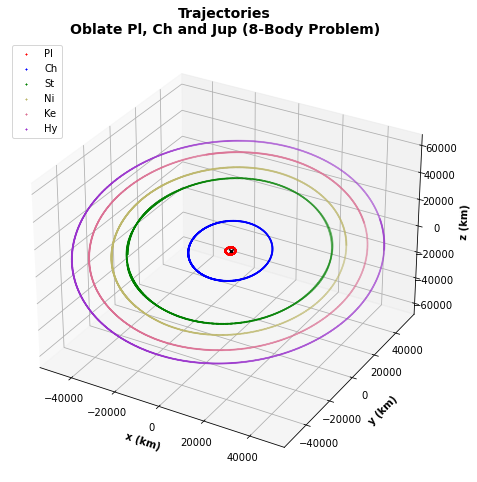

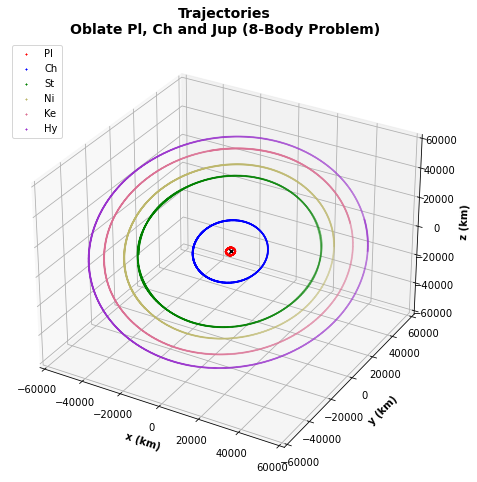

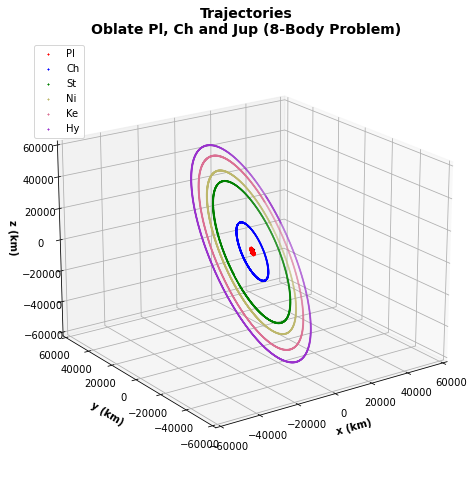

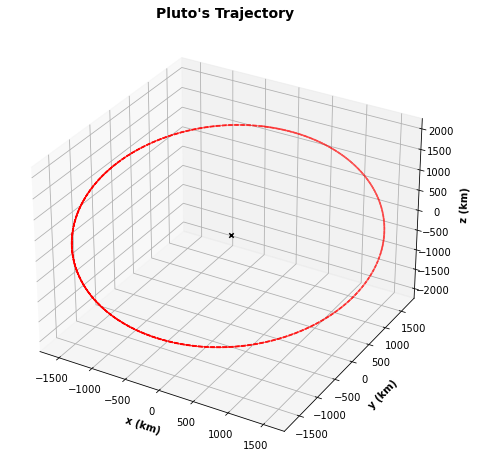

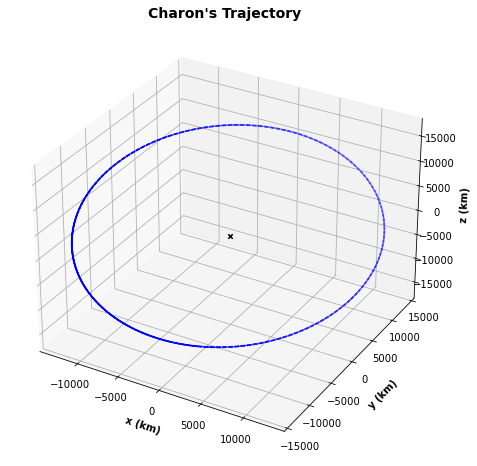

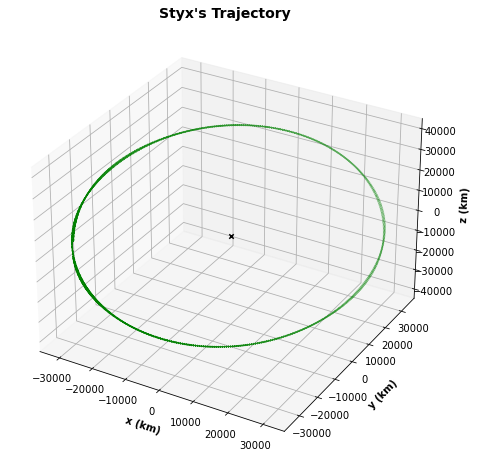

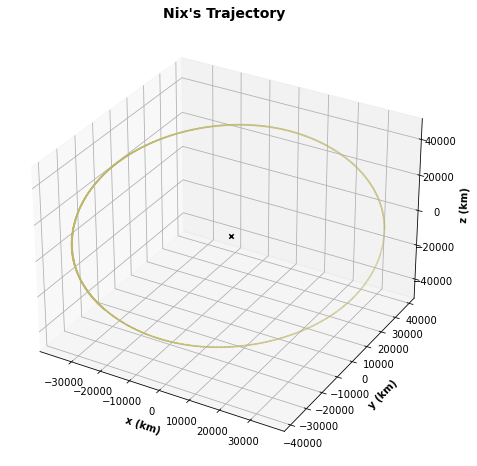

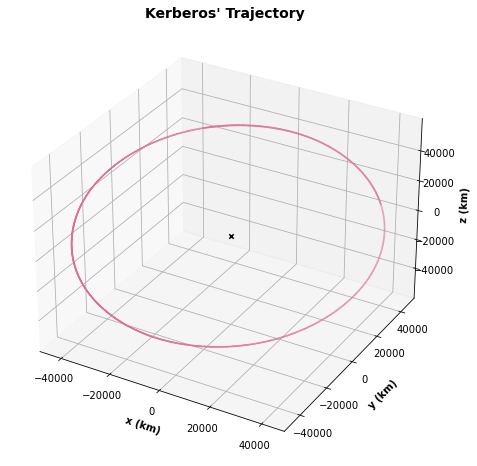

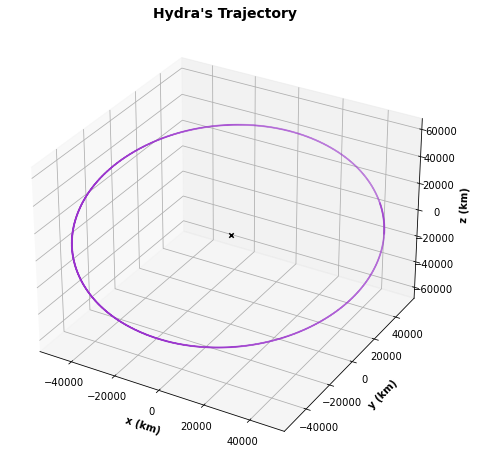

In [83]:
#-------------------------------------------------------------------------------------------------------------------------------
#Printing the approximated parameters for each ellipse.
print("ELLIPTIC TRAJECTORIES' APPROXIMATED PARAMETERS:")
print("Pluto:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (pl_a_RKS2, pl_b_RKS2, pl_c_RKS2, pl_e_RKS2))
print("Charon:   \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ch_a_RKS2, ch_b_RKS2, ch_c_RKS2, ch_e_RKS2))
print("Styx:     \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (st_a_RKS2, st_b_RKS2, st_c_RKS2, st_e_RKS2))
print("Nix:      \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ni_a_RKS2, ni_b_RKS2, ni_c_RKS2, ni_e_RKS2))
print("Kerberos: \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (ke_a_RKS2, ke_b_RKS2, ke_c_RKS2, ke_e_RKS2))
print("Hydra:    \\ a: %f \\ b: %f \\ c: %f \\ e: %f" % (hy_a_RKS2, hy_b_RKS2, hy_c_RKS2, hy_e_RKS2))

#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#Loop to plot only certain points (to ease the graphcator's job).

T = 1000                         # Amount of elements to plot (T=1000 means plotting every 1000).

pl_r_RKS2_g = points_plot(h_RKS2, T, pl_x_RKS2, pl_y_RKS2, pl_z_RKS2, "Pl x")
ch_r_RKS2_g = points_plot(h_RKS2, T, ch_x_RKS2, ch_y_RKS2, ch_z_RKS2, "Ch x")
st_r_RKS2_g = points_plot(h_RKS2, T, st_x_RKS2, st_y_RKS2, st_z_RKS2, "St x")
ni_r_RKS2_g = points_plot(h_RKS2, T, ni_x_RKS2, ni_y_RKS2, ni_z_RKS2, "Ni x")
ke_r_RKS2_g = points_plot(h_RKS2, T, ke_x_RKS2, ke_y_RKS2, ke_z_RKS2, "Ke x")
hy_r_RKS2_g = points_plot(h_RKS2, T, hy_x_RKS2, hy_y_RKS2, hy_z_RKS2, "Hy x")

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting all orbits together.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS2_g[:,0], ch_r_RKS2_g[:,1], ch_r_RKS2_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS2_g[:,0], st_r_RKS2_g[:,1], st_r_RKS2_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS2_g[:,0], ni_r_RKS2_g[:,1], ni_r_RKS2_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS2_g[:,0], ke_r_RKS2_g[:,1], ke_r_RKS2_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS2_g[:,0], hy_r_RKS2_g[:,1], hy_r_RKS2_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Plotting all orbits together with axes at the same scale.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS2_g[:,0], ch_r_RKS2_g[:,1], ch_r_RKS2_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS2_g[:,0], st_r_RKS2_g[:,1], st_r_RKS2_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS2_g[:,0], ni_r_RKS2_g[:,1], ni_r_RKS2_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS2_g[:,0], ke_r_RKS2_g[:,1], ke_r_RKS2_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS2_g[:,0], hy_r_RKS2_g[:,1], hy_r_RKS2_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.set_xlim3d(-60000, 60000)
ax.set_ylim3d(-60000, 60000)
ax.set_zlim3d(-60000, 60000)
ax.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.show()

#Plotting all orbits together, from a different perspective.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
ax.scatter(ch_r_RKS2_g[:,0], ch_r_RKS2_g[:,1], ch_r_RKS2_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
ax.scatter(st_r_RKS2_g[:,0], st_r_RKS2_g[:,1], st_r_RKS2_g[:,2], marker="x", c=col_st, s=1, label="St");
ax.scatter(ni_r_RKS2_g[:,0], ni_r_RKS2_g[:,1], ni_r_RKS2_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
ax.scatter(ke_r_RKS2_g[:,0], ke_r_RKS2_g[:,1], ke_r_RKS2_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.scatter(hy_r_RKS2_g[:,0], hy_r_RKS2_g[:,1], hy_r_RKS2_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
ax.set_xlim3d(-60000, 60000)
ax.set_ylim3d(-60000, 60000)
ax.set_zlim3d(-60000, 60000)
ax.legend(loc='upper left')
ax.view_init(20, -125)
fig.set_size_inches(8, 8)
plt.show()

#Plotting all individual orbits.
plot_orbit("Pluto",    pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], col_pl, "Pl")
plot_orbit("Charon",   ch_r_RKS2_g[:,0], ch_r_RKS2_g[:,1], ch_r_RKS2_g[:,2], col_ch, "Ch")
plot_orbit("Styx",     st_r_RKS2_g[:,0], st_r_RKS2_g[:,1], st_r_RKS2_g[:,2], col_st, "St")
plot_orbit("Nix",      ni_r_RKS2_g[:,0], ni_r_RKS2_g[:,1], ni_r_RKS2_g[:,2], col_ni, "Ni")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Kerberos' Trajectory", fontweight="bold", fontsize=14)
ax.scatter(0, 0, 0, marker="x", c="black");
ax.scatter(ke_r_RKS2_g[:,0], ke_r_RKS2_g[:,1], ke_r_RKS2_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
ax.set_xlabel("x (km)", fontweight="bold")
ax.set_ylabel("\ny (km)", fontweight="bold")
ax.set_zlabel("\nz (km)", fontweight="bold")
fig.set_size_inches(8, 8)
plt.show()

plot_orbit("Hydra",    hy_r_RKS2_g[:,0], hy_r_RKS2_g[:,1], hy_r_RKS2_g[:,2], col_hy, "Hy")


## Animations - Oblate Pl, Ch and Jup (8-Body Problem)

#### IMPORTANT: The following code are exclusivley to generate GIF animations that we used in presentations (PowerPoint, Prezi, etc.). It is NOT necessary to run these lines if you are only interested in the results.

##### The animations are saved in GIF format directly in the folder where this notebook is located. The path can be changed for each animation, as well as the file name.

In [84]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - rotating perspective.
del filenames   #If this is the first animation, comment this line.
filenames = []
T = 108
k = 360/T
lim = tqdm((range(T)), desc="GIF: ")
for i in lim:
    #Creating each frame.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)", fontsize=16)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.scatter(pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], marker="x", c=col_pl, s=1, label="Pl");
    ax.scatter(ch_r_RKS2_g[:,0], ch_r_RKS2_g[:,1], ch_r_RKS2_g[:,2], marker="x", c=col_ch, s=1, label="Ch");
    ax.scatter(st_r_RKS2_g[:,0], st_r_RKS2_g[:,1], st_r_RKS2_g[:,2], marker="x", c=col_st, s=1, label="St");
    ax.scatter(ni_r_RKS2_g[:,0], ni_r_RKS2_g[:,1], ni_r_RKS2_g[:,2], marker="x", c=col_ni, s=1, label="Ni");
    ax.scatter(ke_r_RKS2_g[:,0], ke_r_RKS2_g[:,1], ke_r_RKS2_g[:,2], marker="x", c=col_ke, s=1, label="Ke");
    ax.scatter(hy_r_RKS2_g[:,0], hy_r_RKS2_g[:,1], hy_r_RKS2_g[:,2], marker="x", c=col_hy, s=1, label="Hy");
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    ax.view_init(20, -k*i)
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{i}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()
    
# The GIF is created.
with imageio.get_writer('Rotation_OPCJ(8BP).gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/108 [00:00<?, ?it/s]

In [85]:
#-------------------------------------------------------------------------------------------------------------------------------
#Orbits around barycenter - movement animation.
T = 200
k = math.floor(len(pl_r_RKS2_g[:,0])/T)         # Amount of data in each of the T partitions.

del filenames   #If this is the first animation, comment this line.
filenames = []
lim = tqdm((range(T)), desc="GIF: ")
i = 0
d = 1
for j in lim:
    
    if i == 5:
        d = d + 1
        i = 0
    i = i + 1
    
    #Creating each frame.
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)\n2 days /s   (Day "+str(d)+")", fontsize=14)
    ax.scatter(0, 0, 0, marker="x", c="black");
    ax.plot(pl_r_RKS2_g[:j*k,0], pl_r_RKS2_g[:j*k,1], pl_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_pl);
    ax.scatter(pl_r_RKS2_g[j*k,0], pl_r_RKS2_g[j*k,1], pl_r_RKS2_g[j*k,2], c=col_pl, label="Pl", s=40);
    ax.plot(ch_r_RKS2_g[:j*k,0], ch_r_RKS2_g[:j*k,1], ch_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_ch);
    ax.scatter(ch_r_RKS2_g[j*k,0], ch_r_RKS2_g[j*k,1], ch_r_RKS2_g[j*k,2], c=col_ch, label="Ch", s=40);
    ax.plot(st_r_RKS2_g[:j*k,0], st_r_RKS2_g[:j*k,1], st_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_st);
    ax.scatter(st_r_RKS2_g[j*k,0], st_r_RKS2_g[j*k,1], st_r_RKS2_g[j*k,2], c=col_st, label="St", s=40);
    ax.plot(ni_r_RKS2_g[:j*k,0], ni_r_RKS2_g[:j*k,1], ni_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_ni);
    ax.scatter(ni_r_RKS2_g[j*k,0], ni_r_RKS2_g[j*k,1], ni_r_RKS2_g[j*k,2], c=col_ni, label="Ni", s=40);
    ax.plot(ke_r_RKS2_g[:j*k,0], ke_r_RKS2_g[:j*k,1], ke_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_ke);
    ax.scatter(ke_r_RKS2_g[j*k,0], ke_r_RKS2_g[j*k,1], ke_r_RKS2_g[j*k,2], c=col_ke, label="Ke", s=40);
    ax.plot(hy_r_RKS2_g[:j*k,0], hy_r_RKS2_g[:j*k,1], hy_r_RKS2_g[:j*k,2], lw=1, alpha=0.5, c=col_hy);
    ax.scatter(hy_r_RKS2_g[j*k,0], hy_r_RKS2_g[j*k,1], hy_r_RKS2_g[j*k,2], c=col_hy, label="Hy", s=40);
    ax.set_xlabel("x (km)", fontweight="bold")
    ax.set_ylabel("\ny (km)", fontweight="bold")
    ax.set_zlabel("\nz (km)", fontweight="bold")
    ax.set_xlim3d(-60000, 60000)
    ax.set_ylim3d(-60000, 60000)
    ax.set_zlim3d(-60000, 60000)
    ax.legend(loc='upper left')
    fig.set_size_inches(8, 8)
    
    # The PNG file to save the current frame is created.
    filename = f'{j}.png'
    filenames.append(filename)
    
    # The frame is saved in the PNG file.
    plt.savefig(filename)
    plt.close()
    
# The GIF is created.
with imageio.get_writer('Orbits_OPCJ(8BP).gif', mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# The individual frame files are eliminated.
for filename in set(filenames):
    os.remove(filename)
    

GIF:   0%|          | 0/200 [00:00<?, ?it/s]

### Fitted Planes and Orbital Periods - Oblate Pl, Ch and Jup (8-Body Problem)

In [86]:
#-------------------------------------------------------------------------------------------------------------------------------
#Storing the first orbit's data.
p_r_pl_RKS2 = one_orbit(pl_x_RKS2, pl_y_RKS2, pl_z_RKS2, "Pl")
p_r_ch_RKS2 = one_orbit(ch_x_RKS2, ch_y_RKS2, ch_z_RKS2, "Ch")
p_r_st_RKS2 = one_orbit(st_x_RKS2, st_y_RKS2, st_z_RKS2, "St")
p_r_ni_RKS2 = one_orbit(ni_x_RKS2, ni_y_RKS2, ni_z_RKS2, "Ni")
p_r_ke_RKS2 = one_orbit(ke_x_RKS2, ke_y_RKS2, ke_z_RKS2, "Ke")
p_r_hy_RKS2 = one_orbit(hy_x_RKS2, hy_y_RKS2, hy_z_RKS2, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Fitting the plane to each orbits points.
print("FITTED PLANES:\n")
pln_pl_RKS2 = plane("Pluto",    p_r_pl_RKS2[:,0], p_r_pl_RKS2[:,1], p_r_pl_RKS2[:,2])
pln_ch_RKS2 = plane("Charon",   p_r_ch_RKS2[:,0], p_r_ch_RKS2[:,1], p_r_ch_RKS2[:,2])
pln_st_RKS2 = plane("Styx",     p_r_st_RKS2[:,0], p_r_st_RKS2[:,1], p_r_st_RKS2[:,2])
pln_ni_RKS2 = plane("Nix",      p_r_ni_RKS2[:,0], p_r_ni_RKS2[:,1], p_r_ni_RKS2[:,2])
pln_ke_RKS2 = plane("Kerberos", p_r_ke_RKS2[:,0], p_r_ke_RKS2[:,1], p_r_ke_RKS2[:,2])
pln_hy_RKS2 = plane("Hydra",    p_r_hy_RKS2[:,0], p_r_hy_RKS2[:,1], p_r_hy_RKS2[:,2])

#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the orbital period for each body.
per_pl_RKS2 = period(h_RKS2, p_r_pl_RKS2[:,3])
per_ch_RKS2 = period(h_RKS2, p_r_ch_RKS2[:,3])
per_st_RKS2 = period(h_RKS2, p_r_st_RKS2[:,3])
per_ni_RKS2 = period(h_RKS2, p_r_ni_RKS2[:,3])
per_ke_RKS2 = period(h_RKS2, p_r_ke_RKS2[:,3])
per_hy_RKS2 = period(h_RKS2, p_r_hy_RKS2[:,3])

print("\nORBITAL PERIOD (and amount of data for 1st orbit)\n")
print_per(h_RKS2, "Pluto",    p_r_pl_RKS2, per_pl_RKS2)
print_per(h_RKS2, "Charon",   p_r_ch_RKS2, per_ch_RKS2)
print_per(h_RKS2, "Styx",     p_r_st_RKS2, per_st_RKS2)
print_per(h_RKS2, "Nix",      p_r_ni_RKS2, per_ni_RKS2)
print_per(h_RKS2, "Kerberos", p_r_ke_RKS2, per_ke_RKS2)
print_per(h_RKS2, "Hydra",    p_r_hy_RKS2, per_hy_RKS2)


1st Orbit (Pl):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ch):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (St):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ni):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Ke):   0%|          | 0/1000001 [00:00<?, ?it/s]

1st Orbit (Hy):   0%|          | 0/1000001 [00:00<?, ?it/s]

FITTED PLANES:

Pluto: -1.742631 x + 1.602679 y + -0.008568 = z
Charon: -1.742631 x + 1.602679 y + 0.033800 = z
Styx: -1.745970 x + 1.604350 y + 1.556116 = z
Nix: -1.741805 x + 1.598748 y + 1.820972 = z
Kerberos: -1.763610 x + 1.638543 y + 8.192223 = z
Hydra: -1.720588 x + 1.596022 y + 4.417817 = z

ORBITAL PERIOD (and amount of data for 1st orbit)

Pluto:
Amount of Data: 159867
Period (days):  6.3947 +/- 2e-05

Charon:
Amount of Data: 159866
Period (days):  6.394660000000001 +/- 2e-05

Styx:
Amount of Data: 504914
Period (days):  20.19658 +/- 2e-05

Nix:
Amount of Data: 622789
Period (days):  24.91158 +/- 2e-05

Kerberos:
Amount of Data: 804228
Period (days):  32.16914 +/- 2e-05

Hydra:
Amount of Data: 955644
Period (days):  38.22578 +/- 2e-05



### Pluto's Trajectory - Oblate Pl, Ch and Jup (8-Body Problem)

##### As with the previous model, th eorbital precession is not noticeable anymore.

P. Proj. (Pl) ::   0%|          | 0/1000 [00:00<?, ?it/s]

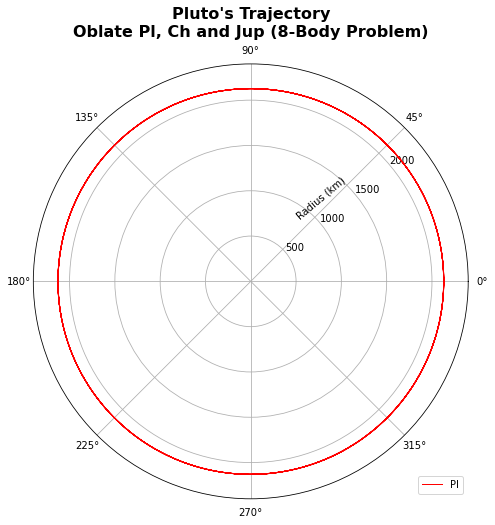

In [87]:
#-------------------------------------------------------------------------------------------------------------------------------
#Projecting the points to Pluto's plane.
p_pl_r_RKS2_g = points_proj(pl_r_RKS2_g[:,0], pl_r_RKS2_g[:,1], pl_r_RKS2_g[:,2], pln_pl_RKS2, "Pl")

#Plotting (polar) Pluto's trajectory.
fig = plt.figure()
ax = plt.subplot(111, polar=True)
fig.set_size_inches(8, 8)
ax.set_title("Pluto's Trajectory\nOblate Pl, Ch and Jup (8-Body Problem)", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_pl_r_RKS2_g[:,4], p_pl_r_RKS2_g[:,3], color=col_pl, lw=1, label="Pl")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
ax.set_rmax(2400)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()


### Projecting the Points to the Plane - Oblate Pl, Ch and Jup (8-Body Problem)

P. Proj. (Pl) ::   0%|          | 0/159867 [00:00<?, ?it/s]

P. Proj. (Ch) ::   0%|          | 0/159866 [00:00<?, ?it/s]

P. Proj. (St) ::   0%|          | 0/504914 [00:00<?, ?it/s]

P. Proj. (Ni) ::   0%|          | 0/622789 [00:00<?, ?it/s]

P. Proj. (Ke) ::   0%|          | 0/804228 [00:00<?, ?it/s]

P. Proj. (Hy) ::   0%|          | 0/955644 [00:00<?, ?it/s]

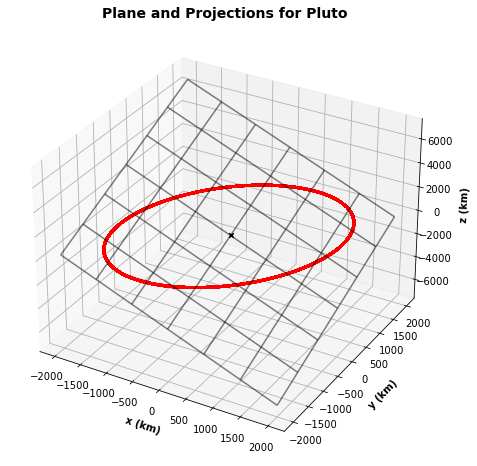

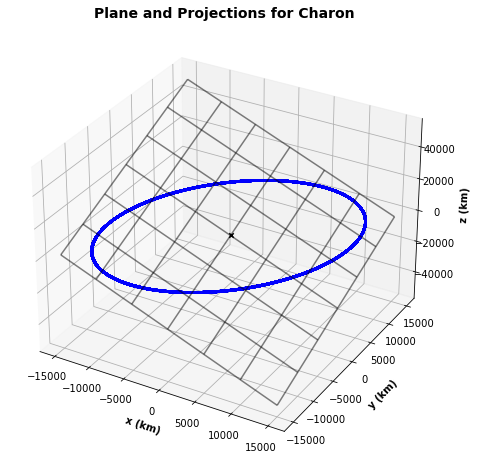

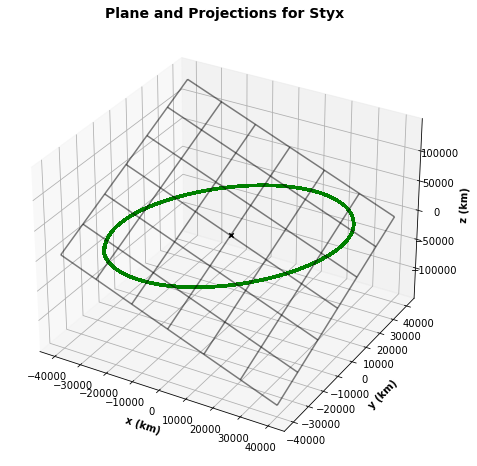

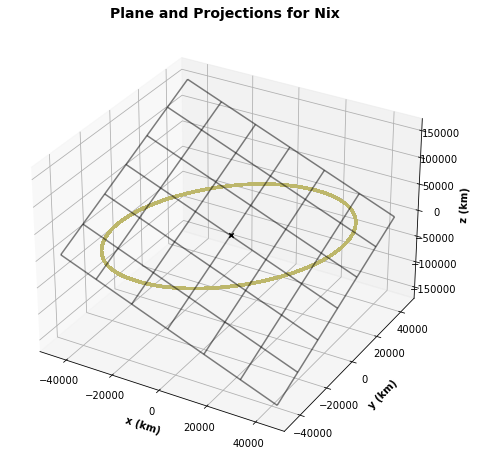

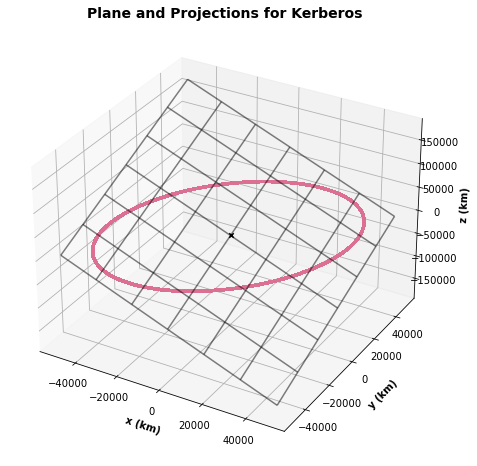

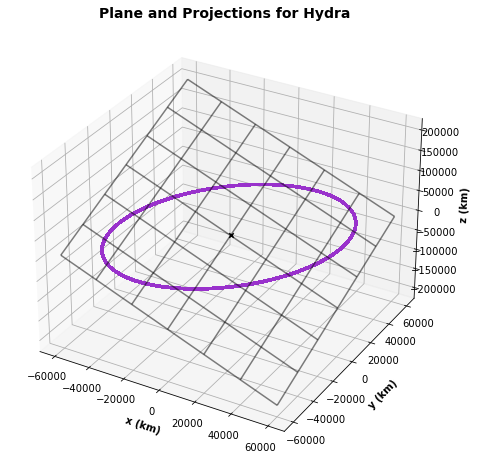

In [88]:
#-------------------------------------------------------------------------------------------------------------------------------
#Projecting the points to the fitted plane.
p_pl_r_RKS2 = points_proj(p_r_pl_RKS2[:,0], p_r_pl_RKS2[:,1], p_r_pl_RKS2[:,2], pln_pl_RKS2, "Pl")
p_ch_r_RKS2 = points_proj(p_r_ch_RKS2[:,0], p_r_ch_RKS2[:,1], p_r_ch_RKS2[:,2], pln_ch_RKS2, "Ch")
p_st_r_RKS2 = points_proj(p_r_st_RKS2[:,0], p_r_st_RKS2[:,1], p_r_st_RKS2[:,2], pln_st_RKS2, "St")
p_ni_r_RKS2 = points_proj(p_r_ni_RKS2[:,0], p_r_ni_RKS2[:,1], p_r_ni_RKS2[:,2], pln_ni_RKS2, "Ni")
p_ke_r_RKS2 = points_proj(p_r_ke_RKS2[:,0], p_r_ke_RKS2[:,1], p_r_ke_RKS2[:,2], pln_ke_RKS2, "Ke")
p_hy_r_RKS2 = points_proj(p_r_hy_RKS2[:,0], p_r_hy_RKS2[:,1], p_r_hy_RKS2[:,2], pln_hy_RKS2, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the points in their planes.

#Limits for the grid to represent the plane.
grid_pl = ([-2000, 2000, 7])
grid_ch = ([-15000,15000,7])
grid_st = ([-40000,40000,7])
grid_ni = ([-45000,45000,7])
grid_ke = ([-50000,50000,7])
grid_hy = ([-60000,60000,7])

#Plotting the points in their planes.
plot_plane("Pluto",    pln_pl_RKS2, col_pl, p_pl_r_RKS2, grid_pl)
plot_plane("Charon",   pln_ch_RKS2, col_ch, p_ch_r_RKS2, grid_ch)
plot_plane("Styx",     pln_st_RKS2, col_st, p_st_r_RKS2, grid_st)
plot_plane("Nix",      pln_ni_RKS2, col_ni, p_ni_r_RKS2, grid_ni)
plot_plane("Kerberos", pln_ke_RKS2, col_ke, p_ke_r_RKS2, grid_ke)
plot_plane("Hydra",    pln_hy_RKS2, col_hy, p_hy_r_RKS2, grid_hy)


### Fitting Ellipses - Oblate Pl, Ch and Jup (8-Body Problem)

2D Points (Pl) ::   0%|          | 0/159867 [00:00<?, ?it/s]

2D Points (Ch) ::   0%|          | 0/159866 [00:00<?, ?it/s]

2D Points (St) ::   0%|          | 0/504914 [00:00<?, ?it/s]

2D Points (Ni) ::   0%|          | 0/622789 [00:00<?, ?it/s]

2D Points (Ke) ::   0%|          | 0/804228 [00:00<?, ?it/s]

2D Points (Hy) ::   0%|          | 0/955644 [00:00<?, ?it/s]

<ipython-input-13-e09e82ee946b>:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()      # The constants are stored. They are for the equation of the form:


ELLIPTIC TRAJECTORY EQUATION:
Pluto:     2.21e-07x^2 + -2.14e-12xy+2.21e-07y^2+-3.75e-07x+6.09e-07y = 1
Charon:    3.27e-09x^2 + 1.62e-15xy+3.27e-09y^2+4.75e-08x+-7.08e-08y = 1
Styx:      5.53e-10x^2 + -5.57e-12xy+5.58e-10y^2+1.03e-07x+-9.13e-08y = 1
Nix:       4.21e-10x^2 + 3.01e-14xy+4.2e-10y^2+5.55e-08x+-1.34e-08y = 1
Kerberos:  3e-10x^2 + -1.28e-13xy+3e-10y^2+1.01e-07x+-1.2e-08y = 1
Hydra:     2.38e-10x^2 + -2.68e-14xy+2.39e-10y^2+-1.44e-07x+1.61e-07y = 1


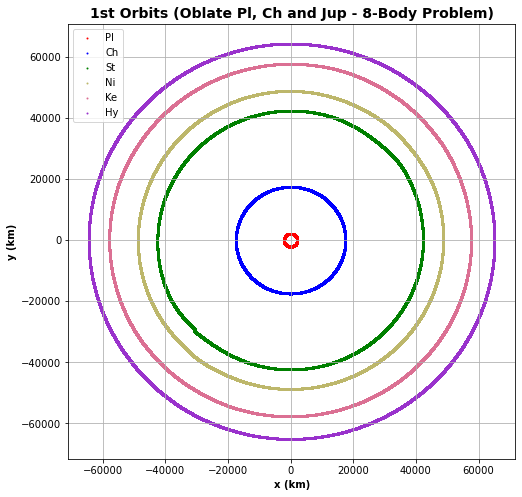

In [89]:
#-------------------------------------------------------------------------------------------------------------------------------
#Generating the 2D points.
pl_2d_r_RKS2 = points_2d(p_pl_r_RKS2, "Pl")
ch_2d_r_RKS2 = points_2d(p_ch_r_RKS2, "Ch")
st_2d_r_RKS2 = points_2d(p_st_r_RKS2, "St")
ni_2d_r_RKS2 = points_2d(p_ni_r_RKS2, "Ni")
ke_2d_r_RKS2 = points_2d(p_ke_r_RKS2, "Ke")
hy_2d_r_RKS2 = points_2d(p_hy_r_RKS2, "Hy")

#-------------------------------------------------------------------------------------------------------------------------------
#Fitting the Ellipses.

#Calculating the constants for the ellipse equation for each body.
ell_pl_RKS2 = fit_ellipse(pl_2d_r_RKS2)
ell_ch_RKS2 = fit_ellipse(ch_2d_r_RKS2)
ell_st_RKS2 = fit_ellipse(st_2d_r_RKS2)
ell_ni_RKS2 = fit_ellipse(ni_2d_r_RKS2)
ell_ke_RKS2 = fit_ellipse(ke_2d_r_RKS2)
ell_hy_RKS2 = fit_ellipse(hy_2d_r_RKS2)

#Printing the ellipse equation for each trajectory.
print("ELLIPTIC TRAJECTORY EQUATION:")
print('Pluto:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_pl_RKS2[0], ell_pl_RKS2[1], ell_pl_RKS2[2], ell_pl_RKS2[3], ell_pl_RKS2[4]))
print('Charon:    {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ch_RKS2[0], ell_ch_RKS2[1], ell_ch_RKS2[2], ell_ch_RKS2[3], ell_ch_RKS2[4]))
print('Styx:      {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_st_RKS2[0], ell_st_RKS2[1], ell_st_RKS2[2], ell_st_RKS2[3], ell_st_RKS2[4]))
print('Nix:       {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ni_RKS2[0], ell_ni_RKS2[1], ell_ni_RKS2[2], ell_ni_RKS2[3], ell_ni_RKS2[4]))
print('Kerberos:  {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_ke_RKS2[0], ell_ke_RKS2[1], ell_ke_RKS2[2], ell_ke_RKS2[3], ell_ke_RKS2[4]))
print('Hydra:     {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(ell_hy_RKS2[0], ell_hy_RKS2[1], ell_hy_RKS2[2], ell_hy_RKS2[3], ell_hy_RKS2[4]))

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting all points no one graph (approximating all planes as equal).
fig = plt.figure()
plt.scatter(pl_2d_r_RKS2[:,0], pl_2d_r_RKS2[:,1], c=col_pl, s=1, label="Pl")
plt.scatter(ch_2d_r_RKS2[:,0], ch_2d_r_RKS2[:,1], c=col_ch, s=1, label="Ch")
plt.scatter(st_2d_r_RKS2[:,0], st_2d_r_RKS2[:,1], c=col_st, s=1, label="St")
plt.scatter(ni_2d_r_RKS2[:,0], ni_2d_r_RKS2[:,1], c=col_ni, s=1, label="Ni")
plt.scatter(ke_2d_r_RKS2[:,0], ke_2d_r_RKS2[:,1], c=col_ke, s=1, label="Ke")
plt.scatter(hy_2d_r_RKS2[:,0], hy_2d_r_RKS2[:,1], c=col_hy, s=1, label="Hy")
plt.title("1st Orbits (Oblate Pl, Ch and Jup - 8-Body Problem)", fontweight="bold", fontsize=14)
plt.xlabel("x (km)", fontweight="bold")
plt.ylabel("y (km)", fontweight="bold")
plt.legend(loc='upper left')
fig.set_size_inches(8, 8)
plt.grid()
plt.xlim([min(hy_2d_r_RKS2[:,0]) - (abs(min(hy_2d_r_RKS2[:,0]))/10), max(hy_2d_r_RKS2[:,0]) + (abs(max(hy_2d_r_RKS2[:,0]))/10)])
plt.ylim([min(hy_2d_r_RKS2[:,1]) - (abs(min(hy_2d_r_RKS2[:,1]))/10), max(hy_2d_r_RKS2[:,1]) + (abs(max(hy_2d_r_RKS2[:,1]))/10)])
plt.show()  


### Fitted Ellipses' Parameters - Oblate Pl, Ch and Jup (8-Body Problem)

In [90]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to print parameters (OPC(6BP) vs. 6BP vs. JPL/NASA).
def print_param_RKS2(title, ell_a, ell_b, ell_c, ell_e, a, b, c, e, ao, bo, co, eo):
    print(title + ':')
    print('OPCJ(8BP):  a: ' + str(ell_a) + '   b: ' + str(ell_b) + '   c: ' + str(ell_c) + '   e: ' + str(ell_e))
    print('8BP:        a: ' + str(a)     + '   b: ' + str(b)     + '   c: ' + str(c)     + '   e: ' + str(e))
    print('JPL/NASA:   a: ' + str(ao)    + '   b: ' + str(bo)    + '   c: ' + str(co)    + '   e: ' + str(eo))
    print("")


In [91]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the fitted ellipses' parameters.
ell_pl_a_RKS2, ell_pl_b_RKS2, ell_pl_c_RKS2, ell_pl_e_RKS2 = param_ellipse(ell_pl_RKS2)
ell_ch_a_RKS2, ell_ch_b_RKS2, ell_ch_c_RKS2, ell_ch_e_RKS2 = param_ellipse(ell_ch_RKS2)
ell_st_a_RKS2, ell_st_b_RKS2, ell_st_c_RKS2, ell_st_e_RKS2 = param_ellipse(ell_st_RKS2)
ell_ni_a_RKS2, ell_ni_b_RKS2, ell_ni_c_RKS2, ell_ni_e_RKS2 = param_ellipse(ell_ni_RKS2)
ell_ke_a_RKS2, ell_ke_b_RKS2, ell_ke_c_RKS2, ell_ke_e_RKS2 = param_ellipse(ell_ke_RKS2)
ell_hy_a_RKS2, ell_hy_b_RKS2, ell_hy_c_RKS2, ell_hy_e_RKS2 = param_ellipse(ell_hy_RKS2)

#-------------------------------------------------------------------------------------------------------------------------------
#Printing parameters (OPCJ(8BP) vs. 8BP vs. JPL/NASA).
print("ELLIPTIC TRAJECTORIES' PARAMETERS:")
print_param_RKS2("Pluto",    ell_pl_a_RKS2, ell_pl_b_RKS2, ell_pl_c_RKS2, ell_pl_e_RKS2, ell_pl_a_RKS, ell_pl_b_RKS, ell_pl_c_RKS, ell_pl_e_RKS, ell_pl_a, ell_pl_b, ell_pl_c, ell_pl_e)
print_param_RKS2("Charon",   ell_ch_a_RKS2, ell_ch_b_RKS2, ell_ch_c_RKS2, ell_ch_e_RKS2, ell_ch_a_RKS, ell_ch_b_RKS, ell_ch_c_RKS, ell_ch_e_RKS, ell_ch_a, ell_ch_b, ell_ch_c, ell_ch_e)
print_param_RKS2("Styx",     ell_st_a_RKS2, ell_st_b_RKS2, ell_st_c_RKS2, ell_st_e_RKS2, ell_st_a_RKS, ell_st_b_RKS, ell_st_c_RKS, ell_st_e_RKS, ell_st_a, ell_st_b, ell_st_c, ell_st_e)
print_param_RKS2("Nix",      ell_ni_a_RKS2, ell_ni_b_RKS2, ell_ni_c_RKS2, ell_ni_e_RKS2, ell_ni_a_RKS, ell_ni_b_RKS, ell_ni_c_RKS, ell_ni_e_RKS, ell_ni_a, ell_ni_b, ell_ni_c, ell_ni_e)
print_param_RKS2("Kerberos", ell_ke_a_RKS2, ell_ke_b_RKS2, ell_ke_c_RKS2, ell_ke_e_RKS2, ell_ke_a_RKS, ell_ke_b_RKS, ell_ke_c_RKS, ell_ke_e_RKS, ell_ke_a, ell_ke_b, ell_ke_c, ell_ke_e)
print_param_RKS2("Hydra",    ell_hy_a_RKS2, ell_hy_b_RKS2, ell_hy_c_RKS2, ell_hy_e_RKS2, ell_hy_a_RKS, ell_hy_b_RKS, ell_hy_c_RKS, ell_hy_e_RKS, ell_hy_a, ell_hy_b, ell_hy_c, ell_hy_e)


ELLIPTIC TRAJECTORIES' PARAMETERS:
Pluto:
OPCJ(8BP):  a: 2129.3451143213465   b: 2129.3341033490497   c: 6.847787882787671   e: 0.003215912646921035
8BP:        a: 2129.3495752809695   b: 2129.3389992904376   c: 6.711173522055058   e: 0.0031517481206341453
JPL/NASA:   a: 2131.9525780085874   b: 2131.940437660205   c: 7.194799974670571   e: 0.0033747467222745835

Charon:
OPCJ(8BP):  a: 17482.75550282368   b: 17482.73167219704   c: 28.866060870411683   e: 0.0016511162022427902
8BP:        a: 17482.79276766616   b: 17482.77125248796   c: 27.427911709089468   e: 0.001568851846141491
JPL/NASA:   a: 17468.581965802936   b: 17468.56914863113   c: 21.161178328977304   e: 0.0012113850094195445

Styx:
OPCJ(8BP):  a: 42566.472494929134   b: 42271.9202269758   c: 4998.933984936423   e: 0.11743829572751056
8BP:        a: 42566.54780605922   b: 42272.01780018696   c: 4998.750166411802   e: 0.11743376956916965
JPL/NASA:   a: 42525.54676510705   b: 42227.7681092794   c: 5023.716570451829   e: 0.118134

### Trajectory Comparison - Oblate Pl, Ch and Jup (8-Body Problem)

In [92]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function to plot the compared trajectories of each body.
def plot_OPCJ_8BP_RK(title, th_k, r_k, th_o, r_o, col):
    fig = plt.figure()
    ax = plt.axes(polar = True)
    fig.set_size_inches(8, 8)
    ax.set_title(title+"'s Trajectories", va='bottom', fontweight="bold", fontsize=16)
    plt.polar(th_k, r_k, color=col, lw=2, label="OPCJ(8BP)")
    plt.polar(th_o, r_o, color=col, lw=3, linestyle='dashed')
    plt.polar(0, 0, color=col, label="JPL/NASA", linestyle="dashed")
    ax.legend(loc='lower right')
    ax.set_rlabel_position(40)
    label_position=ax.get_rlabel_position()
    ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
    plt.show()


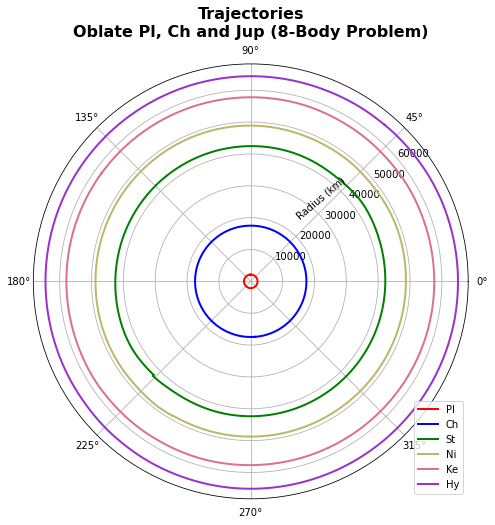

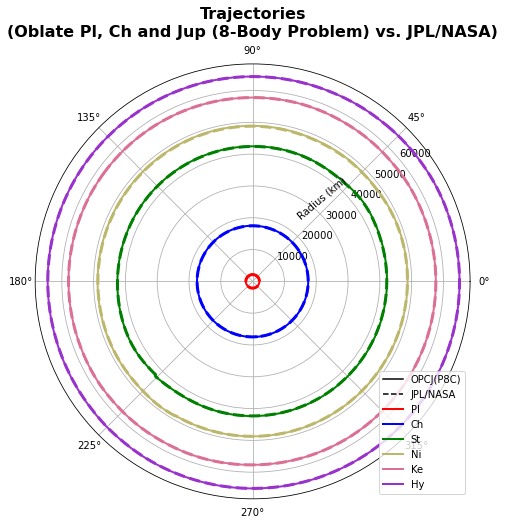

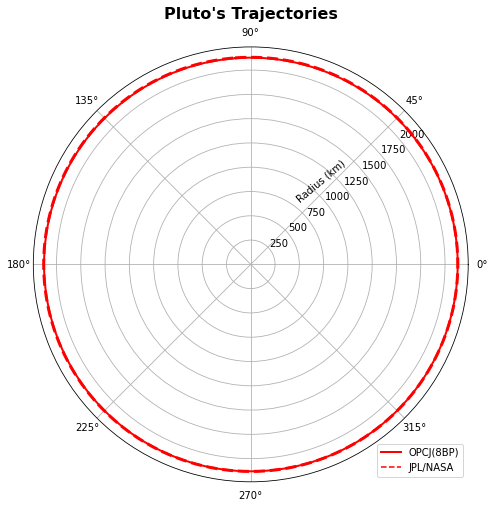

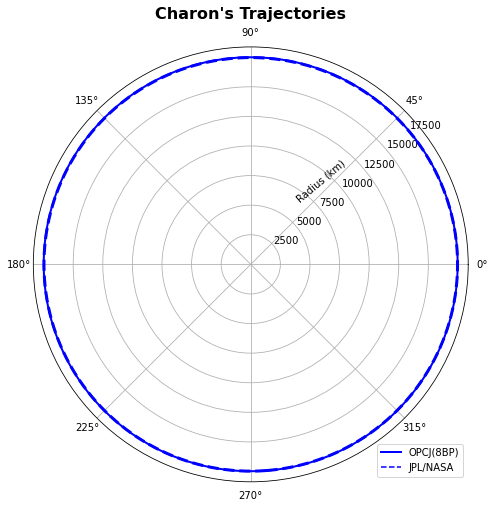

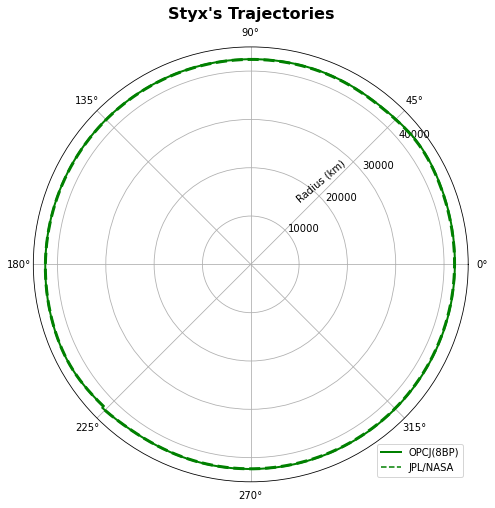

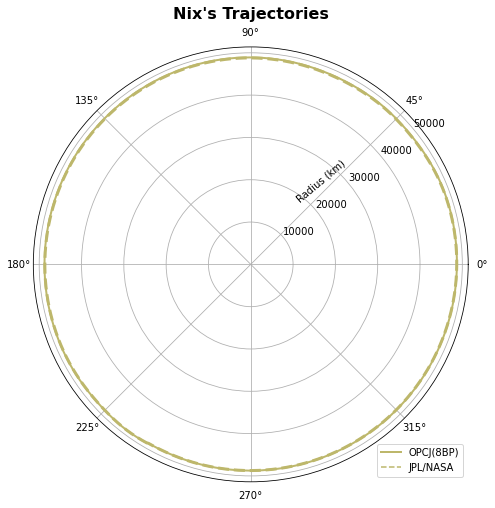

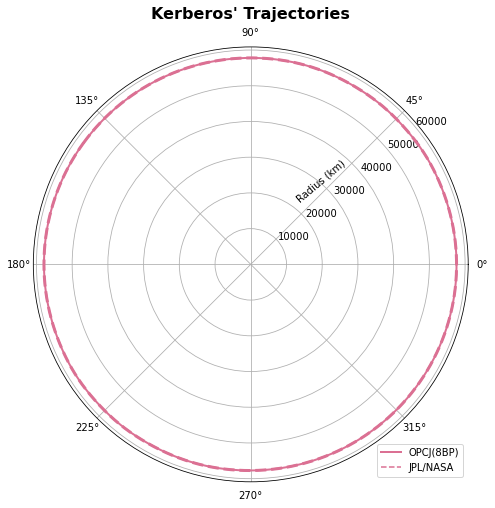

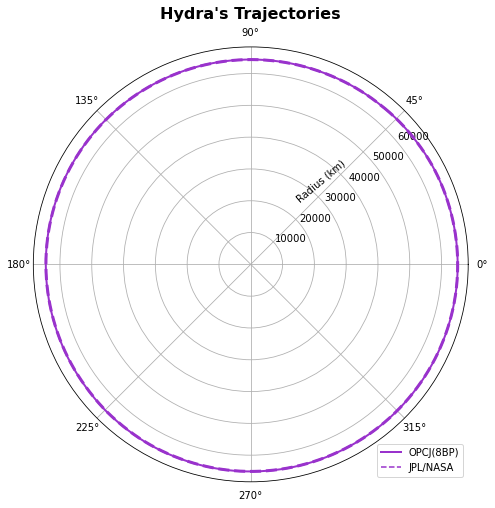

In [94]:
#Plotting all trajectories of this model.
fig = plt.figure()
ax = plt.subplot(111, polar=True)
fig.set_size_inches(8, 8)
ax.set_title("Trajectories\nOblate Pl, Ch and Jup (8-Body Problem)", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_pl_r_RKS2[:,4], p_pl_r_RKS2[:,3], color=col_pl, lw=2, label="Pl")
plt.polar(p_ch_r_RKS2[:,4], p_ch_r_RKS2[:,3], color=col_ch, lw=2, label="Ch")
plt.polar(p_st_r_RKS2[:,4], p_st_r_RKS2[:,3], color=col_st, lw=2, label="St")
plt.polar(p_ni_r_RKS2[:,4], p_ni_r_RKS2[:,3], color=col_ni, lw=2, label="Ni")
plt.polar(p_ke_r_RKS2[:,4], p_ke_r_RKS2[:,3], color=col_ke, lw=2, label="Ke")
plt.polar(p_hy_r_RKS2[:,4], p_hy_r_RKS2[:,3], color=col_hy, lw=2, label="Hy")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

#Plotting all trajectories to compare.
fig = plt.figure()
ax = plt.axes(polar = True)
fig.set_size_inches(8, 8)
ax.set_title("Trajectories\n(Oblate Pl, Ch and Jup (8-Body Problem) vs. JPL/NASA)", va='bottom', fontweight="bold", fontsize=16)
plt.plot(0, 0, color="black", label="OPCJ(P8C)")                            # Estos plot son
plt.plot(0, 0, color="black", label="JPL/NASA", linestyle="dashed")  # sólo para los labels.
plt.polar(p_pl_r_RKS2[:,4], p_pl_r_RKS2[:,3], color=col_pl, lw=2, label="Pl")
plt.polar(p_ch_r_RKS2[:,4], p_ch_r_RKS2[:,3], color=col_ch, lw=2, label="Ch")
plt.polar(p_st_r_RKS2[:,4], p_st_r_RKS2[:,3], color=col_st, lw=2, label="St")
plt.polar(p_ni_r_RKS2[:,4], p_ni_r_RKS2[:,3], color=col_ni, lw=2, label="Ni")
plt.polar(p_ke_r_RKS2[:,4], p_ke_r_RKS2[:,3], color=col_ke, lw=2, label="Ke")
plt.polar(p_hy_r_RKS2[:,4], p_hy_r_RKS2[:,3], color=col_hy, lw=2, label="Hy")
plt.polar(p_pl_r[:,4], p_pl_r[:,3], color=col_pl, lw=3, linestyle='dashed')
plt.polar(p_ch_r[:,4], p_ch_r[:,3], color=col_ch, lw=3, linestyle='dashed')
plt.polar(p_st_r[:,4], p_st_r[:,3], color=col_st, lw=3, linestyle='dashed')
plt.polar(p_ni_r[:,4], p_ni_r[:,3], color=col_ni, lw=3, linestyle='dashed')
plt.polar(p_ke_r[:,4], p_ke_r[:,3], color=col_ke, lw=3, linestyle='dashed')
plt.polar(p_hy_r[:,4], p_hy_r[:,3], color=col_hy, lw=3, linestyle='dashed')
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()

#Plotting the trajectories of all individual bodies.
plot_OPCJ_8BP_RK("Pluto",    p_pl_r_RKS2[:,4], p_pl_r_RKS2[:,3], p_pl_r[:,4], p_pl_r[:,3], col_pl)
plot_OPCJ_8BP_RK("Charon",   p_ch_r_RKS2[:,4], p_ch_r_RKS2[:,3], p_ch_r[:,4], p_ch_r[:,3], col_ch)
plot_OPCJ_8BP_RK("Styx",     p_st_r_RKS2[:,4], p_st_r_RKS2[:,3], p_st_r[:,4], p_st_r[:,3], col_st)
plot_OPCJ_8BP_RK("Nix",      p_ni_r_RKS2[:,4], p_ni_r_RKS2[:,3], p_ni_r[:,4], p_ni_r[:,3], col_ni)

fig = plt.figure()
ax = plt.axes(polar = True)
fig.set_size_inches(8, 8)
ax.set_title("Kerberos' Trajectories", va='bottom', fontweight="bold", fontsize=16)
plt.polar(p_ke_r_RKS2[:,4], p_ke_r_RKS2[:,3], color=col_ke, lw=2, label="OPCJ(8BP)")
plt.polar(p_ke_r[:,4], p_ke_r[:,3], color=col_ke, lw=3, linestyle='dashed')
plt.polar(0, 0, color=col_ke, label="JPL/NASA", linestyle="dashed")
ax.legend(loc='lower right')
ax.set_rlabel_position(40)
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Radius (km)', rotation=label_position,ha='center',va='center')
plt.show()
    
plot_OPCJ_8BP_RK("Hydra",    p_hy_r_RKS2[:,4], p_hy_r_RKS2[:,3], p_hy_r[:,4], p_hy_r[:,3], col_hy)


### Angular Momentum Conservation - Oblate Pl, Ch and Jup (8-Body Problem)

##### As expected, the angular momentum stayed around an average value without varying considerably.

In [95]:
#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the angular momentum for each body.
pl_L_RKS2 = momentum(pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, pl_VX_RKS2, pl_VY_RKS2, pl_VZ_RKS2, pl_m, "Pl")
ch_L_RKS2 = momentum(ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, ch_VX_RKS2, ch_VY_RKS2, ch_VZ_RKS2, ch_m, "Ch")
st_L_RKS2 = momentum(st_X_RKS2, st_Y_RKS2, st_Z_RKS2, st_VX_RKS2, st_VY_RKS2, st_VZ_RKS2, st_m, "St")
ni_L_RKS2 = momentum(ni_X_RKS2, ni_Y_RKS2, ni_Z_RKS2, ni_VX_RKS2, ni_VY_RKS2, ni_VZ_RKS2, ni_m, "Ni")
ke_L_RKS2 = momentum(ke_X_RKS2, ke_Y_RKS2, ke_Z_RKS2, ke_VX_RKS2, ke_VY_RKS2, ke_VZ_RKS2, ke_m, "Ke")
hy_L_RKS2 = momentum(hy_X_RKS2, hy_Y_RKS2, hy_Z_RKS2, hy_VX_RKS2, hy_VY_RKS2, hy_VZ_RKS2, hy_m, "Hy")
sun_L_RKS2 = momentum(sun_X_RKS2, sun_Y_RKS2, sun_Z_RKS2, sun_VX_RKS2, sun_VY_RKS2, sun_VZ_RKS2, sun_m, "Sun")
jup_L_RKS2 = momentum(jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, jup_VX_RKS2, jup_VY_RKS2, jup_VZ_RKS2, jup_m, "Jup")

#-------------------------------------------------------------------------------------------------------------------------------
#PLS's total angular momentum.
L_t_RKS2 = np.empty((len(pl_L_RKS2)), float)
lim = tqdm(range(len(pl_L_RKS2)), desc="Total Momentum: ")
for i in lim:
    L_t_RKS2[i] = pl_L_RKS2[i] + ch_L_RKS2[i] + st_L_RKS2[i] + ni_L_RKS2[i] + ke_L_RKS2[i] + hy_L_RKS2[i] + sun_L_RKS2[i] + jup_L_RKS2[i]


Pl's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ch's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

St's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ni's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Ke's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Hy's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Sun's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Jup's Momentum :   0%|          | 0/1000001 [00:00<?, ?it/s]

Total Momentum:   0%|          | 0/1000001 [00:00<?, ?it/s]

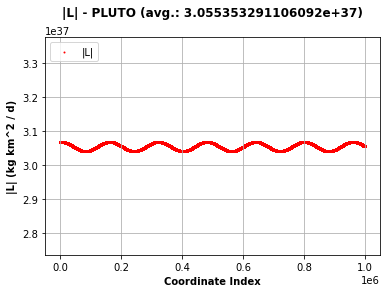

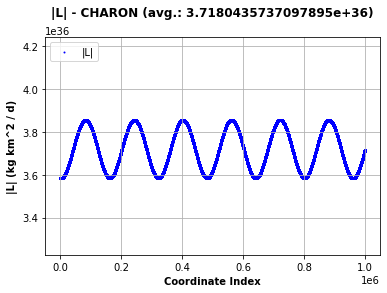

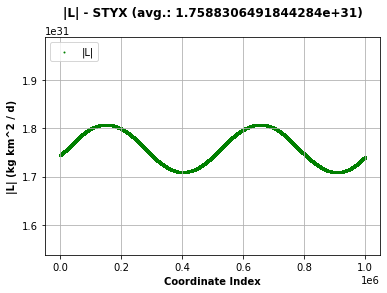

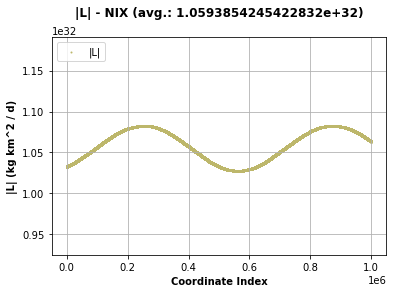

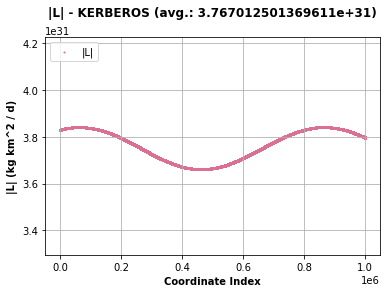

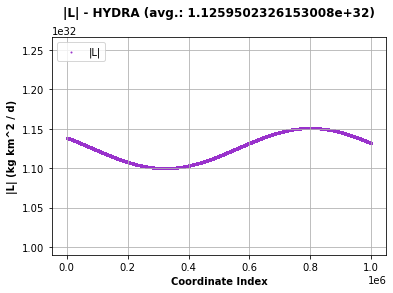

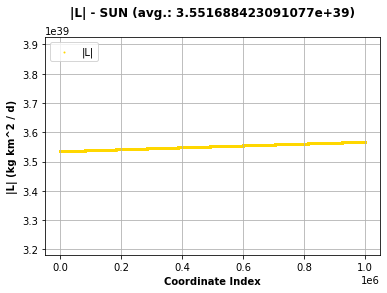

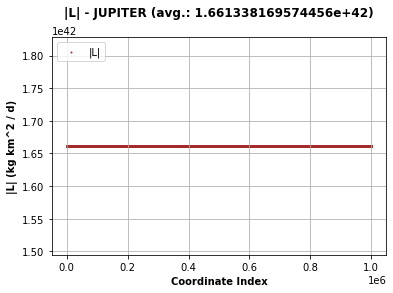

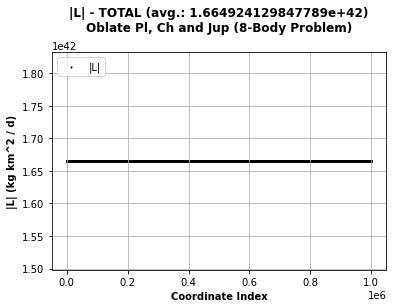

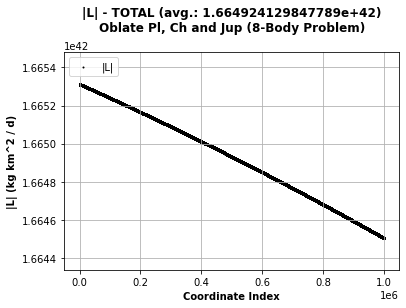

In [96]:
#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the angular momentum for each body and for the PLS.

#Averages.
aver_L_pl_RKS2 = avg(pl_L_RKS2)
aver_L_ch_RKS2 = avg(ch_L_RKS2)
aver_L_st_RKS2 = avg(st_L_RKS2)
aver_L_ni_RKS2 = avg(ni_L_RKS2)
aver_L_ke_RKS2 = avg(ke_L_RKS2)
aver_L_hy_RKS2 = avg(hy_L_RKS2)
aver_L_sun_RKS2 = avg(sun_L_RKS2)
aver_L_jup_RKS2 = avg(jup_L_RKS2)
aver_L_t_RKS2  = avg(L_t_RKS2)

#Plotting each body's angular momentum.
plot_L_RKS("PLUTO",    pl_L_RKS2, col_pl, aver_L_pl_RKS2)
plot_L_RKS("CHARON",   ch_L_RKS2, col_ch, aver_L_ch_RKS2)
plot_L_RKS("STYX",     st_L_RKS2, col_st, aver_L_st_RKS2)
plot_L_RKS("NIX",      ni_L_RKS2, col_ni, aver_L_ni_RKS2)
plot_L_RKS("KERBEROS", ke_L_RKS2, col_ke, aver_L_ke_RKS2)
plot_L_RKS("HYDRA",    hy_L_RKS2, col_hy, aver_L_hy_RKS2)
plot_L_RKS("SUN",      sun_L_RKS2, col_sun, aver_L_sun_RKS2)
plot_L_RKS("JUPITER",  jup_L_RKS2, col_jup, aver_L_jup_RKS2)

#Plotting the total angular momentum.
fig = plt.figure()
plt.scatter(range(len(L_t_RKS2)), L_t_RKS2, c="black", s=1, label="|L|")
plt.title("|L| - TOTAL (avg.: " + str(aver_L_t_RKS2) + ")\nOblate Pl, Ch and Jup (8-Body Problem)\n", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("|L| (kg km^2 / d)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(L_t_RKS2) - (min(L_t_RKS2)/10), max(L_t_RKS2) + (max(L_t_RKS2)/10)])   # Keeps the limits 10% above and under
plt.show()                                                                           # the highest and lowest values plotted.

#Zoom to appreciate variaton.
fig = plt.figure()
plt.scatter(range(len(L_t_RKS2)), L_t_RKS2, c="black", s=1, label="|L|")
plt.title("|L| - TOTAL (avg.: " + str(aver_L_t_RKS2) + ")\nOblate Pl, Ch and Jup (8-Body Problem)\n", fontweight="bold", fontsize=12)
plt.xlabel("Coordinate Index", fontweight="bold")
plt.ylabel("|L| (kg km^2 / d)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(L_t_RKS2) - (min(L_t_RKS2)/10000), max(L_t_RKS2) + (max(L_t_RKS2)/10000)])  # Established limits to get the zoom.
plt.show()


### Energy Conservation - Oblate Pl, Ch and Jup (8-Body Problem)

##### Again, the energies stayed around an average value without varying much.

In [97]:
#FUNCTIONS:

#-------------------------------------------------------------------------------------------------------------------------------
#Function for the energy of a moon (excluding Charon).
def energy_OPCJ_8BP_m(ds, x, y, z, plx, ply, plz, chx, chy, chz, jupx, jupy, jupz, v, m1, m2, m3, m4, m5, m6, m7, m8, title):
    T, U, E = np.zeros((len(v)), float), np.zeros((len(v)), float), np.zeros((len(v)), float)
    
    lim = tqdm(range(len(v)), desc="Energies ("+title+"): ")
    for i in lim:
        
        mu = G*pl_m   # Mass gravitational constant (Pluto).
        rnpl = Ainv_pl.dot([x[i] - plx[i], y[i] - ply[i], z[i] - plz[i]])  # The position vector from Pluto is calculated.
        r = math.sqrt(rnpl[0]**2 + rnpl[1]**2 + rnpl[2]**2)
        ru = rnpl/r    # The unitary vector in the radial direction is calculated.

        U_p_pl = (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Pluto).
        
        mu = G*ch_m   # Mass gravitational constant (Charon).
        rnch = Ainv_ch.dot([x[i] - chx[i], y[i] - chy[i], z[i] - chz[i]])  # The position vector from Charon is calculated.
        r = math.sqrt(rnch[0]**2 + rnch[1]**2 + rnch[2]**2)
        ru = rnch/r    # The unitary vector in the radial direction is calculated.

        U_p_ch = (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Charon).
        
        mu = G*jup_m   # Mass gravitational constant (Jupiter).
        rnjup = Ainv_jup.dot([x[i] - jupx[i], y[i] - jupy[i], z[i] - jupz[i]]) # The position vector from Jupiter is calculated.
        r = math.sqrt(rnjup[0]**2 + rnjup[1]**2 + rnjup[2]**2)
        ru = rnjup/r    # The unitary vector in the radial direction is calculated.

        U_p_jup = (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Jupiter).
        
        # Including the perturbative terms in the potential energy.
        T[i] = 0.5*m1*(v[i]**2)
        U[i] = U_p_ch + U_p_pl + U_p_jup + ((-G*m1*m2) / (ds[i,0])) + ((-G*m1*m3) / (ds[i,1])) + ((-G*m1*m4) / (ds[i,2])) + ((-G*m1*m5) / (ds[i,3])) + ((-G*m1*m6) / (ds[i,4])) + ((-G*m1*m7) / (ds[i,5])) + ((-G*m1*m8) / (ds[i,6]))
        E[i] = T[i] + U[i]
        
    return T, U, E


In [98]:
#-------------------------------------------------------------------------------------------------------------------------------
#Distances between bodies.
pl_d_RKS2, ch_d_RKS2, st_d_RKS2, ni_d_RKS2, ke_d_RKS2, hy_d_RKS2, sun_d_RKS2, jup_d_RKS2 = dist(pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, st_X_RKS2, st_Y_RKS2, st_Z_RKS2, ni_X_RKS2, ni_Y_RKS2, ni_Z_RKS2, ke_X_RKS2, ke_Y_RKS2, ke_Z_RKS2, hy_X_RKS2, hy_Y_RKS2, hy_Z_RKS2, sun_X_RKS2, sun_Y_RKS2, sun_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2)


Dist. Loop:   0%|          | 0/1000001 [00:00<?, ?it/s]

In [102]:
#-------------------------------------------------------------------------------------------------------------------------------
#Universal Gravitational Constant (days).
G = 4.982174e-10  #(km^3 / kg d^2)

#Transformation matrices for the new system whose XY plane is aligned to the body's equator.
A_pl, Ainv_pl = plane_equator(RA_pl, dec_pl)
A_pl, Ainv_pl = np.array(A_pl), np.array(Ainv_pl)

A_ch, Ainv_ch = plane_equator(RA_ch, dec_ch)
A_ch, Ainv_ch = np.array(A_ch), np.array(Ainv_ch)

A_jup, Ainv_jup = plane_equator(RA_jup, dec_jup)
A_jup, Ainv_jup = np.array(A_jup), np.array(Ainv_jup)

#-------------------------------------------------------------------------------------------------------------------------------
#Calculating the energies for each body.

pl_T_RKS2, pl_U_RKS2, pl_E_RKS2 = np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float)
ch_T_RKS2, ch_U_RKS2, ch_E_RKS2 = np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float)
jup_T_RKS2, jup_U_RKS2, jup_E_RKS2 = np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float), np.zeros((len(pl_V_RKS2)), float)


#Pluto.
mu = G*pl_m   # Mass gravitational constant (Pluto).
lim = tqdm(range(len(pl_V_RKS2)), desc="Energies (Pl): ")
for i in lim:        # Loop to calculate the energy in each coordinate.
    
    #Charon's terms.
    
    # The position vector from Pluto is calculated.
    rn = Ainv_pl.dot([ch_X_RKS2[i] - pl_X_RKS2[i], ch_Y_RKS2[i] - pl_Y_RKS2[i], ch_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Pluto).
    
    # The position vector from Charon is calculated.
    rn = Ainv_ch.dot([pl_X_RKS2[i] - ch_X_RKS2[i], pl_Y_RKS2[i] - ch_Y_RKS2[i], pl_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_ch)*(G*ch_m/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative (Charon).
    
    
    #Styx's term.
    rn = Ainv_pl.dot([st_X_RKS2[i] - pl_X_RKS2[i], st_Y_RKS2[i] - pl_Y_RKS2[i], st_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Nix's term.
    rn = Ainv_pl.dot([ni_X_RKS2[i] - pl_X_RKS2[i], ni_Y_RKS2[i] - pl_Y_RKS2[i], ni_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Kerberos' term.
    rn = Ainv_pl.dot([ke_X_RKS2[i] - pl_X_RKS2[i], ke_Y_RKS2[i] - pl_Y_RKS2[i], ke_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Hydra's term.
    rn = Ainv_pl.dot([hy_X_RKS2[i] - pl_X_RKS2[i], hy_Y_RKS2[i] - pl_Y_RKS2[i], hy_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Sun's term.
    rn = Ainv_pl.dot([sun_X_RKS2[i] - pl_X_RKS2[i], sun_Y_RKS2[i] - pl_Y_RKS2[i], sun_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))

    
    #Jupiter's terms.
    rn = Ainv_pl.dot([jup_X_RKS2[i] - pl_X_RKS2[i], jup_Y_RKS2[i] - pl_Y_RKS2[i], jup_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p + (1/2)*(J2_pl)*(mu/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Pluto).
    
    rn = Ainv_jup.dot([pl_X_RKS2[i] - jup_X_RKS2[i], pl_Y_RKS2[i] - jup_Y_RKS2[i], pl_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_jup)*(G*jup_m/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Jupiter).
    
    
    # Including the perturbative terms in the potential energy.
    pl_T_RKS2[i] = 0.5*pl_m*(pl_V_RKS2[i]**2)
    pl_U_RKS2[i] = - U_p + ((-mu*ch_m) / (pl_d_RKS2[i,0])) + ((-mu*st_m) / (pl_d_RKS2[i,1])) + ((-mu*ni_m) / (pl_d_RKS2[i,2])) + ((-mu*ke_m) / (pl_d_RKS2[i,3])) + ((-mu*hy_m) / (pl_d_RKS2[i,4])) + ((-mu*sun_m) / (pl_d_RKS2[i,5])) + ((-mu*jup_m) / (pl_d_RKS2[i,6]))
    pl_E_RKS2[i] = pl_T_RKS2[i] + pl_U_RKS2[i]

    
#Charon
mu = G*ch_m    # Mass gravitational constant (Charon).
lim = tqdm(range(len(pl_V_RKS2)), desc="Energies (Ch): ")
for i in lim:
    
    #Pluto's terms.
    
    # The position vector from Charon is calculated.
    rn = Ainv_ch.dot([pl_X_RKS2[i] - ch_X_RKS2[i], pl_Y_RKS2[i] - ch_Y_RKS2[i], pl_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))   # Perturbative term (Charon).
    
    # The position vector from Pluto is calculated.
    rn = Ainv_pl.dot([ch_X_RKS2[i] - pl_X_RKS2[i], ch_Y_RKS2[i] - pl_Y_RKS2[i], ch_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_pl)*(G*pl_m/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Pluto).
    
    
    #Styx's term.
    rn = Ainv_ch.dot([st_X_RKS2[i] - ch_X_RKS2[i], st_Y_RKS2[i] - ch_Y_RKS2[i], st_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Nix's term.
    rn = Ainv_ch.dot([ni_X_RKS2[i] - ch_X_RKS2[i], ni_Y_RKS2[i] - ch_Y_RKS2[i], ni_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Kerberos' term.
    rn = Ainv_ch.dot([ke_X_RKS2[i] - ch_X_RKS2[i], ke_Y_RKS2[i] - ch_Y_RKS2[i], ke_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Hydra's term.
    rn = Ainv_ch.dot([hy_X_RKS2[i] - ch_X_RKS2[i], hy_Y_RKS2[i] - ch_Y_RKS2[i], hy_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Sun's term.
    rn = Ainv_ch.dot([sun_X_RKS2[i] - ch_X_RKS2[i], sun_Y_RKS2[i] - ch_Y_RKS2[i], sun_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Jupiter's term.
    rn = Ainv_ch.dot([jup_X_RKS2[i] - ch_X_RKS2[i], jup_Y_RKS2[i] - ch_Y_RKS2[i], jup_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p + (1/2)*(J2_ch)*(mu/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))   # Perturbative term (Charon).
    
    rn = Ainv_jup.dot([ch_X_RKS2[i] - jup_X_RKS2[i], ch_Y_RKS2[i] - jup_Y_RKS2[i], ch_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_jup)*(G*jup_m/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Jupiter).

    
    # Including the perturbative terms in the potential energy.
    ch_T_RKS2[i] = 0.5*ch_m*(ch_V_RKS2[i]**2)
    ch_U_RKS2[i] = - U_p + ((-mu*pl_m) / (ch_d_RKS2[i,0])) + ((-mu*st_m) / (ch_d_RKS2[i,1])) + ((-mu*ni_m) / (ch_d_RKS2[i,2])) + ((-mu*ke_m) / (ch_d_RKS2[i,3])) + ((-mu*hy_m) / (ch_d_RKS2[i,4])) + ((-mu*sun_m) / (ch_d_RKS2[i,5])) + ((-mu*jup_m) / (ch_d_RKS2[i,6]))
    ch_E_RKS2[i] = ch_T_RKS2[i] + ch_U_RKS2[i]
    

# Se calculan las energías para el resto de lunas.
st_T_RKS2, st_U_RKS2, st_E_RKS2 = energy_OPCJ_8BP_m(st_d_RKS2, st_X_RKS2, st_Y_RKS2, st_Z_RKS2, pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, st_V_RKS2, st_m, pl_m, ch_m, ni_m, ke_m, hy_m, sun_m, jup_m, "St")
ni_T_RKS2, ni_U_RKS2, ni_E_RKS2 = energy_OPCJ_8BP_m(ni_d_RKS2, ni_X_RKS2, ni_Y_RKS2, ni_Z_RKS2, pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, ni_V_RKS2, ni_m, pl_m, ch_m, st_m, ke_m, hy_m, sun_m, jup_m, "Ni")
ke_T_RKS2, ke_U_RKS2, ke_E_RKS2 = energy_OPCJ_8BP_m(ke_d_RKS2, ke_X_RKS2, ke_Y_RKS2, ke_Z_RKS2, pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, ke_V_RKS2, ke_m, pl_m, ch_m, st_m, ni_m, hy_m, sun_m, jup_m, "Ke")
hy_T_RKS2, hy_U_RKS2, hy_E_RKS2 = energy_OPCJ_8BP_m(hy_d_RKS2, hy_X_RKS2, hy_Y_RKS2, hy_Z_RKS2, pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, hy_V_RKS2, hy_m, pl_m, ch_m, st_m, ni_m, ke_m, sun_m, jup_m, "Hy")
sun_T_RKS2, sun_U_RKS2, sun_E_RKS2 = energy_OPCJ_8BP_m(sun_d_RKS2, sun_X_RKS2, sun_Y_RKS2, sun_Z_RKS2, pl_X_RKS2, pl_Y_RKS2, pl_Z_RKS2, ch_X_RKS2, ch_Y_RKS2, ch_Z_RKS2, jup_X_RKS2, jup_Y_RKS2, jup_Z_RKS2, sun_V_RKS2, sun_m, pl_m, ch_m, st_m, ni_m, ke_m, hy_m, jup_m, "Sun")


#Jupiter.
mu = G*jup_m    # Mass gravitational constant (Jupiter).
lim = tqdm(range(len(pl_V_RKS2)), desc="Energía (Jup): ")
for i in lim:
    
    #Pluto's terms.
    
    # The position vector from Jupiter is calculated.
    rn = Ainv_jup.dot([pl_X_RKS2[i] - jup_X_RKS2[i], pl_Y_RKS2[i] - jup_Y_RKS2[i], pl_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))   # Perturbative term (Jupiter).
    
    # The position vector from Pluto is calculated.
    rn = Ainv_pl.dot([jup_X_RKS2[i] - pl_X_RKS2[i], jup_Y_RKS2[i] - pl_Y_RKS2[i], jup_Z_RKS2[i] - pl_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_pl)*(G*pl_m/(r**2))*((r_eq_pl/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Pluto).
    
    
    #Charon's terms.
    rn = Ainv_jup.dot([ch_X_RKS2[i] - jup_X_RKS2[i], ch_Y_RKS2[i] - jup_Y_RKS2[i], ch_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))   # Perturbative term (Jupiter).
    
    rn = Ainv_ch.dot([jup_X_RKS2[i] - ch_X_RKS2[i], jup_Y_RKS2[i] - ch_Y_RKS2[i], jup_Z_RKS2[i] - ch_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r      # The unitary vector in the radial direction is calculated.
    U_p = U_p - (1/2)*(J2_ch)*(G*pl_m/(r**2))*((r_eq_ch/r)**2)*(1 - 3*(ru[2]**2))  # Perturbative term (Charon).
    
    
    #Styx's term.
    rn = Ainv_jup.dot([st_X_RKS2[i] - jup_X_RKS2[i], st_Y_RKS2[i] - jup_Y_RKS2[i], st_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Nix's term.
    rn = Ainv_jup.dot([ni_X_RKS2[i] - jup_X_RKS2[i], ni_Y_RKS2[i] - jup_Y_RKS2[i], ni_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Kerberos' term.
    rn = Ainv_jup.dot([ke_X_RKS2[i] - jup_X_RKS2[i], ke_Y_RKS2[i] - jup_Y_RKS2[i], ke_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Hydra's term.
    rn = Ainv_jup.dot([hy_X_RKS2[i] - jup_X_RKS2[i], hy_Y_RKS2[i] - jup_Y_RKS2[i], hy_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))
    
    
    #Sun's term.
    rn = Ainv_jup.dot([sun_X_RKS2[i] - jup_X_RKS2[i], sun_Y_RKS2[i] - jup_Y_RKS2[i], sun_Z_RKS2[i] - jup_Z_RKS2[i]])
    r = math.sqrt(rn[0]**2 + rn[1]**2 + rn[2]**2)
    ru = rn/r
    U_p = U_p + (1/2)*(J2_jup)*(mu/(r**2))*((r_eq_jup/r)**2)*(1 - 3*(ru[2]**2))
    
    
    # Including the perturbative terms in the potential energy.
    jup_T_RKS2[i] = 0.5*jup_m*(jup_V_RKS2[i]**2)
    jup_U_RKS2[i] = - U_p + ((-mu*pl_m) / (jup_d_RKS2[i,0])) + ((-mu*ch_m) / (jup_d_RKS2[i,1])) + ((-mu*st_m) / (jup_d_RKS2[i,2])) + ((-mu*ni_m) / (jup_d_RKS2[i,3])) + ((-mu*ke_m) / (jup_d_RKS2[i,4])) + ((-mu*hy_m) / (jup_d_RKS2[i,5])) + ((-mu*sun_m) / (jup_d_RKS2[i,6]))
    jup_E_RKS2[i] = jup_T_RKS2[i] + jup_U_RKS2[i]



#-------------------------------------------------------------------------------------------------------------------------------
#PLS's total energy.
T_t_RKS2, U_t_RKS2, E_t_RKS2 = np.zeros((len(pl_T_RKS2)), float), np.zeros((len(pl_T_RKS2)), float), np.zeros((len(pl_T_RKS2)), float)
lim = tqdm(range(len(pl_E_RKS2)), desc="Energies (Tot.): ")
for i in lim:
    T_t_RKS2[i] = pl_T_RKS2[i] + ch_T_RKS2[i] + st_T_RKS2[i] + ni_T_RKS2[i] + ke_T_RKS2[i] + hy_T_RKS2[i] + sun_T_RKS2[i] + jup_T_RKS2[i]
    U_t_RKS2[i] = pl_U_RKS2[i] + ch_U_RKS2[i] + st_U_RKS2[i] + ni_U_RKS2[i] + ke_U_RKS2[i] + hy_U_RKS2[i] + sun_U_RKS2[i] + jup_U_RKS2[i]
    E_t_RKS2[i] = pl_E_RKS2[i] + ch_E_RKS2[i] + st_E_RKS2[i] + ni_E_RKS2[i] + ke_E_RKS2[i] + hy_E_RKS2[i] + sun_E_RKS2[i] + jup_E_RKS2[i]


Energies (Pl):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ch):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (St):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ni):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Ke):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Hy):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Sun):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energía (Jup):   0%|          | 0/1000001 [00:00<?, ?it/s]

Energies (Tot.):   0%|          | 0/1000001 [00:00<?, ?it/s]

ENERGY AVERAGES:
Pl:      T =1.4330523285241285e+33    U = -2.5267203034453446e+33    E = -1.0936679749212367e+33
Ch:      T =1.7437141799417355e+32    U = -3.082053775035408e+32    E = -1.3383395950936948e+32
St:      T =8.254621228364367e+26    U = -1.4553584636364062e+27    E = -6.298963407999614e+26
Ni:      T =4.984004009602986e+27    U = -8.731141488968198e+27    E = -3.747137479365327e+27
Ke:      T =1.7738272049128688e+27    U = -3.1040313132839353e+27    E = -1.3302041083710961e+27
Hy:      T =5.285217070608515e+27    U = -9.311426672650269e+27    E = -4.0262096020418567e+27
Sun:     T =1.7861864200498457e+36    U = -2.4704170642968887e+39    E = -2.4686308778768506e+39
Jup:     T =1.25724144292353e+39    U = -2.4704142367116866e+39    E = -1.2131727937880984e+39
Total:   T =1.2590292367801829e+39    U = -4.940834135956781e+39    E = -3.681804899176549e+39


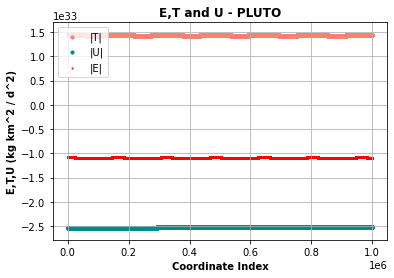

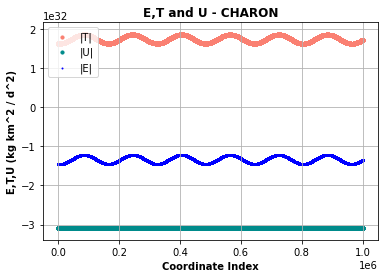

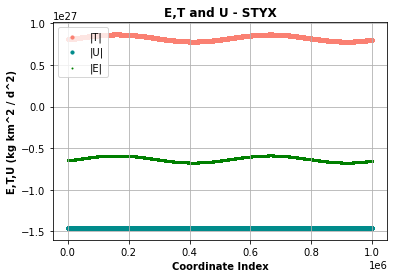

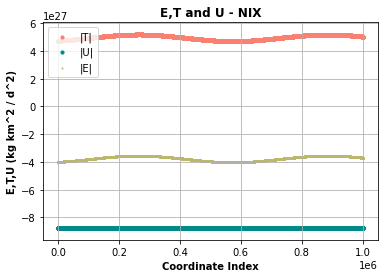

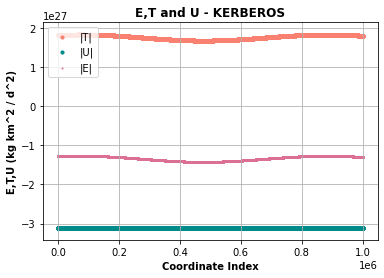

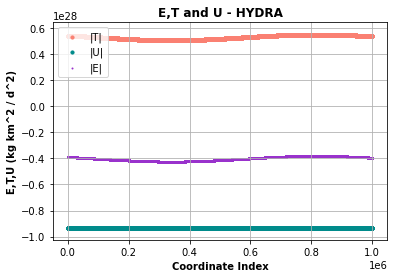

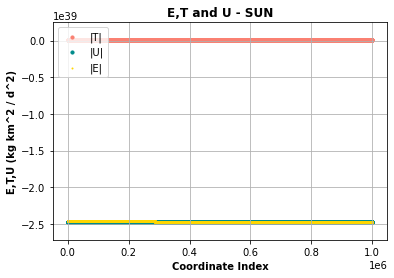

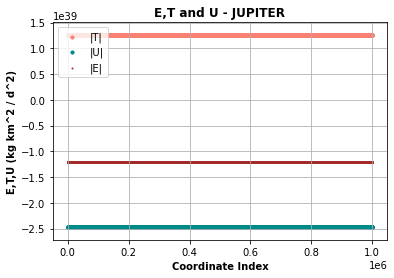

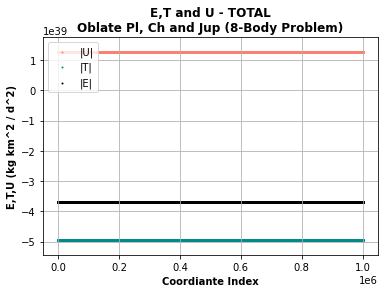

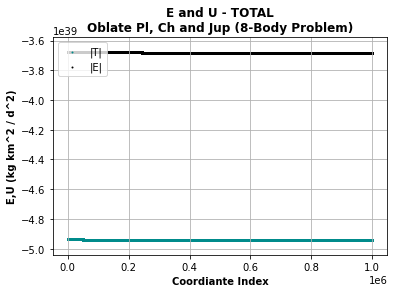

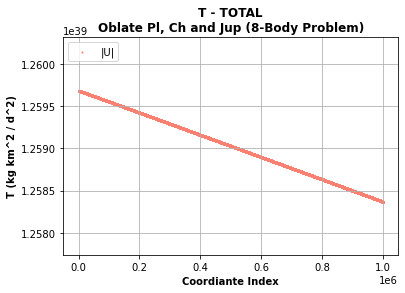

In [104]:
#-------------------------------------------------------------------------------------------------------------------------------
#Energy averages for each body.
print("ENERGY AVERAGES:")
print("Pl:      T =" + str(avg(pl_T_RKS2)) + "    U = " + str(avg(pl_U_RKS2)) + "    E = " +  str(avg(pl_E_RKS2)))
print("Ch:      T =" + str(avg(ch_T_RKS2)) + "    U = " + str(avg(ch_U_RKS2)) + "    E = " +  str(avg(ch_E_RKS2)))
print("St:      T =" + str(avg(st_T_RKS2)) + "    U = " + str(avg(st_U_RKS2)) + "    E = " +  str(avg(st_E_RKS2)))
print("Ni:      T =" + str(avg(ni_T_RKS2)) + "    U = " + str(avg(ni_U_RKS2)) + "    E = " +  str(avg(ni_E_RKS2)))
print("Ke:      T =" + str(avg(ke_T_RKS2)) + "    U = " + str(avg(ke_U_RKS2)) + "    E = " +  str(avg(ke_E_RKS2)))
print("Hy:      T =" + str(avg(hy_T_RKS2)) + "    U = " + str(avg(hy_U_RKS2)) + "    E = " +  str(avg(hy_E_RKS2)))
print("Sun:     T =" + str(avg(sun_T_RKS2)) + "    U = " + str(avg(sun_U_RKS2)) + "    E = " +  str(avg(sun_E_RKS2)))
print("Jup:     T =" + str(avg(jup_T_RKS2)) + "    U = " + str(avg(jup_U_RKS2)) + "    E = " +  str(avg(jup_E_RKS2)))
print("Total:   T =" + str(avg(T_t_RKS2))  + "    U = " + str(avg(U_t_RKS2))  + "    E = " +  str(avg(E_t_RKS2)))

#-------------------------------------------------------------------------------------------------------------------------------
#PLOTS:

#Plotting the energies for each body and for the PLS.
plot_E_RKS("PLUTO",    pl_T_RKS2, pl_U_RKS2, pl_E_RKS2, col_pl)
plot_E_RKS("CHARON",   ch_T_RKS2, ch_U_RKS2, ch_E_RKS2, col_ch)
plot_E_RKS("STYX",     st_T_RKS2, st_U_RKS2, st_E_RKS2, col_st)
plot_E_RKS("NIX",      ni_T_RKS2, ni_U_RKS2, ni_E_RKS2, col_ni)
plot_E_RKS("KERBEROS", ke_T_RKS2, ke_U_RKS2, ke_E_RKS2, col_ke)
plot_E_RKS("HYDRA",    hy_T_RKS2, hy_U_RKS2, hy_E_RKS2, col_hy)
plot_E_RKS("SUN",      sun_T_RKS2, sun_U_RKS2, sun_E_RKS2, col_sun)
plot_E_RKS("JUPITER",  jup_T_RKS2, jup_U_RKS2, jup_E_RKS2, col_jup)

#-------------------------------------------------------------------------------------------------------------------------------
#Plotting the PLS's total energies.
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(range(len(T_t_RKS2)), T_t_RKS2, c="salmon", s=1, label="|U|")
ax1.scatter(range(len(U_t_RKS2)), U_t_RKS2, c="darkcyan", s=1, label="|T|")
ax1.scatter(range(len(E_t_RKS2)), E_t_RKS2, c="black", s=1, label="|E|")
plt.title("E,T and U - TOTAL\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=12)
plt.xlabel("Coordiante Index", fontweight="bold")
plt.ylabel("E,T,U (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
lim_inf = min(np.array([min(E_t_RKS2), min(U_t_RKS2), min(T_t_RKS2)]))
lim_sup = max(np.array([max(E_t_RKS2), max(U_t_RKS2), max(T_t_RKS2)]))
extra = max(np.array([abs(lim_inf), abs(lim_sup)]))
plt.ylim([lim_inf - extra/10, lim_sup + extra/10])
plt.show()

#Zoom to the total and potential energies.
fig = plt.figure()
ax1 = fig.add_subplot(111)  
ax1.scatter(range(len(U_t_RKS2)), U_t_RKS2, c="darkcyan", s=1, label="|T|")
ax1.scatter(range(len(E_t_RKS2)), E_t_RKS2, c="black", s=1, label="|E|")
plt.title("E and U - TOTAL\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=12)
plt.xlabel("Coordiante Index", fontweight="bold")
plt.ylabel("E,U (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
lim_inf = min(np.array([min(E_t_RKS2), min(U_t_RKS2)]))
lim_sup = max(np.array([max(E_t_RKS2), max(U_t_RKS2)]))
extra = max(np.array([abs(lim_inf), abs(lim_sup)]))
plt.ylim([lim_inf - extra/50, lim_sup + extra/50])
plt.show()

#Zoom to the kinetic energy.
fig = plt.figure()
ax1 = fig.add_subplot(111)  
ax1.scatter(range(len(T_t_RKS2)), T_t_RKS2, c="salmon", s=1, label="|U|")
plt.title("T - TOTAL\nOblate Pl, Ch and Jup (8-Body Problem)", fontweight="bold", fontsize=12)
plt.xlabel("Coordiante Index", fontweight="bold")
plt.ylabel("T (kg km^2 / d^2)", fontweight="bold")
plt.legend(loc='upper left')
plt.grid()
plt.ylim([min(T_t_RKS2) - abs(min(T_t_RKS2)/2000), max(T_t_RKS2) + abs(max(T_t_RKS2)/2000)])
plt.show()
